# R code 

In [4]:
library(dplyr)
library(ggplot2)
library(poilog)
library(distr)
library(data.table)


In [5]:
remove_outliers <- function(x){
    quantiles <- quantile( x, c(.05, .95 ) )
    x[ x < quantiles[1] ] <- quantiles[1]
    x[ x > quantiles[2] ] <- quantiles[2]
    x
}


calc_p_expression_fix_e0 <-function(data){
    #data <- na.omit(data) # get rid of NaNs 
    #print(as.numeric(data))
    e0<-250  # hardcoded, could try not hardcoding in the future 
    data<-ceiling(2**data)# data is lognormalized, round up to integer 
    
    # trycatch here 
    
     est <- tryCatch(
        {
            # Just to highlight: if you want to use more than one 
            # R expression in the "try" part then you'll have to 
            # use curly brackets.
            # 'tryCatch()' will return the last evaluated expression 
            # in case the "try" part was completed successfully

            poilogMLE(na.omit(as.numeric(data)))  
            # The return value of `readLines()` is the actual value 
            # that will be returned in case there is no condition 
            # (e.g. warning or error). 
            # You don't need to state the return value via `return()` as code 
            # in the "try" part is not wrapped insided a function (unlike that
            # for the condition handlers for warnings and error below)
        },
        error=function(cond) {
            # Choose a return value in case of error
            #NA
            list(p_exp_t=NA, mu=NA, sig=NA)
        }
    )
    #est<-poilogMLE(na.omit(as.numeric(data)))  #estimate poisson parameters mu and sigma
    
    if (anyNA(est)){
       return(list(p_exp_t=NA, mu=NA, sig=NA))  # not sure if this is a case to watch out for , will give problems if so 
        }
    else{
        data_no<- remove_outliers(as.numeric(data))
        maxExp<-ceiling(max(data_no))#calculate maximum expression in data
        minExp<- ceiling(min(data_no)) 
        pdf<- dpoilog(n=minExp:maxExp,mu=est$par[1],sig=est$par[2]) 
        p_exp_t<- as.double(1- sum(dpoilog(n=0:e0,mu=est$par[1],sig=est$par[2]))) # probability of expression being greater than e0 

        #return(p_exp_t)
        return(list(p_exp_t=p_exp_t, mu=est$par[1], sig=est$par[2]))  #return mu and sigma as well as probability 
    } 
    
}

In [ ]:
# read tissue abbreviation file 
tissue_abbreviation_df<- read.table('/secure/common/group/data/GTEx/V8/V8/sample_annotations/tissue_abbreviations.txt', header=TRUE, sep='\t')

print(tissue_abbreviation_df)

# build data frame for probability of expression for each tissue and gene 
p_expression<- data.frame(Name= character(),Description=character(), stringsAsFactors = FALSE)  
mu_df<- data.frame(Name= character(),Description=character(), stringsAsFactors = FALSE) 
sigma_df<- data.frame(Name= character(),Description=character(), stringsAsFactors = FALSE)  

#for loop through all tissues 
for(row in 1:nrow(tissue_abbreviation_df)){ #nrow(tissue_abbreviation_df)){
    tissue_name<- tissue_abbreviation_df[row, "tissue_name"]
    print(tissue_name)
    tissue_file<- tissue_abbreviation_df[row, "file_name"]
    tissue_dir<- paste('/home/nehsan/data/rnaseq/',toString(tissue_file), sep="")
    
    # check if directory exists 
    if(dir.exists(tissue_dir)){
       
        tissue_data<- read.csv(file= paste(tissue_dir,'/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_reads_normalized.csv', sep=""), header=TRUE, sep=",")
       
        #print(dim(tissue_data))
        # change here to include normalized data above, read this file 
        
        drops <- c("Name","Description")
        #print(tissue_data[1 , !(names(tissue_data) %in% drops)])
        #print(as.numeric(tissue_data[1 , !(names(tissue_data) %in% drops)]))
        
        #test PoilogMLE with one row first 
        #est<-poilogMLE(as.numeric(ceiling(tissue_data[1 , !(names(tissue_data) %in% drops)])))
        
        
        #hist(as.numeric(tissue_data[1 , !(names(tissue_data) %in% drops)]))
        #calculate probability with estimates 
        #prob<- dpoilog(n=0:15000,mu=est$par[1],sig=est$par[2])
        #print(prob)
        ### plot density for given parameters 
        #barplot(dpoilog(n=0:15000,mu=est$par[1],sig=est$par[2]),names.arg=0:15000)

        #print(sum(dpoilog(n=0:15000,mu=est$par[1],sig=est$par[2]))) #should add up to one
        #print(sum(dpoilog(n=0:100,mu=est$par[1],sig=est$par[2]))) # should be low, 
        
        # Fit Poison log normal model and calculate probability of expression to every gene 
        
        #exp<- calc_p_expression_fix_e0(tissue_data[2 , !(names(tissue_data) %in% drops)])
        exp_t<- apply(tissue_data[, !(names(tissue_data) %in% drops)], 1, calc_p_expression_fix_e0)
        #add gene names to exp2 data
        
        #print(exp_t)
        exp_t_df<-rbindlist(exp_t, fill=TRUE)  # convert nested list return to dataframe 
        
        #print(exp_t_df[, c('mu','sig')])  #contains mu and sigma results to save for tissue 

        p_exp_t<-exp_t_df[, 'p_exp_t']
        
        #save sigma and mu here 
        
        #print(p_exp_t)
        #print("exp$p_exp_t")
        #print(exp$p_exp_t) # this is probability of expression, you should save in a column and store in csv for python to read 
        
        
        #populate dataframe with tissue name and p_expression , (genes as rows), column is tissue 
        dftissue<-data.frame(p_exp_t)
        paramstissue<-data.frame(exp_t_df[, c('mu', 'sig')])
        #print('dftissue')
        #print(dftissue)
        names(dftissue) <- tissue_name #name column with tissue name 
        df_p_exp<- cbind(tissue_data[, names(tissue_data) %in% drops], dftissue)  #genes name and description
        df_params<-cbind(tissue_data[, names(tissue_data) %in% drops], paramstissue)
        
        #print('dfexp')
        print(df_p_exp)
        print(df_params)
        
        #p_expression<- merge(p_expression, dfexp, all=TRUE) #to do: specify on names and description
        
        #print(p_expression)
        print('p_expression saved for tissue')
        
        #save dataframe p_expression in csv_file 
        write.csv(df_p_exp,paste(toString(tissue_file),'_p_expression_poilog_e0250.csv', sep=''))
        write.csv(df_params,paste(toString(tissue_file),'_params_poilog.csv', sep=''))
        
        #print(tissue_data[1, names(tissue_data) %in% drops]) #gene name 
    }
} 



 

                                 tissue_name tissue_abbrv
1                     Adipose - Subcutaneous       ADPSBQ
2               Adipose - Visceral (Omentum)       ADPVSC
3                              Adrenal Gland       ADRNLG
4                             Artery - Aorta      ARTAORT
5                          Artery - Coronary       ARTCRN
6                            Artery - Tibial       ARTTBL
7                                    Bladder       BLDDER
8                           Brain - Amygdala       BRNAMY
9   Brain - Anterior cingulate cortex (BA24)       BRNACC
10           Brain - Caudate (basal ganglia)       BRNCDT
11             Brain - Cerebellar Hemisphere       BRNCHB
12                        Brain - Cerebellum       BRNCHA
13                            Brain - Cortex      BRNCTXA
14              Brain - Frontal Cortex (BA9)      BRNCTXB
15                       Brain - Hippocampus       BRNHPP
16                      Brain - Hypothalamus       BRNHPT
17 Brain - Nuc

Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2

Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2

Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2

Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2

Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2

Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”
Warning message in log(1 - dpoilog(0, z[1], exp(z[2

In [60]:
print(exp_t)

[[1]]
[[1]]$p_exp_t
[1] 1.466372e-07

[[1]]$mu
      mu 
2.490666 

[[1]]$sig
         sig 
0.0006615204 


[[2]]
[[2]]$p_exp_t
[1] 1.437722e-07

[[2]]$mu
      mu 
2.337385 

[[2]]$sig
         sig 
0.0001078976 


[[3]]
[[3]]$p_exp_t
[1] 1.46782e-07

[[3]]$mu
      mu 
2.169194 

[[3]]$sig
        sig 
0.001457757 


[[4]]
[[4]]$p_exp_t
[1] 1.466927e-07

[[4]]$mu
      mu 
2.456208 

[[4]]$sig
        sig 
0.001151326 


[[5]]
[[5]]$p_exp_t
[1] 1.468052e-07

[[5]]$mu
      mu 
2.674737 

[[5]]$sig
        sig 
0.001329004 


[[6]]
[[6]]$p_exp_t
[1] 1.46733e-07

[[6]]$mu
      mu 
2.467015 

[[6]]$sig
        sig 
0.001421073 


[[7]]
[[7]]$p_exp_t
[1] -3.195642e-08

[[7]]$mu
      mu 
2.408247 

[[7]]$sig
        sig 
4.69264e-07 


[[8]]
[[8]]$p_exp_t
[1] 1.467984e-07

[[8]]$mu
      mu 
2.214724 

[[8]]$sig
        sig 
0.001830681 


[[9]]
[[9]]$p_exp_t
[1] 1.462943e-07

[[9]]$mu
      mu 
2.294207 

[[9]]$sig
         sig 
0.0003311682 


[[10]]
[[10]]$p_exp_t
[1] 1.467184e-07

[

In [43]:
print(p_exp_t[1]$'1')



newdf<-rbindlist(p_exp_t, fill=TRUE) 

print(newdf[, c('mu','sig')])

print(newdf[, 'p_exp_t'])

$p_exp_t
[1] 1

$mu
      mu 
7.949934 

$sig
      sig 
0.4200207 

         mu       sig
1: 7.949934 0.4200207
2: 6.589458 0.3431811
3: 5.361206 0.3684587
     p_exp_t
1: 1.0000000
2: 0.9988762
3: 0.3321213


# Figure out what threshold to use by looking at GTEx stats 

                                 tissue_name tissue_abbrv
1                     Adipose - Subcutaneous       ADPSBQ
2               Adipose - Visceral (Omentum)       ADPVSC
3                              Adrenal Gland       ADRNLG
4                             Artery - Aorta      ARTAORT
5                          Artery - Coronary       ARTCRN
6                            Artery - Tibial       ARTTBL
7                                    Bladder       BLDDER
8                           Brain - Amygdala       BRNAMY
9   Brain - Anterior cingulate cortex (BA24)       BRNACC
10           Brain - Caudate (basal ganglia)       BRNCDT
11             Brain - Cerebellar Hemisphere       BRNCHB
12                        Brain - Cerebellum       BRNCHA
13                            Brain - Cortex      BRNCTXA
14              Brain - Frontal Cortex (BA9)      BRNCTXB
15                       Brain - Hippocampus       BRNHPP
16                      Brain - Hypothalamus       BRNHPT
17 Brain - Nuc

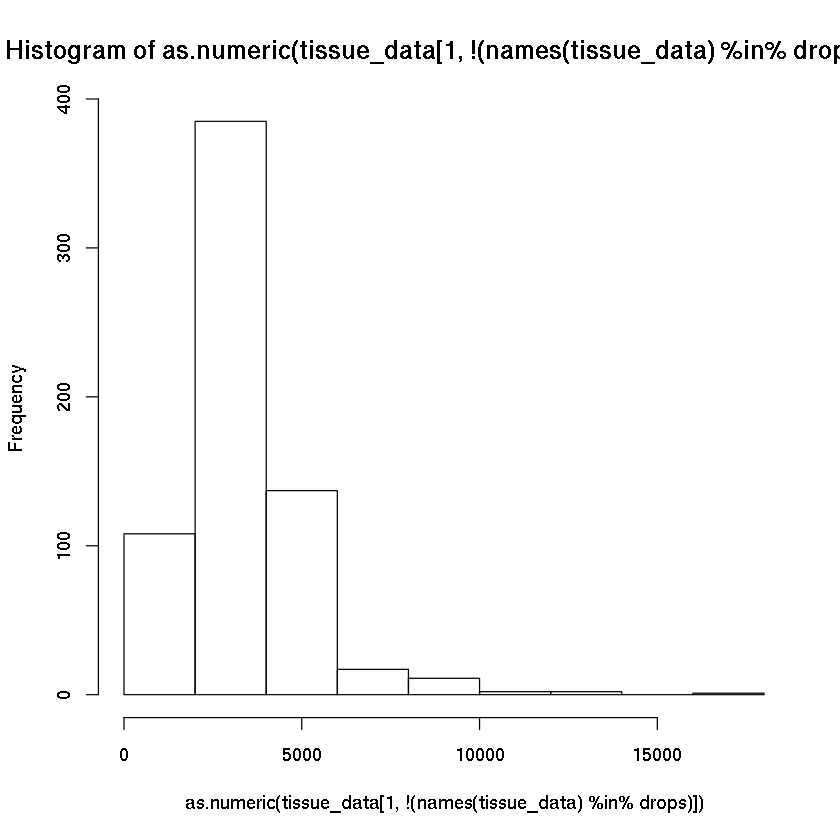

[1] Adrenal Gland
54 Levels: Adipose - Subcutaneous ... Whole Blood


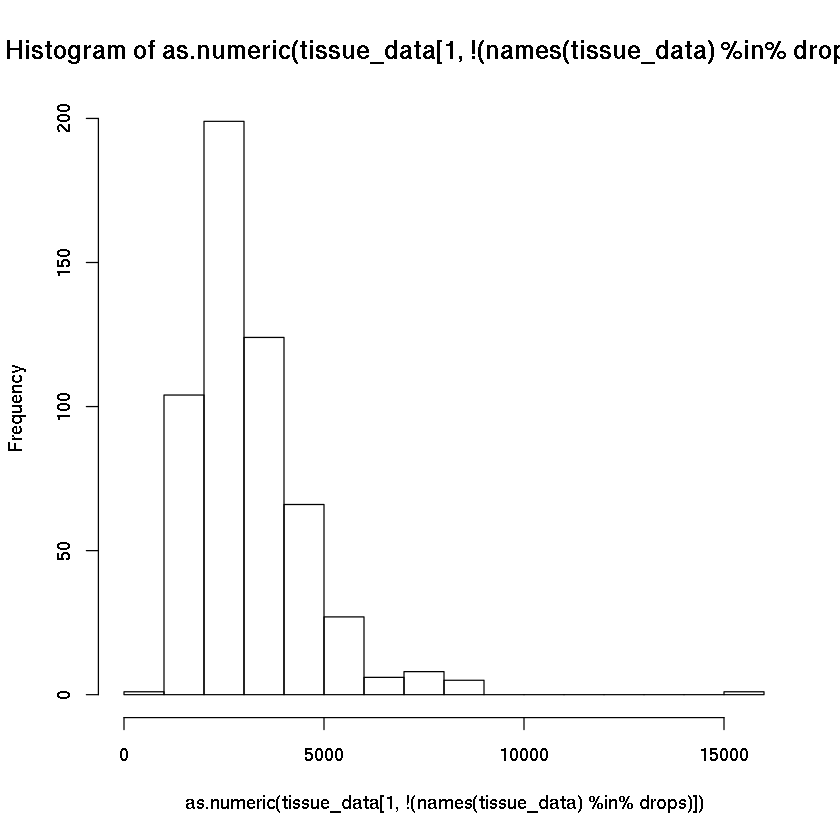

[1] Artery - Aorta
54 Levels: Adipose - Subcutaneous ... Whole Blood


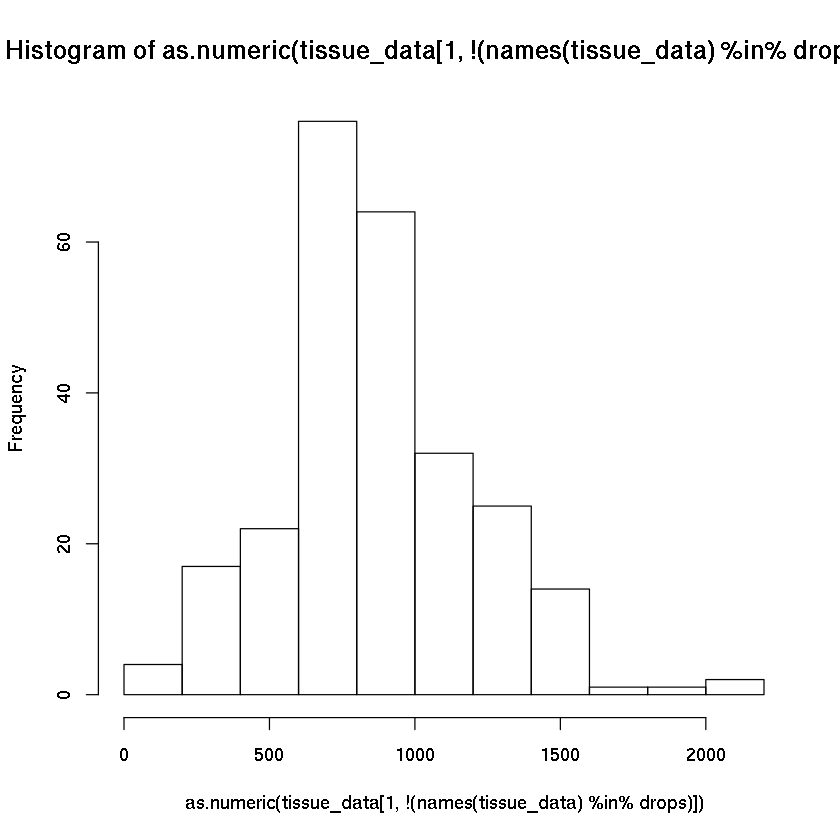

[1] Artery - Coronary
54 Levels: Adipose - Subcutaneous ... Whole Blood


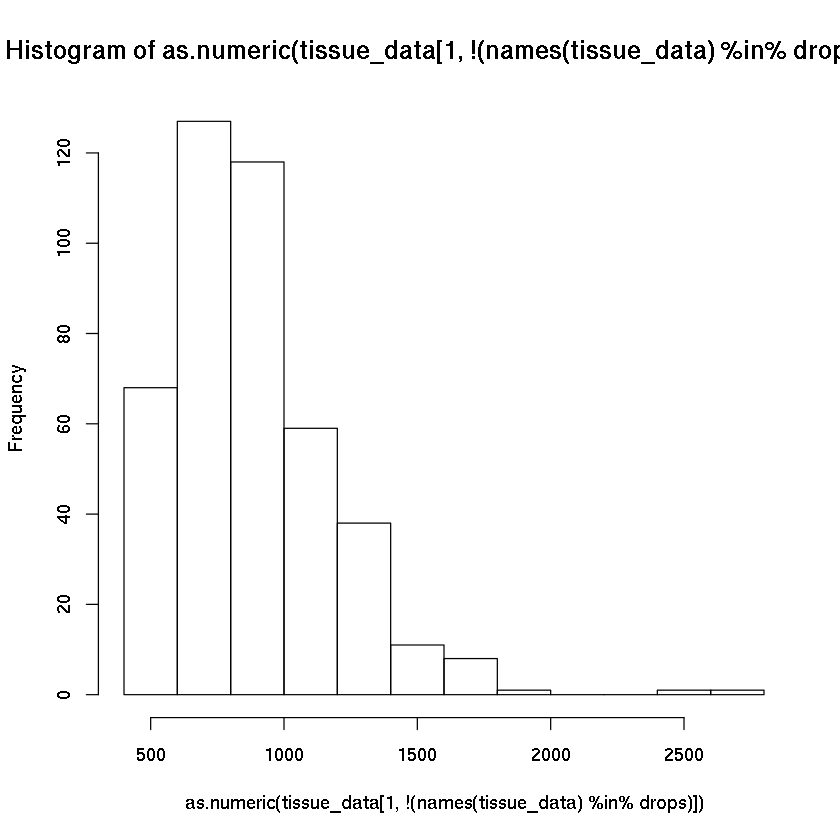

[1] Artery - Tibial
54 Levels: Adipose - Subcutaneous ... Whole Blood


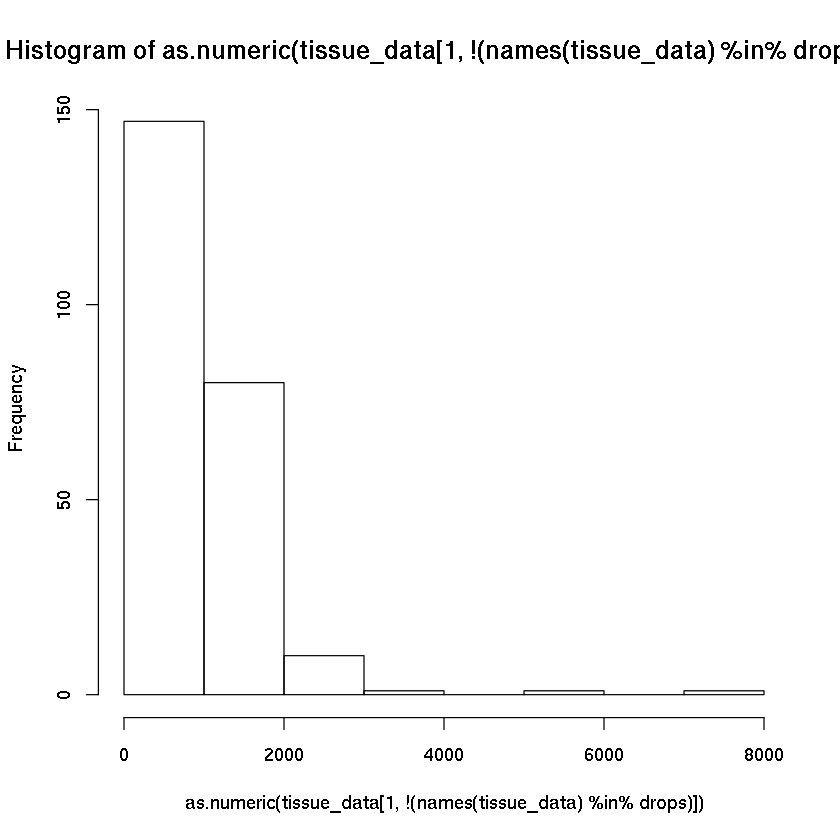

[1] Bladder
54 Levels: Adipose - Subcutaneous ... Whole Blood
[1] Brain - Amygdala
54 Levels: Adipose - Subcutaneous ... Whole Blood


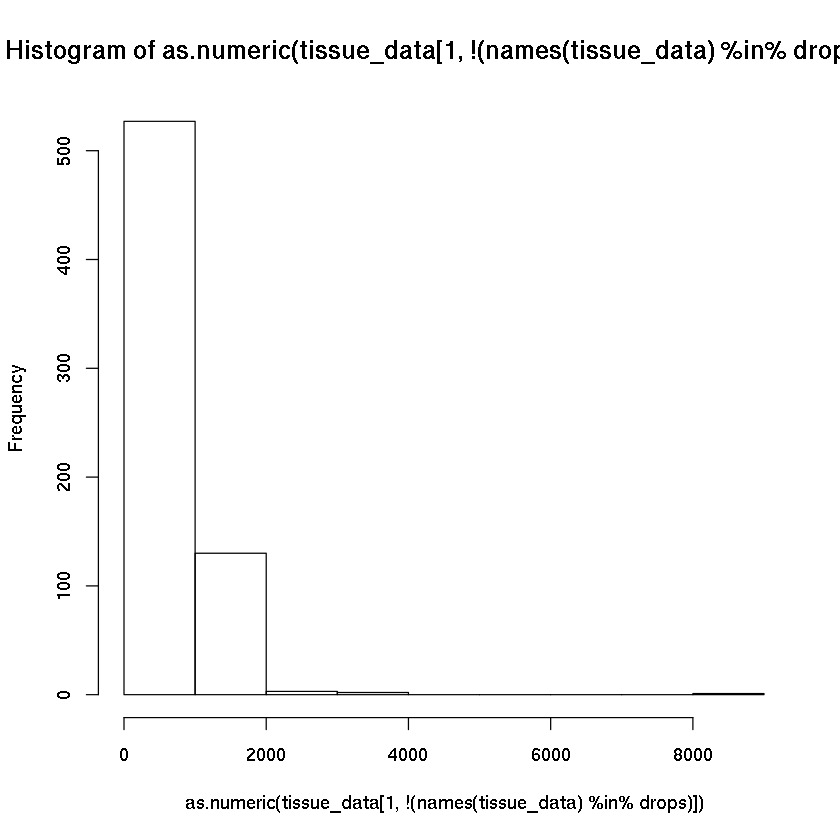

[1] Brain - Anterior cingulate cortex (BA24)
54 Levels: Adipose - Subcutaneous ... Whole Blood


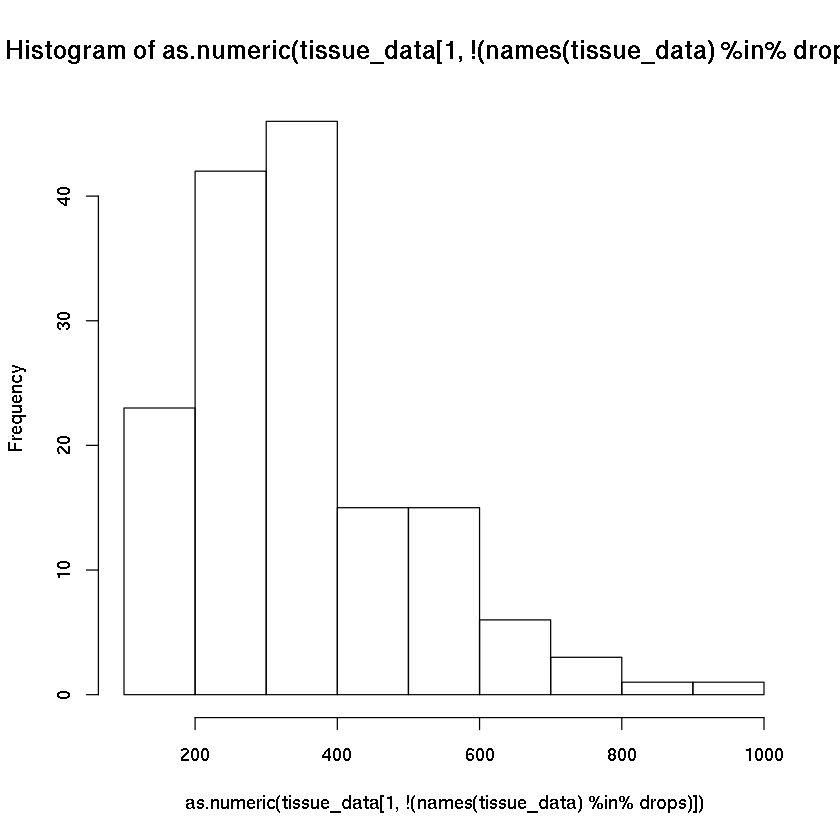

[1] Brain - Caudate (basal ganglia)
54 Levels: Adipose - Subcutaneous ... Whole Blood


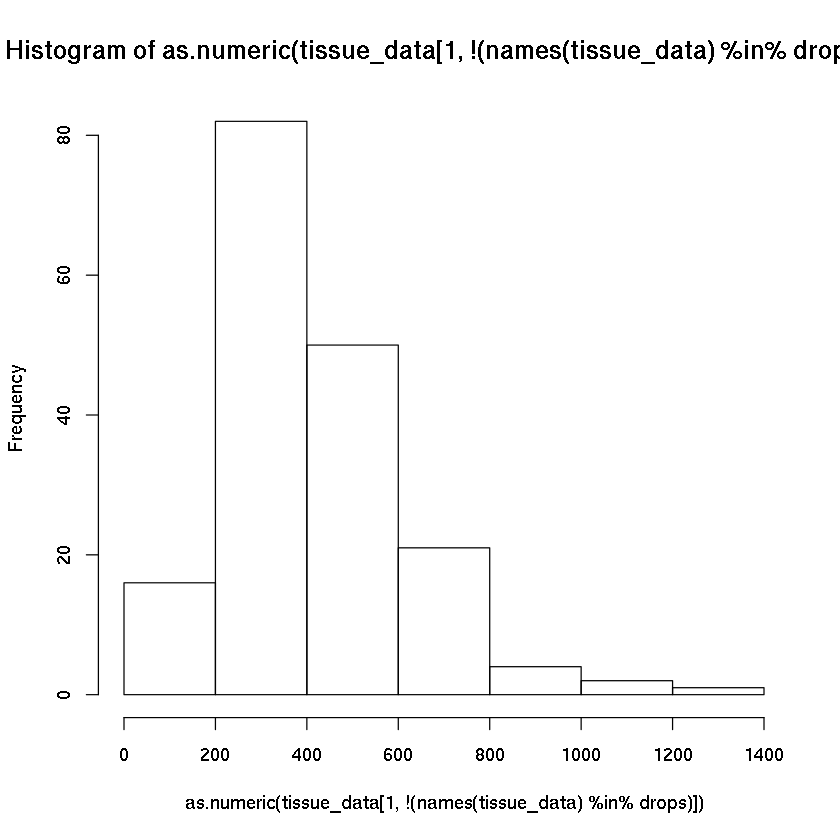

[1] Brain - Cerebellar Hemisphere
54 Levels: Adipose - Subcutaneous ... Whole Blood


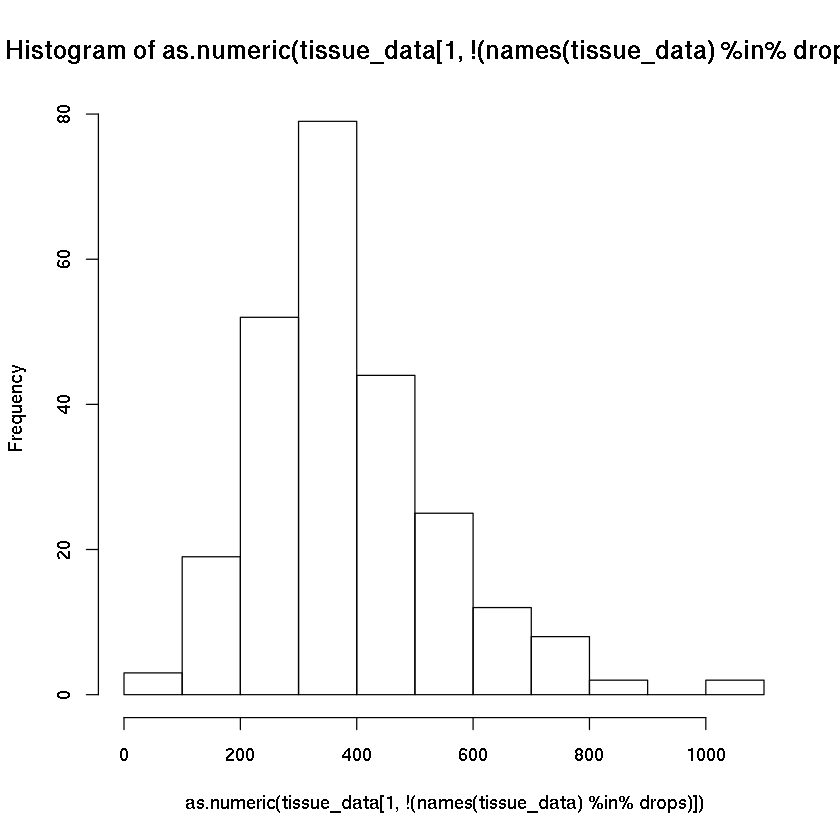

[1] Brain - Cerebellum
54 Levels: Adipose - Subcutaneous ... Whole Blood


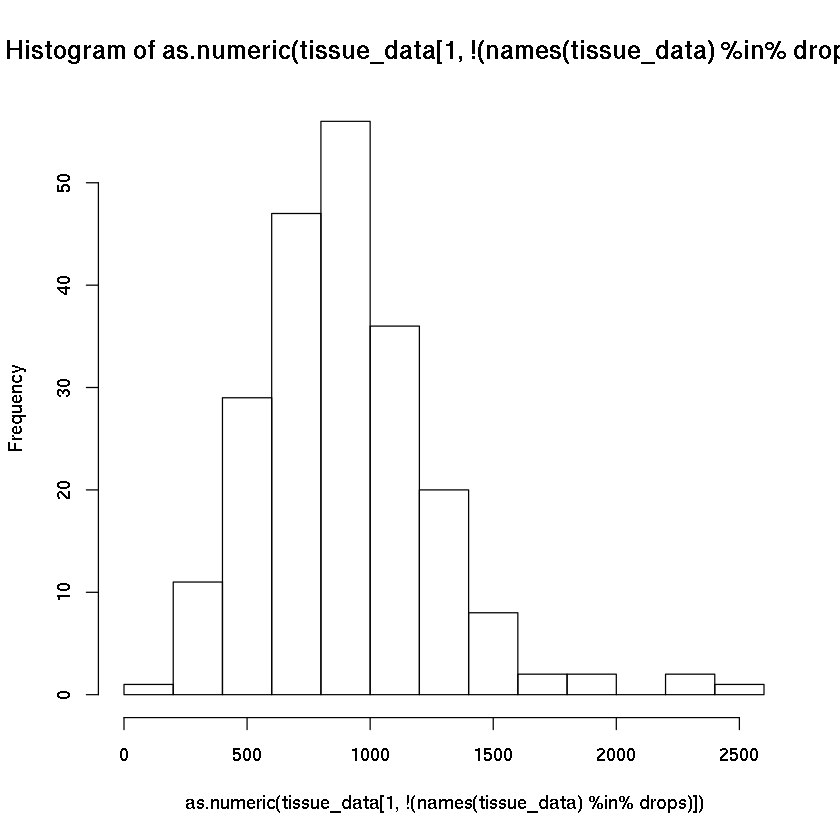

[1] Brain - Cortex
54 Levels: Adipose - Subcutaneous ... Whole Blood


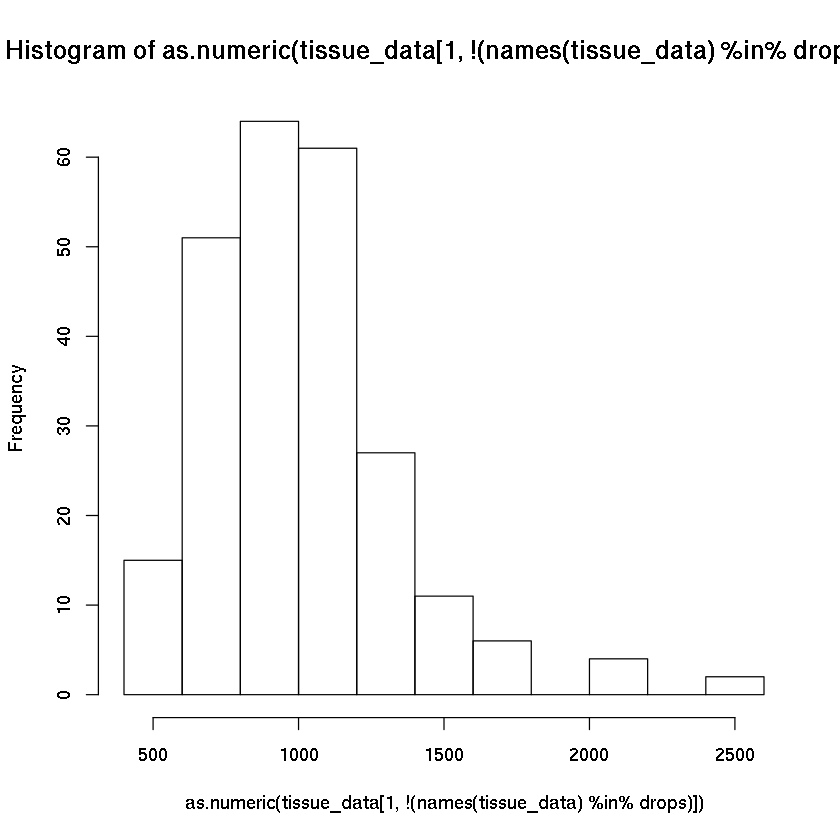

[1] Brain - Frontal Cortex (BA9)
54 Levels: Adipose - Subcutaneous ... Whole Blood


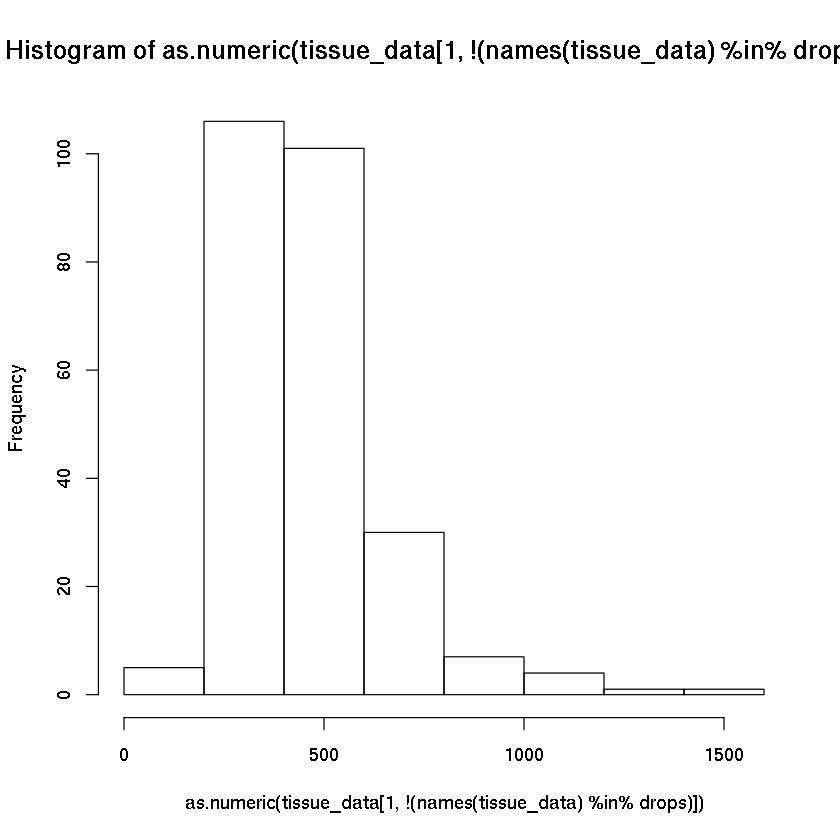

[1] Brain - Hippocampus
54 Levels: Adipose - Subcutaneous ... Whole Blood


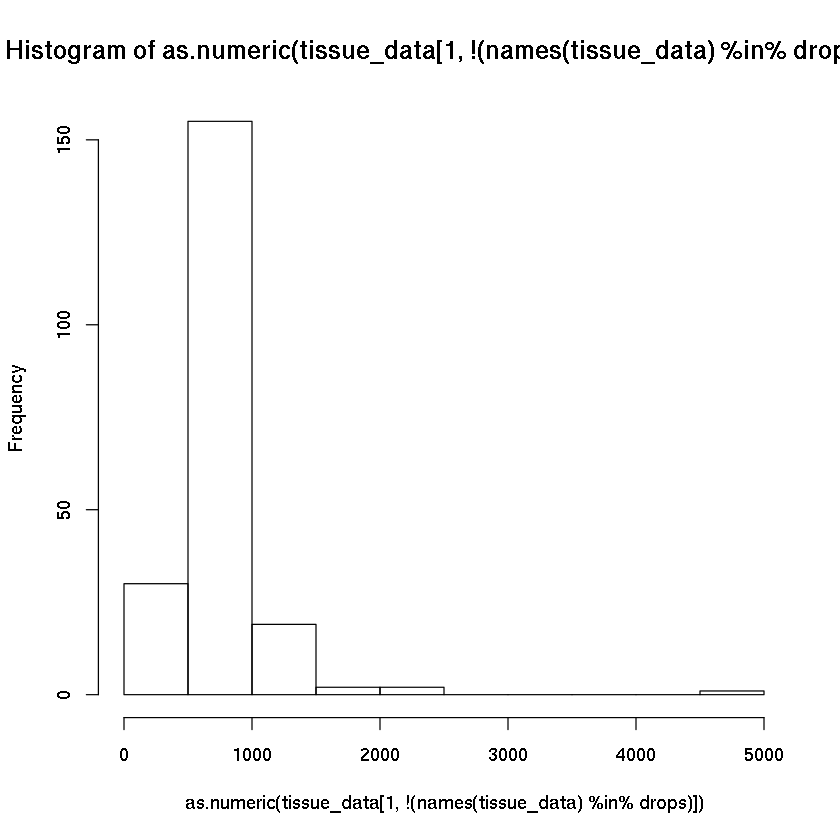

[1] Brain - Hypothalamus
54 Levels: Adipose - Subcutaneous ... Whole Blood


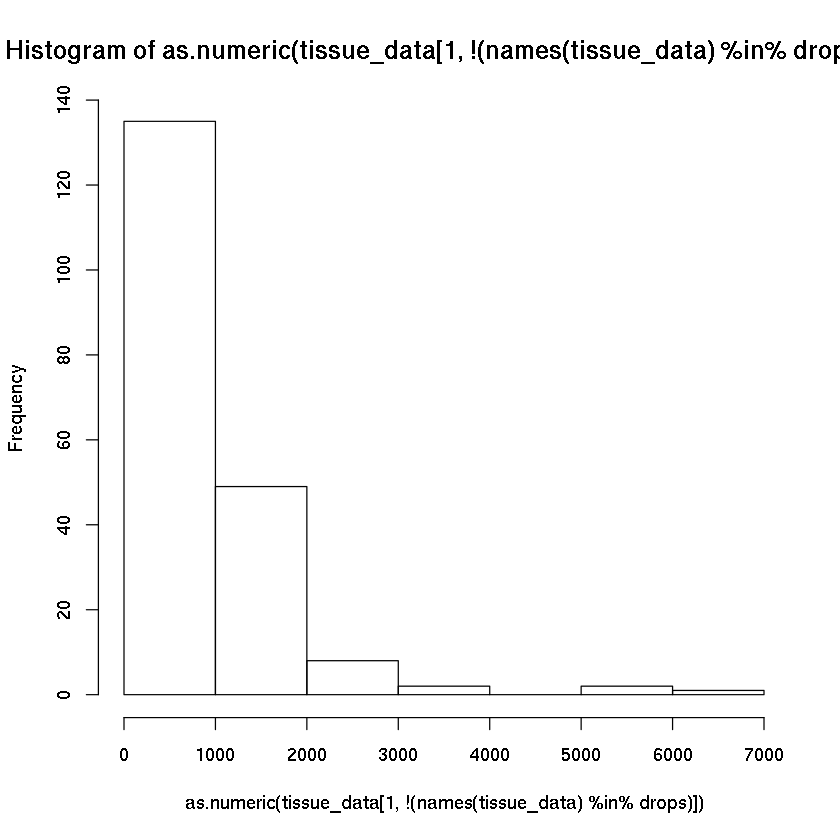

[1] Brain - Nucleus accumbens (basal ganglia)
54 Levels: Adipose - Subcutaneous ... Whole Blood


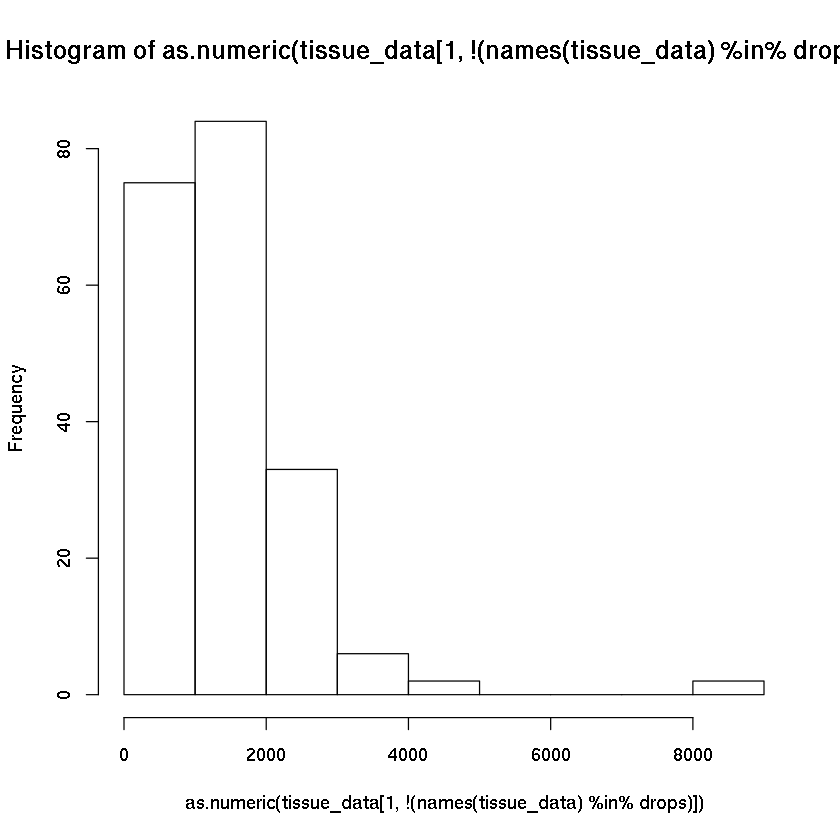

[1] Brain - Putamen (basal ganglia)
54 Levels: Adipose - Subcutaneous ... Whole Blood


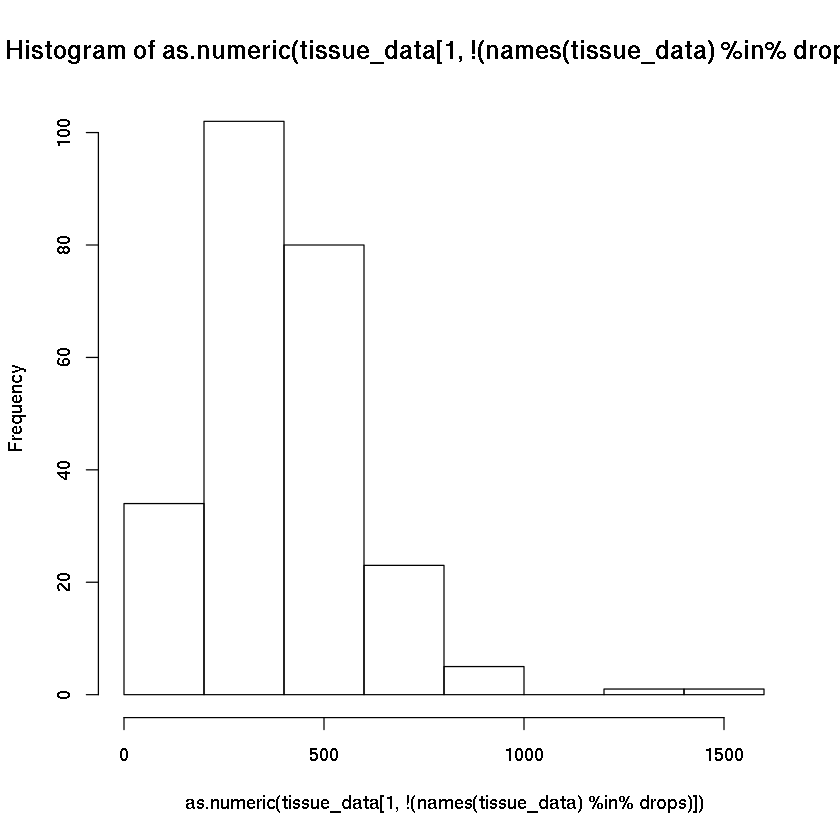

[1] Brain - Spinal cord (cervical c-1)
54 Levels: Adipose - Subcutaneous ... Whole Blood


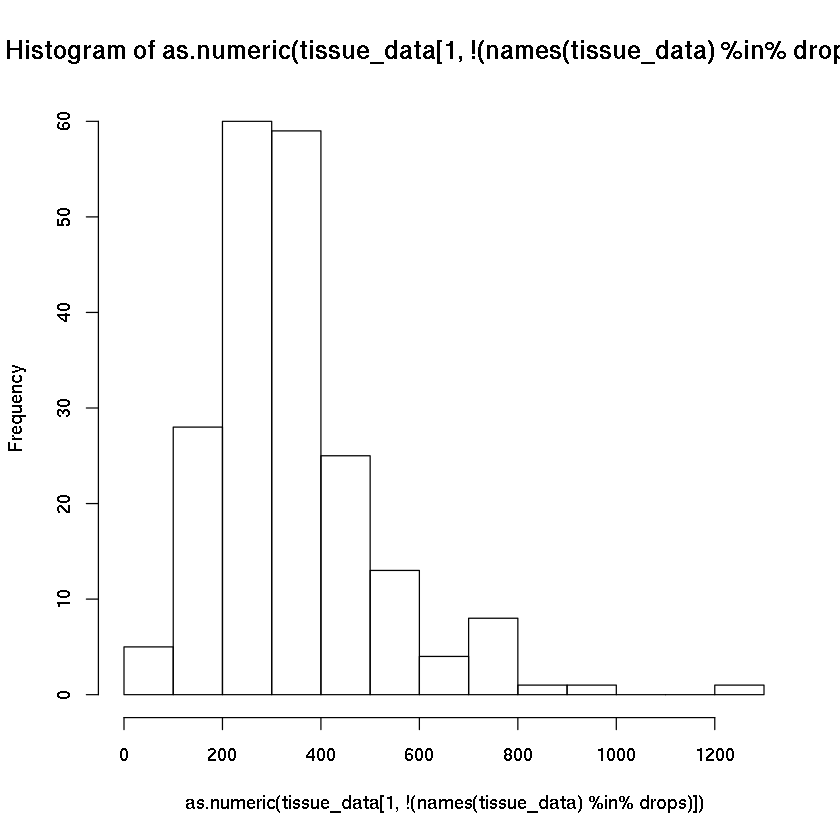

[1] Brain - Substantia nigra
54 Levels: Adipose - Subcutaneous ... Whole Blood


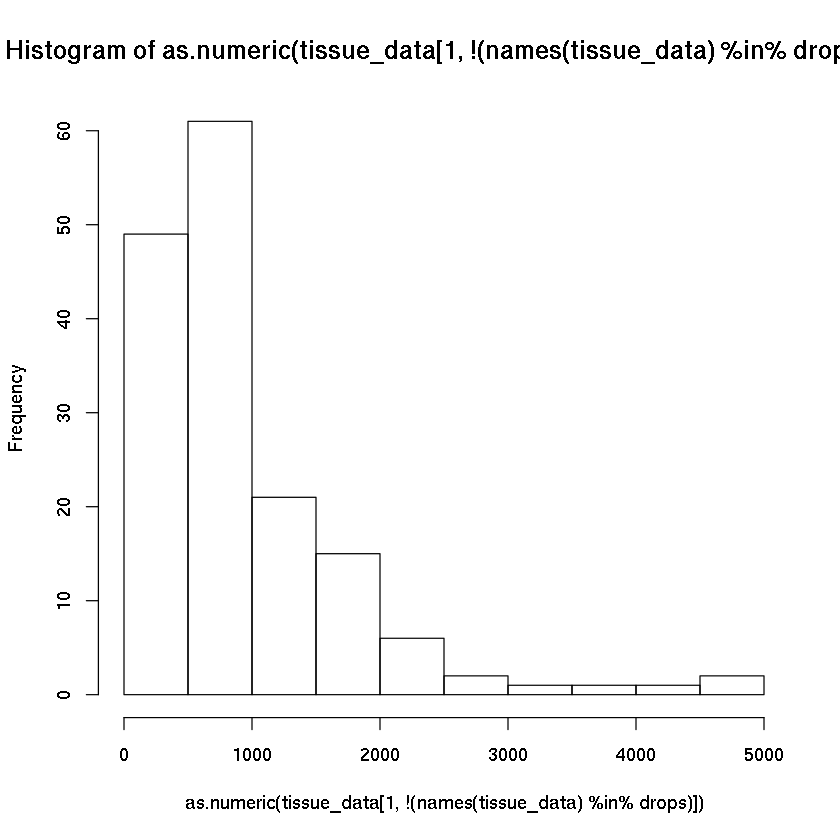

[1] Breast - Mammary Tissue
54 Levels: Adipose - Subcutaneous ... Whole Blood


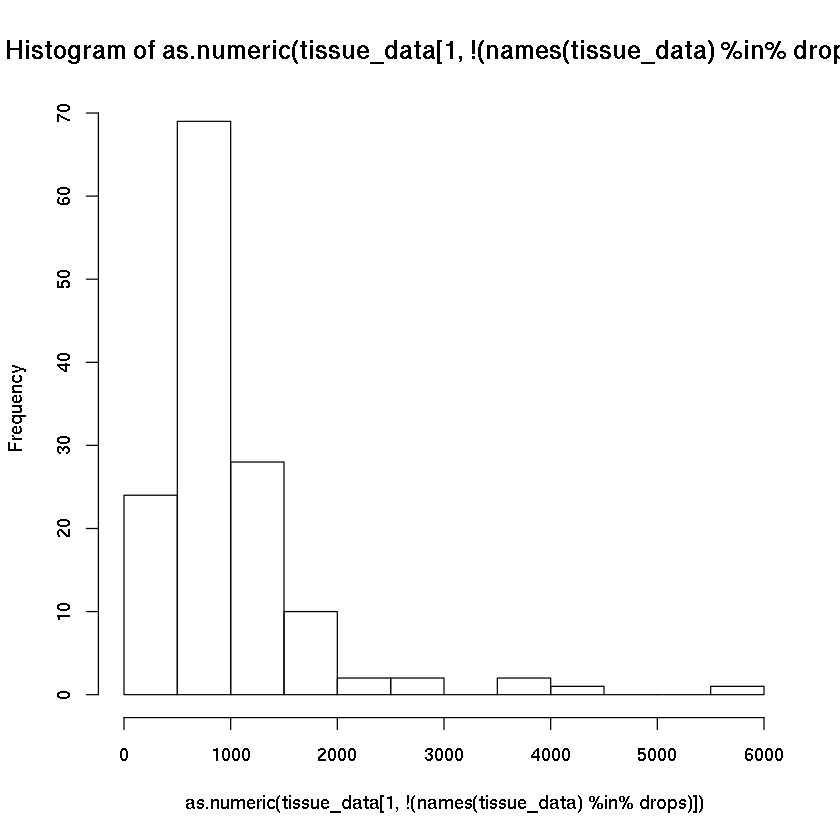

[1] Cells - EBV-transformed lymphocytes
54 Levels: Adipose - Subcutaneous ... Whole Blood


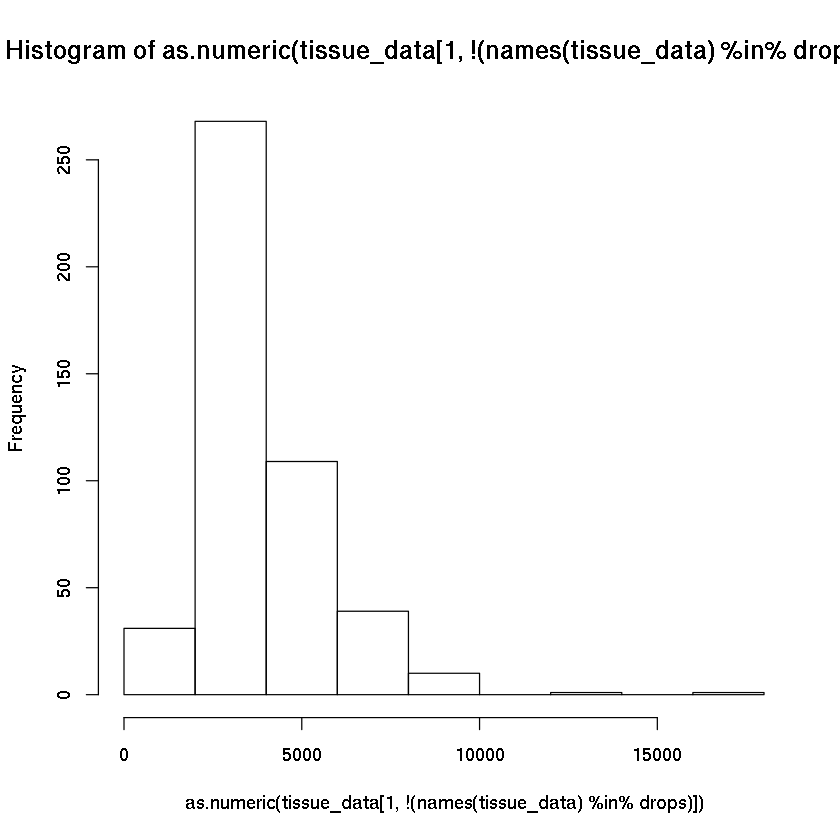

[1] Cells - Cultured fibroblasts
54 Levels: Adipose - Subcutaneous ... Whole Blood


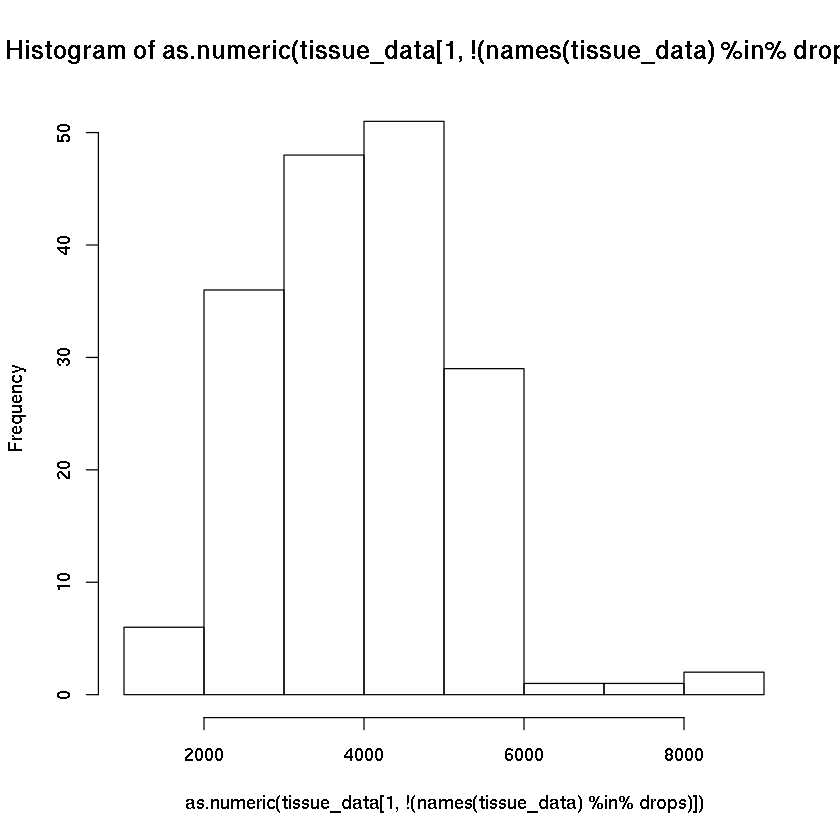

[1] Cervix - Ectocervix
54 Levels: Adipose - Subcutaneous ... Whole Blood
[1] Cervix - Endocervix
54 Levels: Adipose - Subcutaneous ... Whole Blood
[1] Colon - Sigmoid
54 Levels: Adipose - Subcutaneous ... Whole Blood


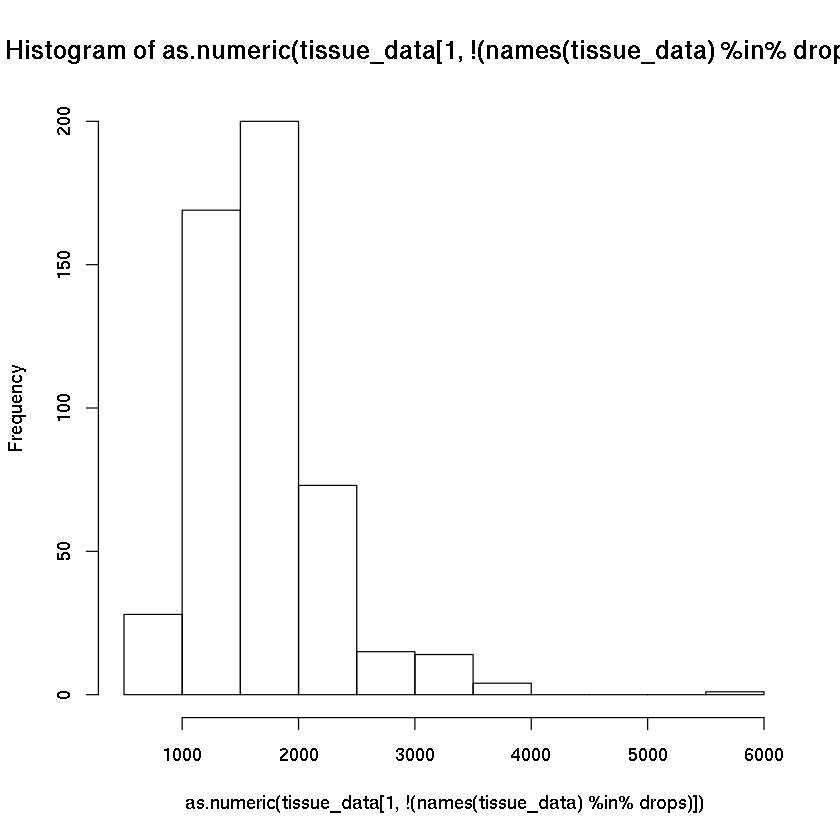

[1] Colon - Transverse
54 Levels: Adipose - Subcutaneous ... Whole Blood


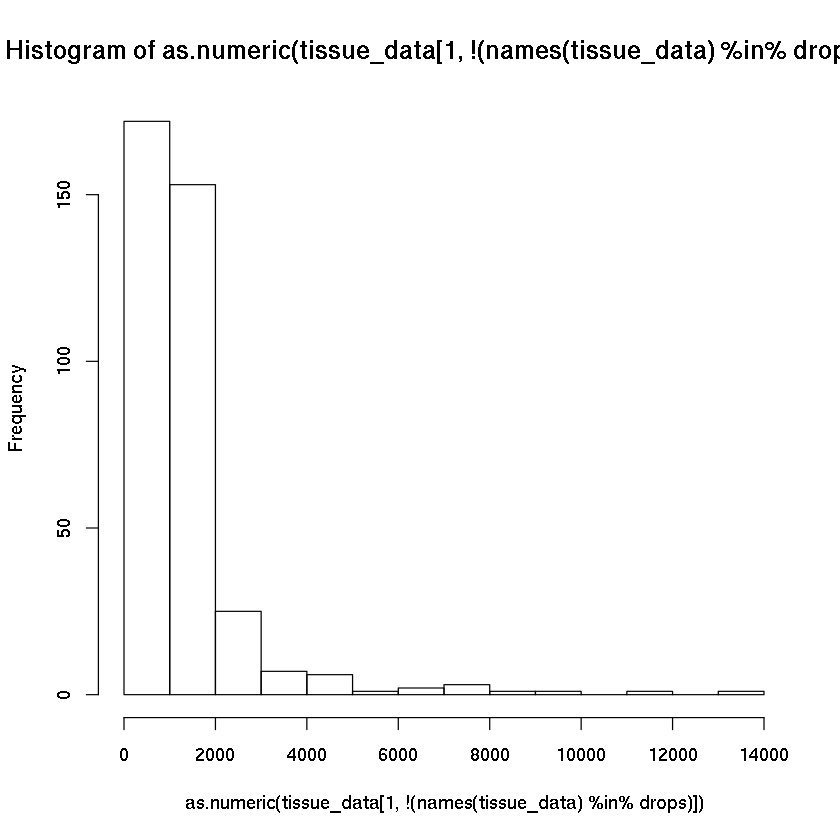

[1] Esophagus - Gastroesophageal Junction
54 Levels: Adipose - Subcutaneous ... Whole Blood


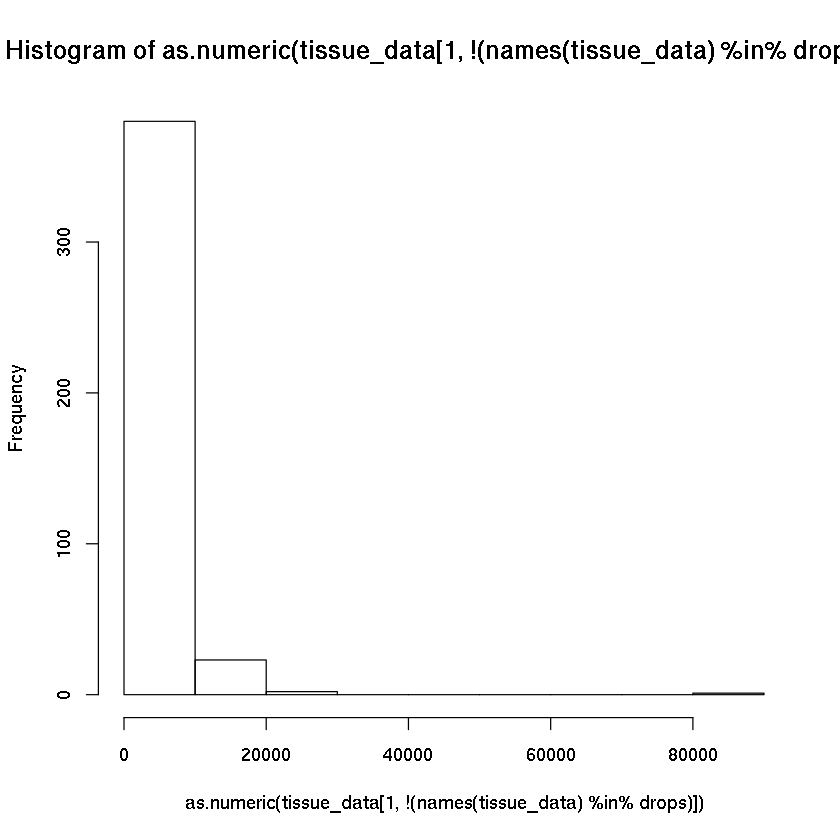

[1] Esophagus - Mucosa
54 Levels: Adipose - Subcutaneous ... Whole Blood


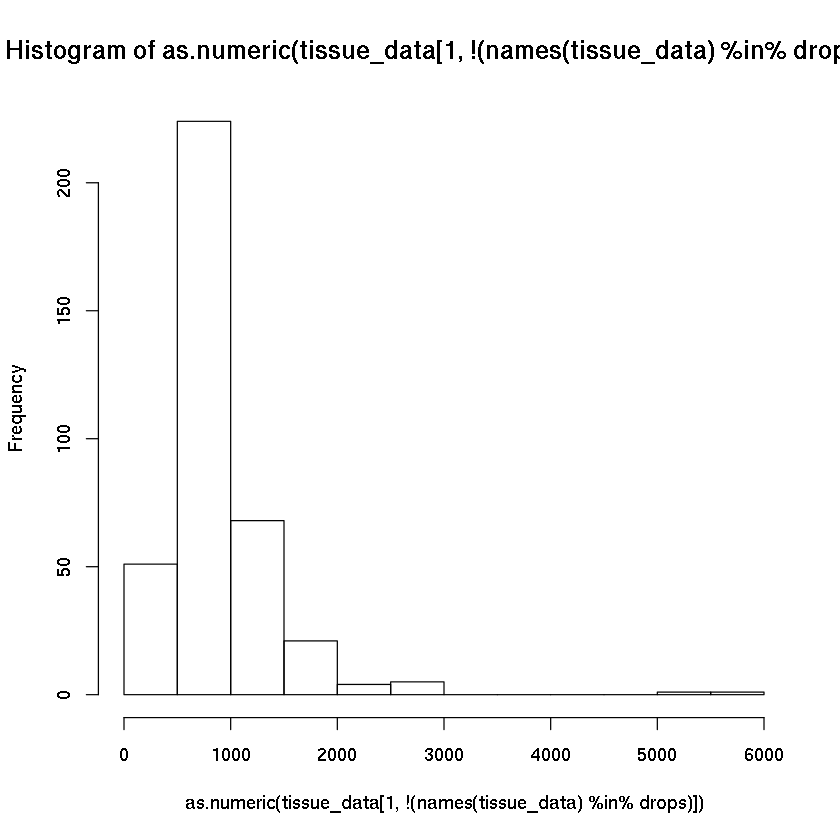

[1] Esophagus - Muscularis
54 Levels: Adipose - Subcutaneous ... Whole Blood


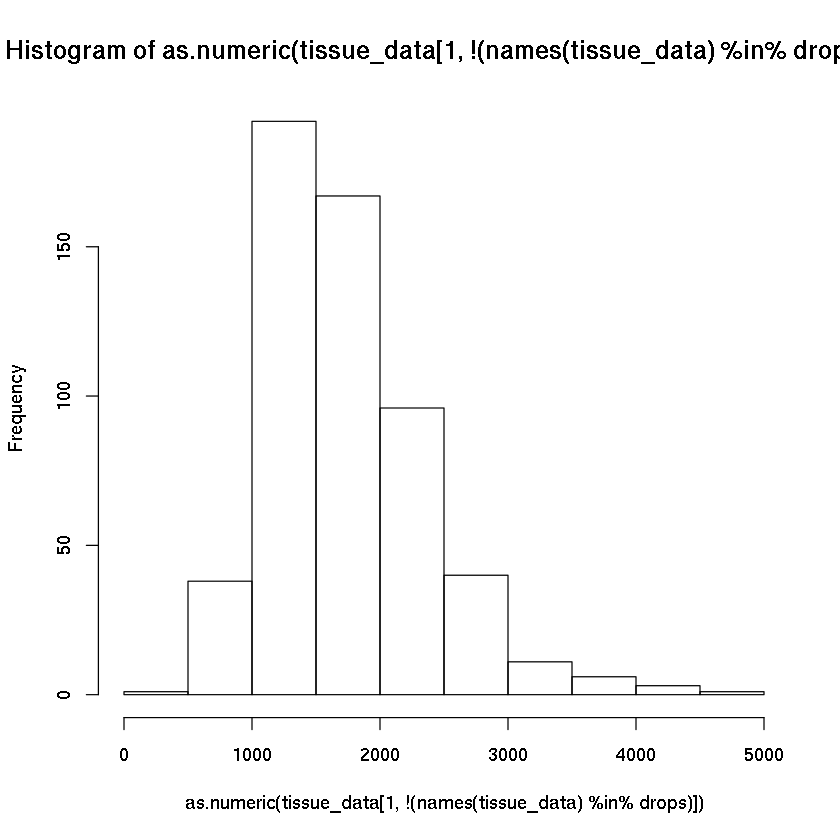

[1] Fallopian Tube
54 Levels: Adipose - Subcutaneous ... Whole Blood
[1] Heart - Atrial Appendage
54 Levels: Adipose - Subcutaneous ... Whole Blood


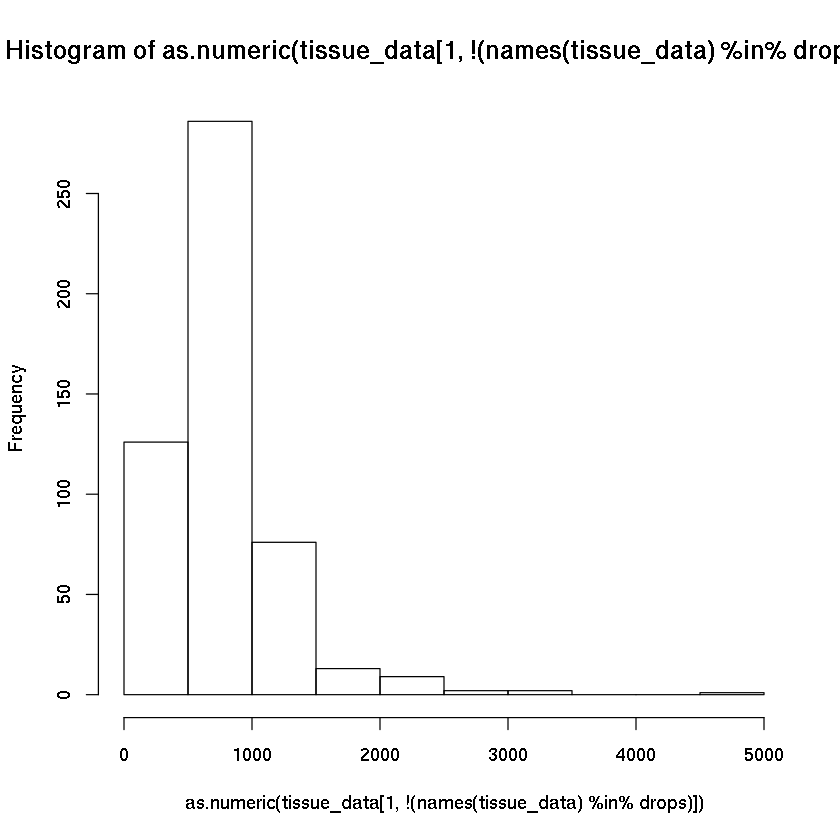

[1] Heart - Left Ventricle
54 Levels: Adipose - Subcutaneous ... Whole Blood


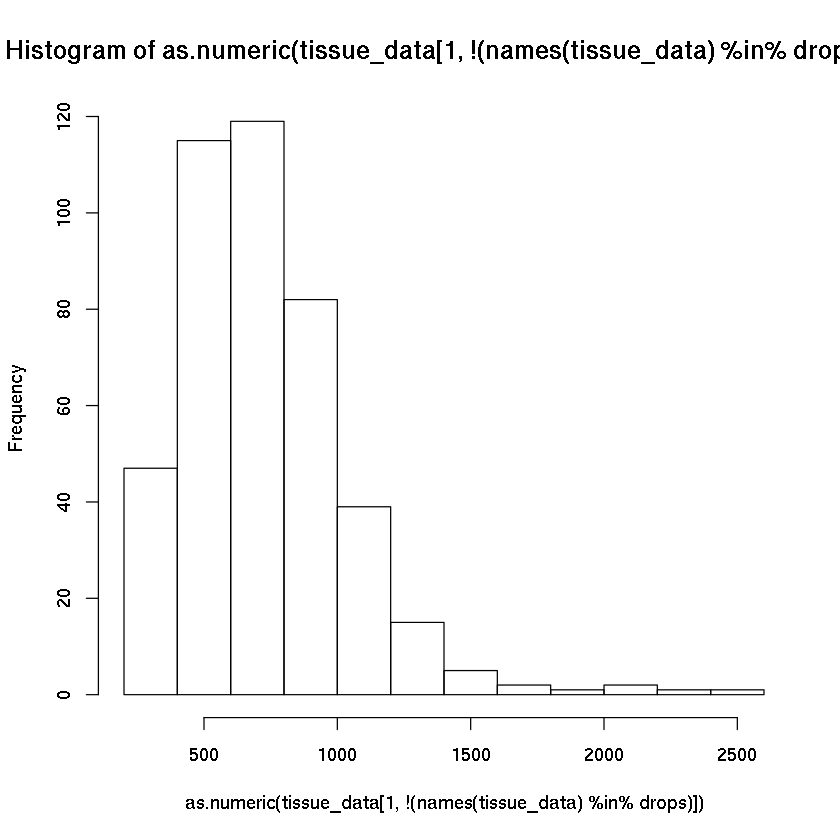

[1] Kidney - Cortex
54 Levels: Adipose - Subcutaneous ... Whole Blood


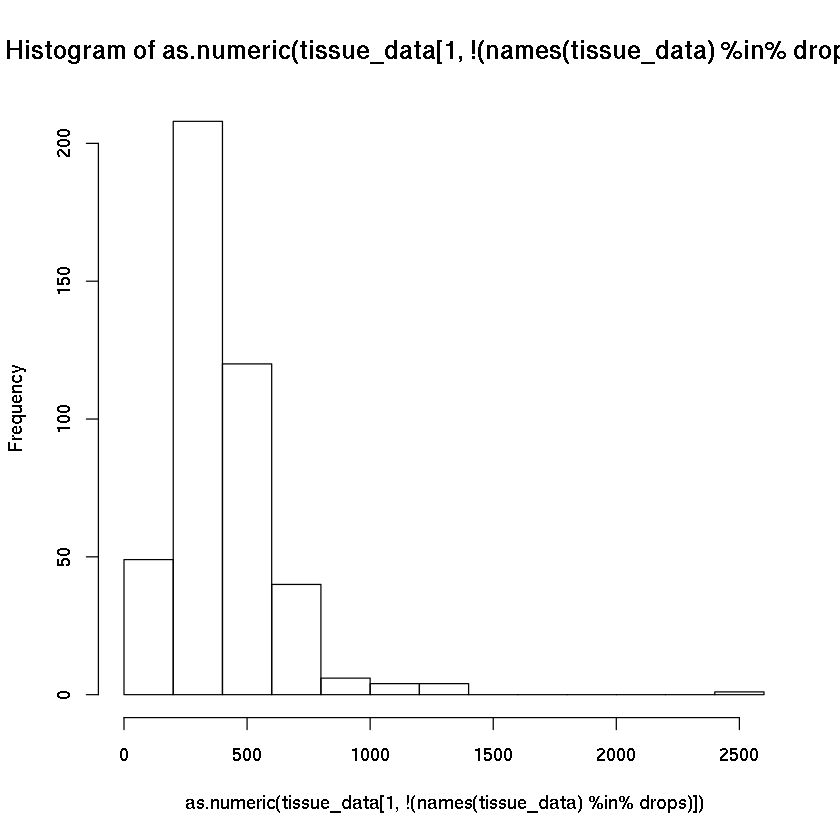

[1] Kidney - Medulla
54 Levels: Adipose - Subcutaneous ... Whole Blood
[1] Liver
54 Levels: Adipose - Subcutaneous ... Whole Blood


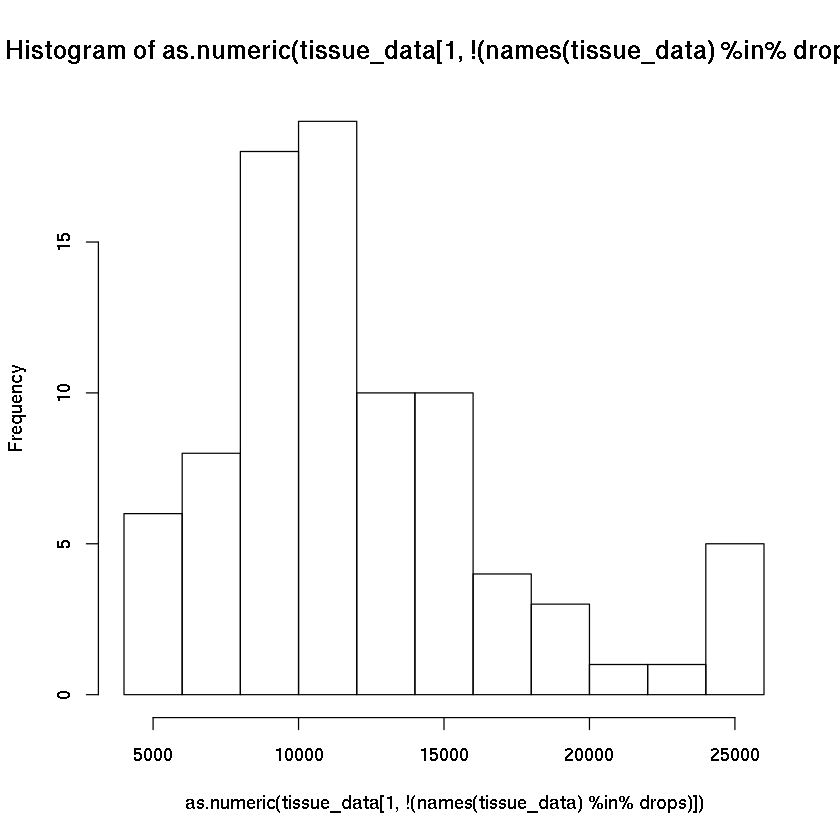

[1] Lung
54 Levels: Adipose - Subcutaneous ... Whole Blood


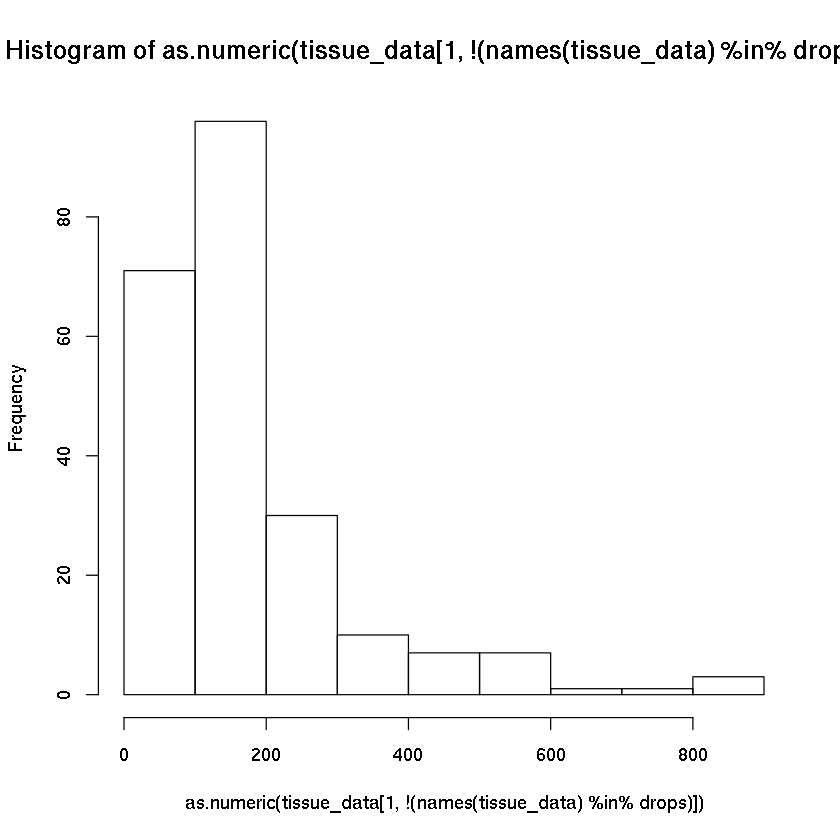

[1] Minor Salivary Gland
54 Levels: Adipose - Subcutaneous ... Whole Blood


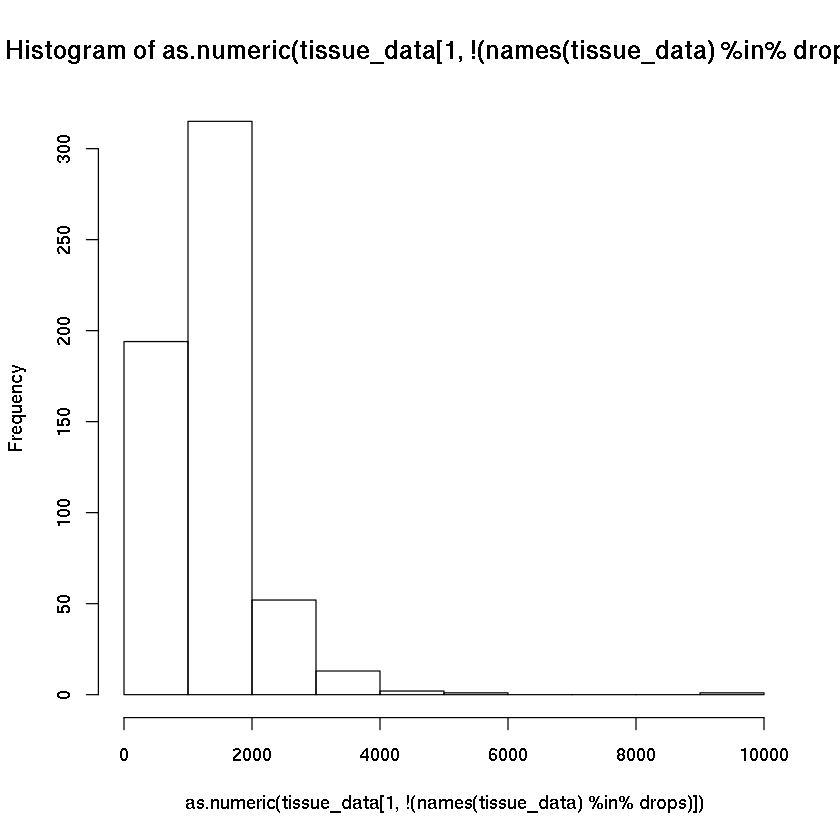

[1] Muscle - Skeletal
54 Levels: Adipose - Subcutaneous ... Whole Blood


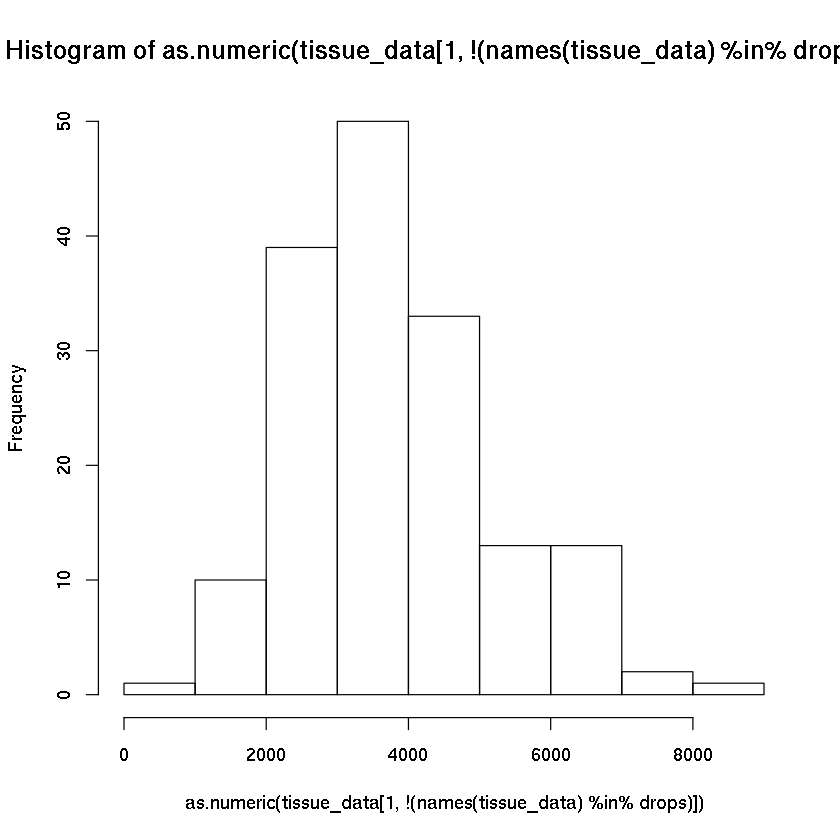

[1] Nerve - Tibial
54 Levels: Adipose - Subcutaneous ... Whole Blood


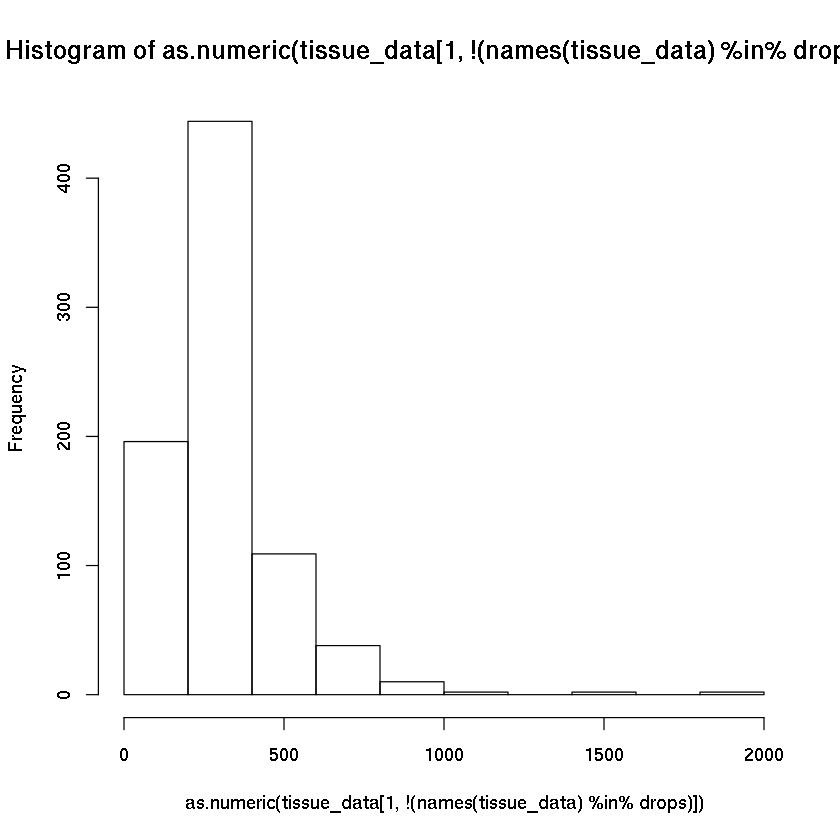

[1] Ovary
54 Levels: Adipose - Subcutaneous ... Whole Blood


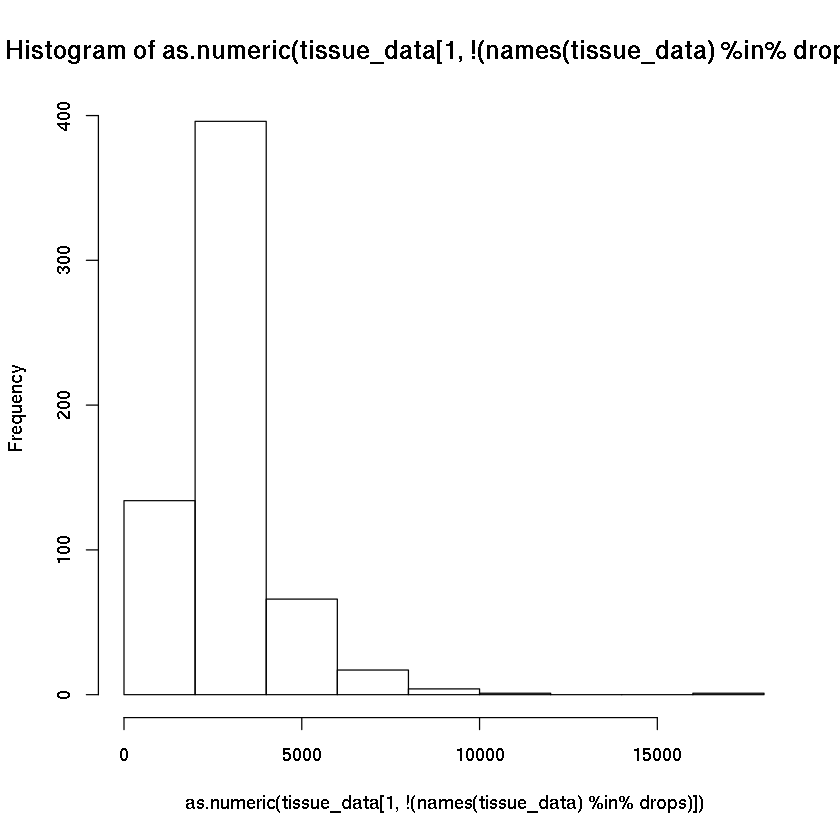

[1] Pancreas
54 Levels: Adipose - Subcutaneous ... Whole Blood


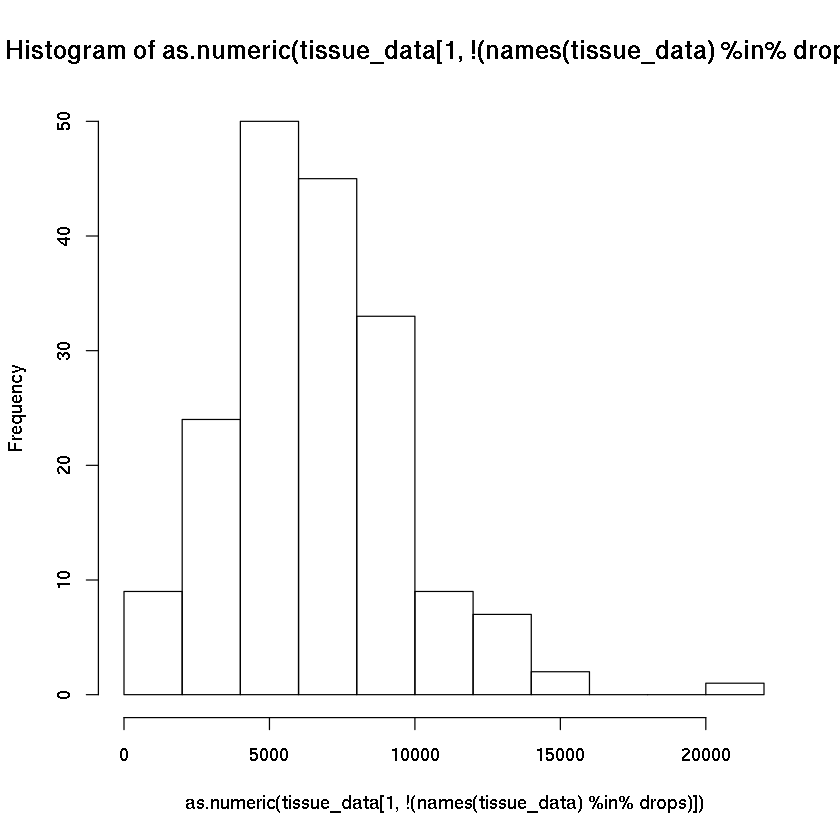

[1] Pituitary
54 Levels: Adipose - Subcutaneous ... Whole Blood


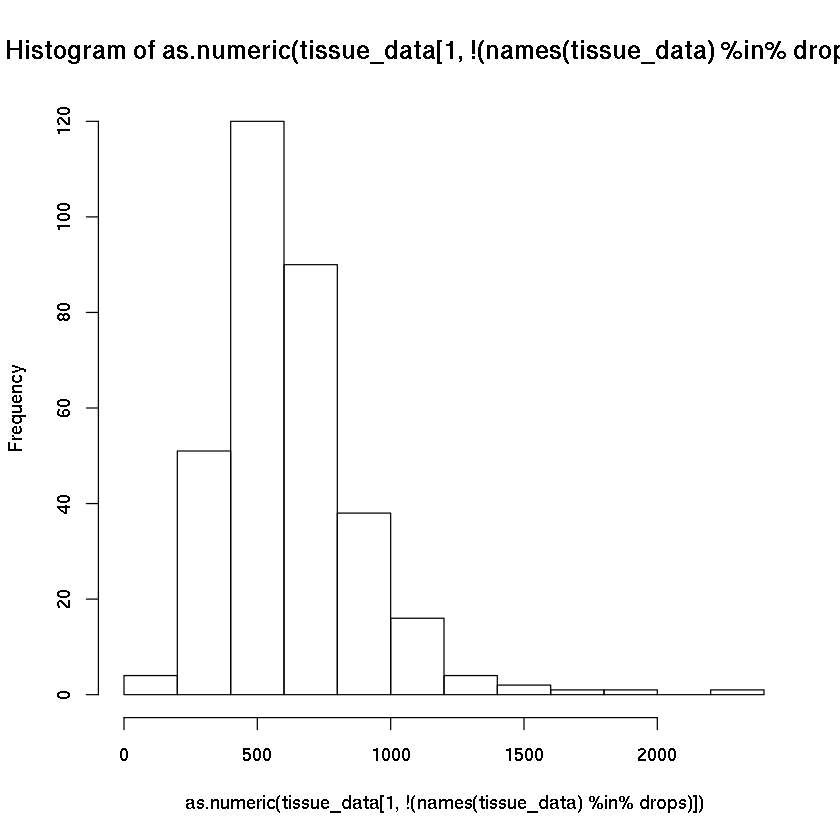

[1] Prostate
54 Levels: Adipose - Subcutaneous ... Whole Blood


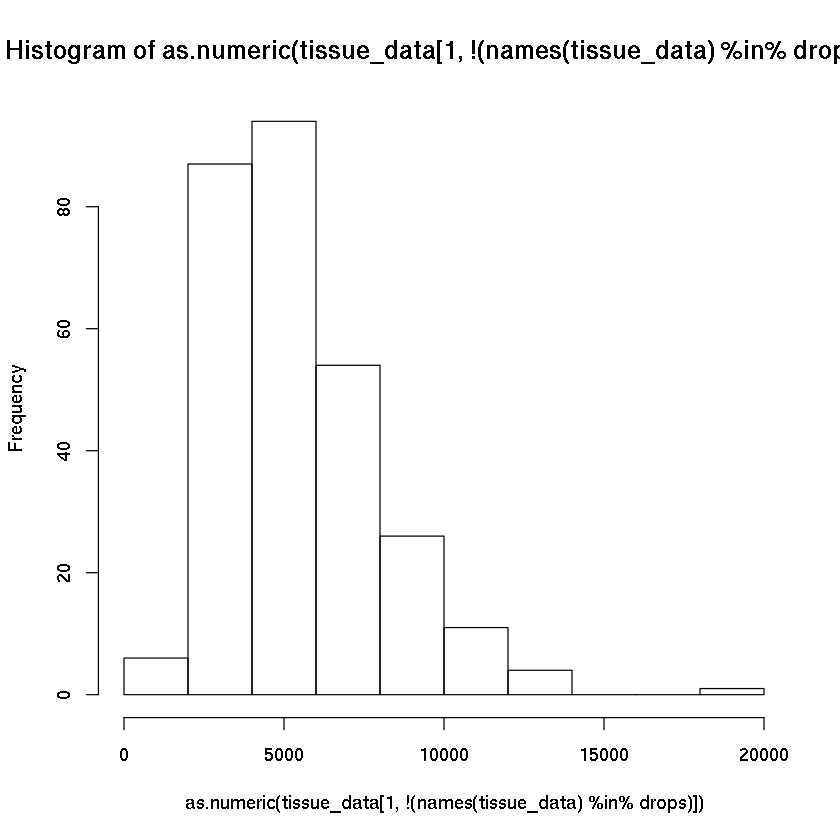

[1] Skin - Not Sun Exposed (Suprapubic)
54 Levels: Adipose - Subcutaneous ... Whole Blood


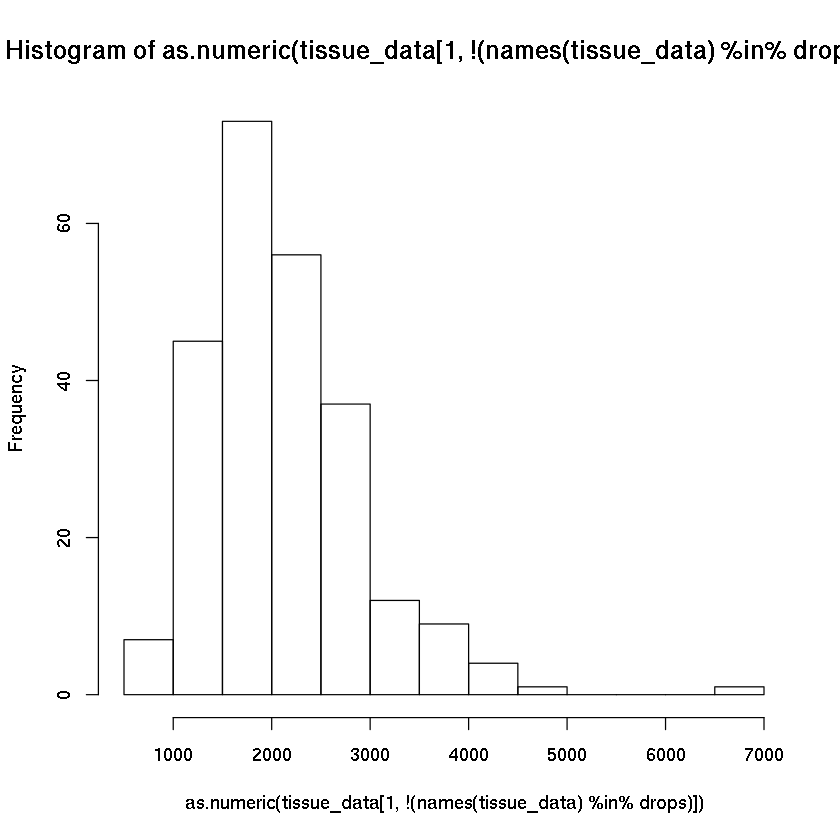

[1] Skin - Sun Exposed (Lower leg)
54 Levels: Adipose - Subcutaneous ... Whole Blood


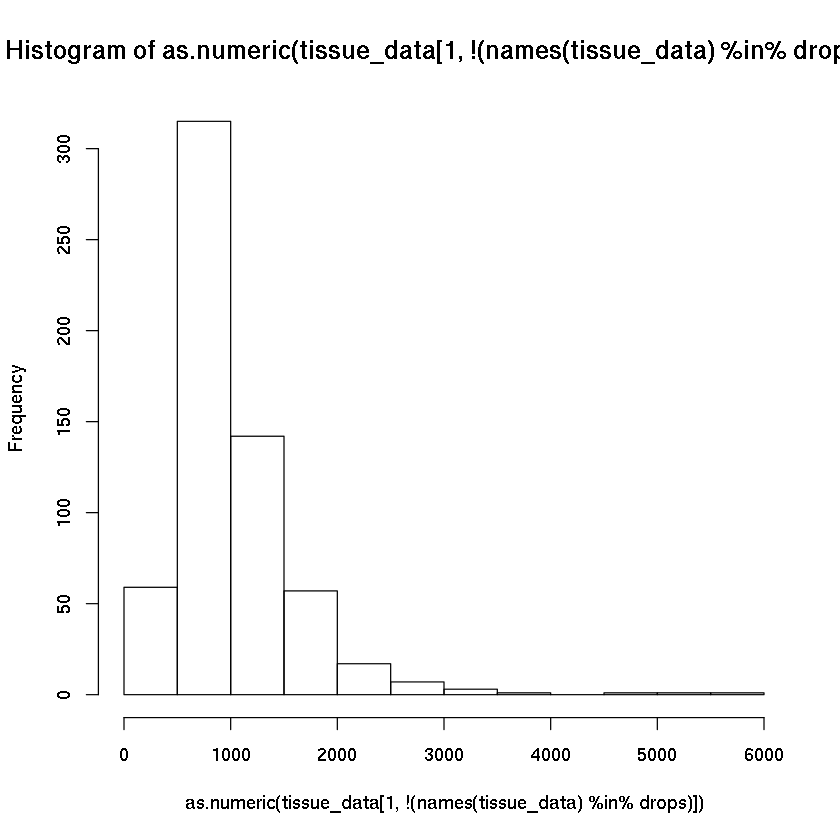

[1] Small Intestine - Terminal Ileum
54 Levels: Adipose - Subcutaneous ... Whole Blood


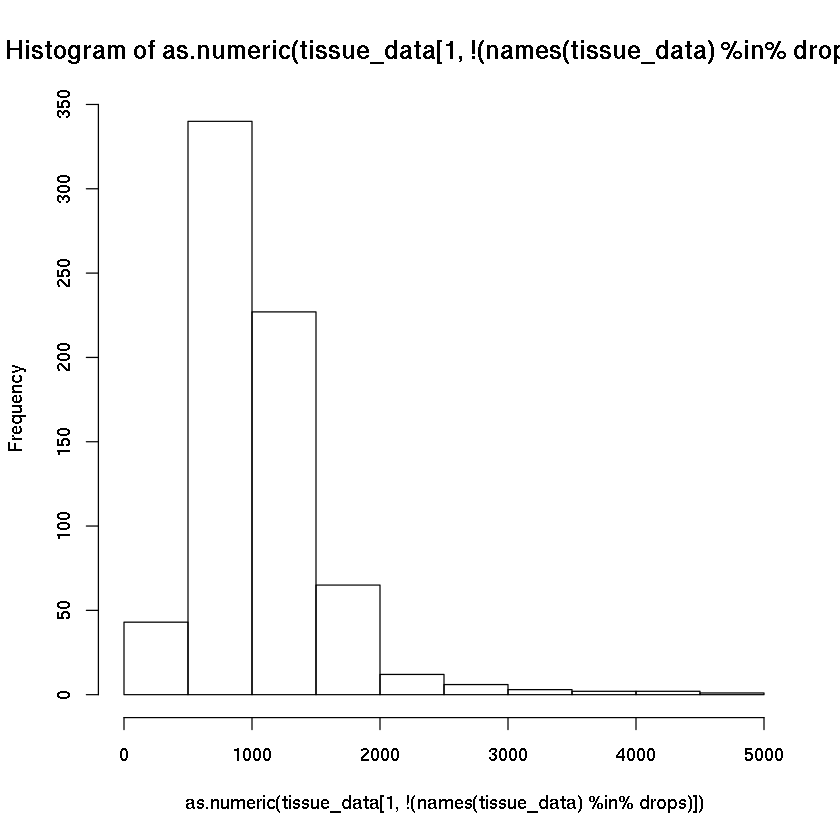

[1] Spleen
54 Levels: Adipose - Subcutaneous ... Whole Blood


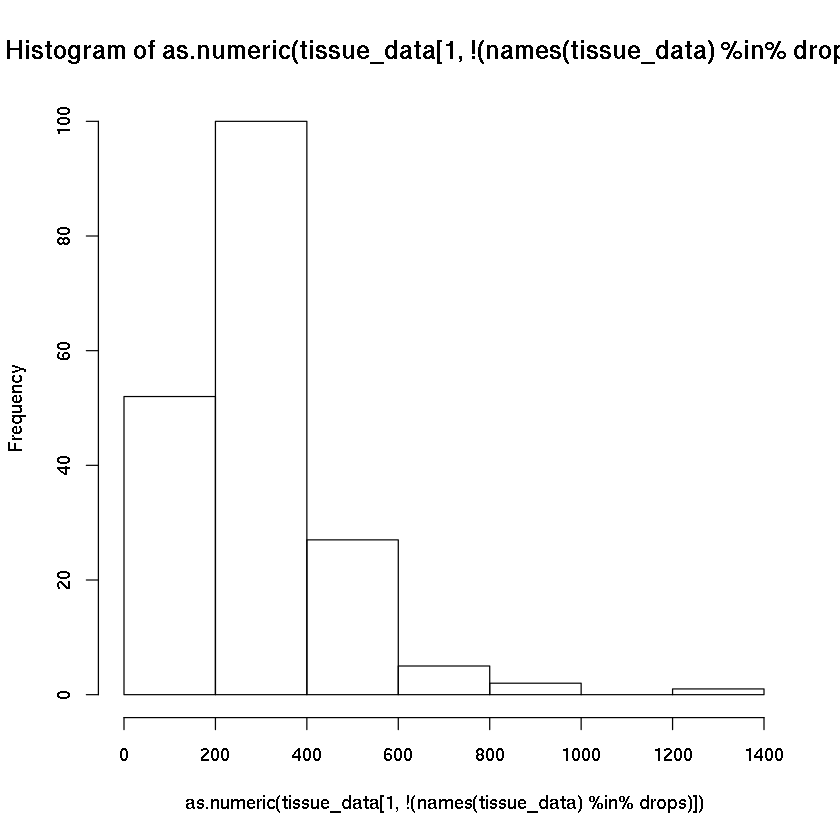

[1] Stomach
54 Levels: Adipose - Subcutaneous ... Whole Blood


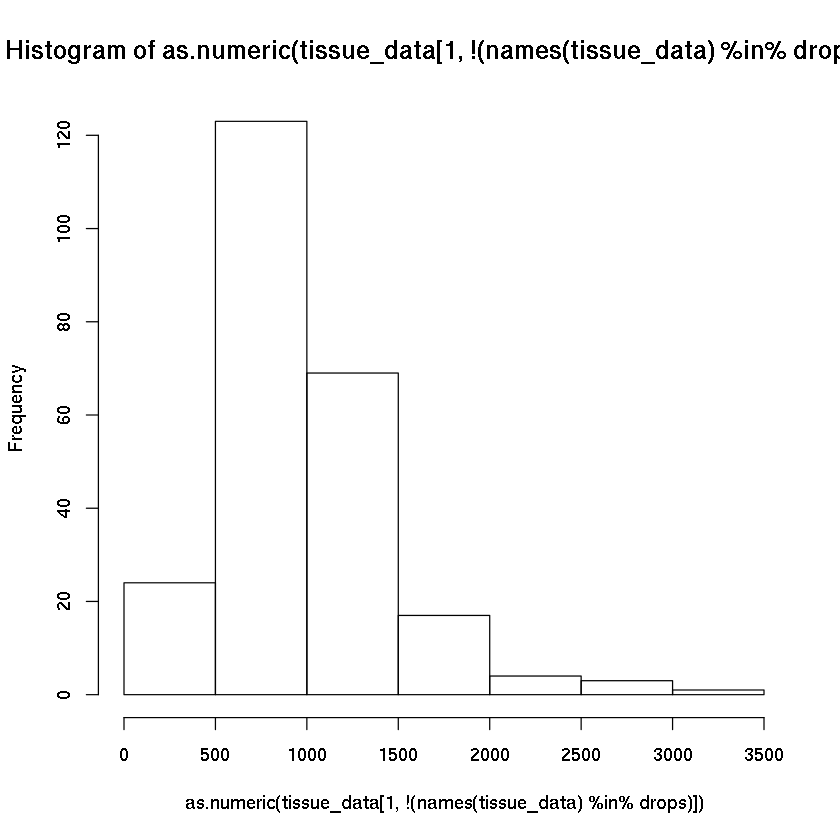

[1] Testis
54 Levels: Adipose - Subcutaneous ... Whole Blood


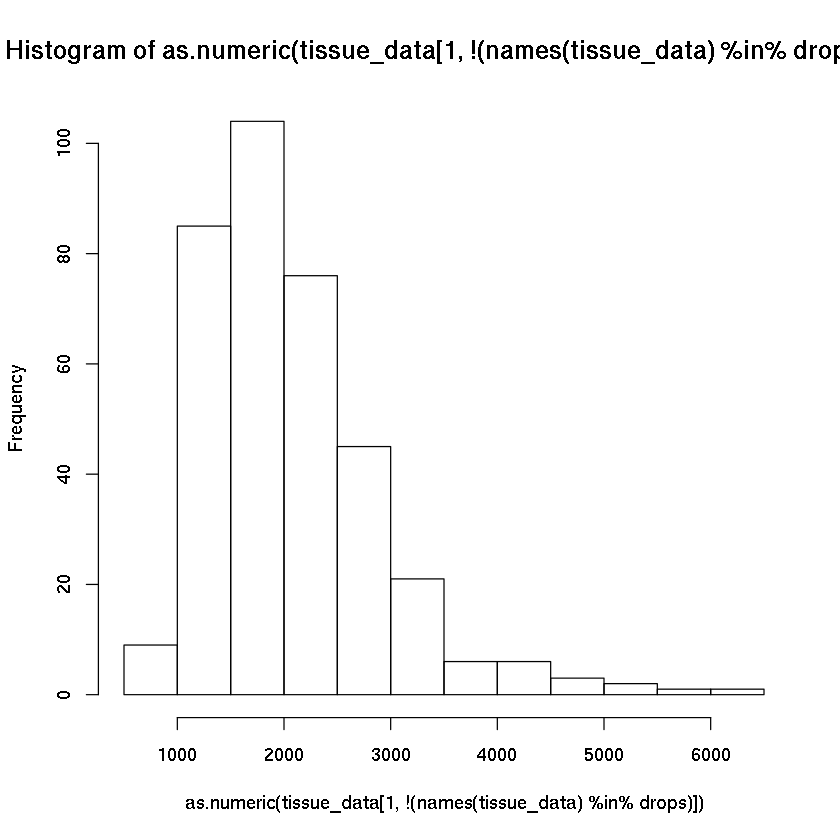

[1] Thyroid
54 Levels: Adipose - Subcutaneous ... Whole Blood


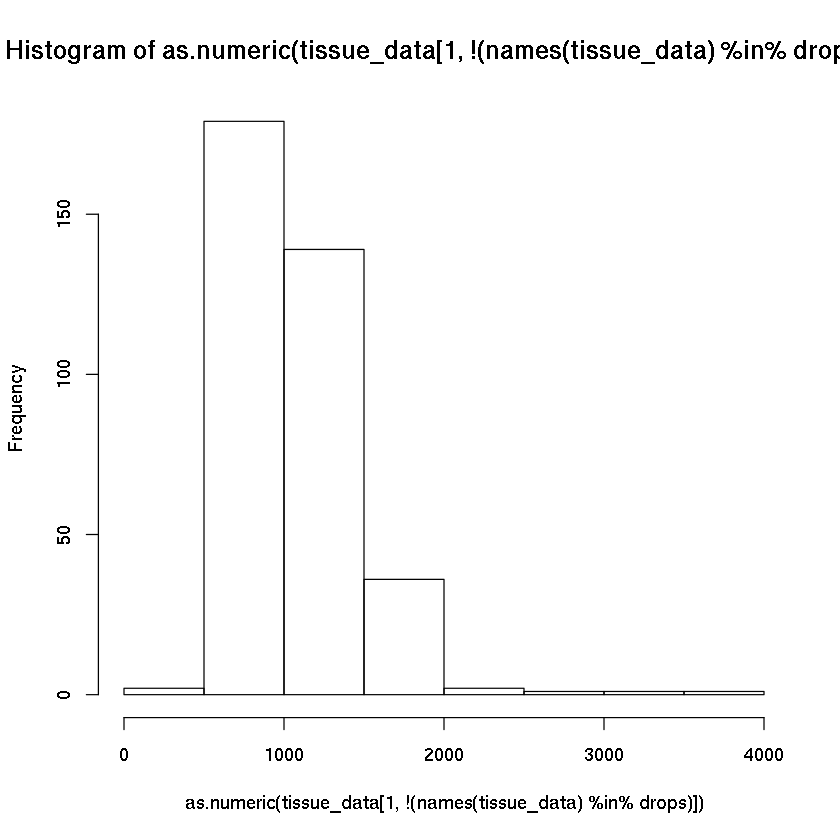

[1] Uterus
54 Levels: Adipose - Subcutaneous ... Whole Blood


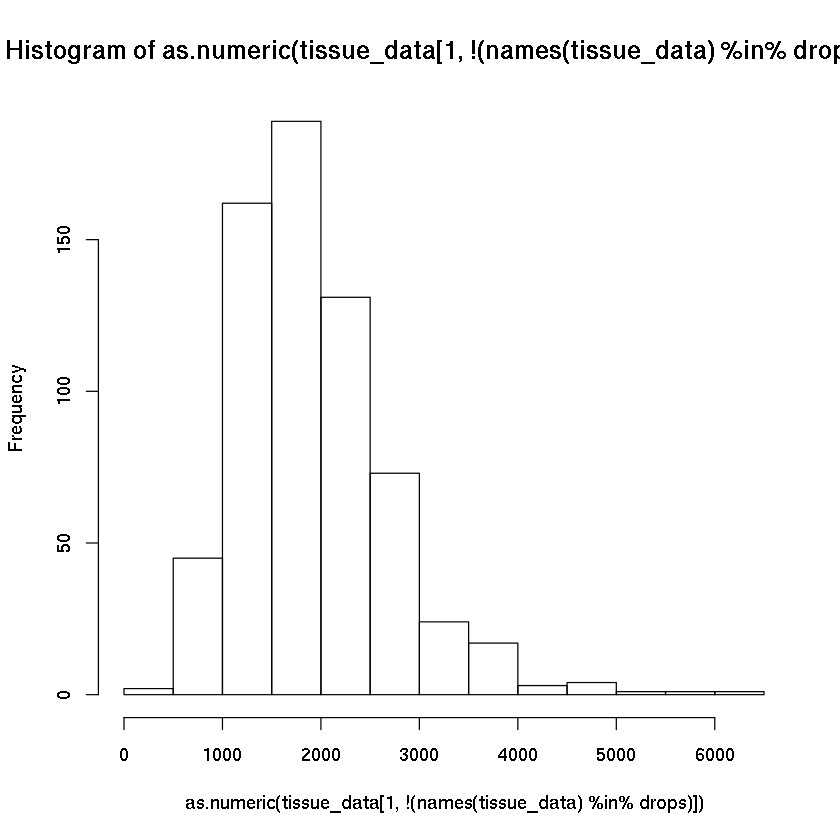

[1] Vagina
54 Levels: Adipose - Subcutaneous ... Whole Blood


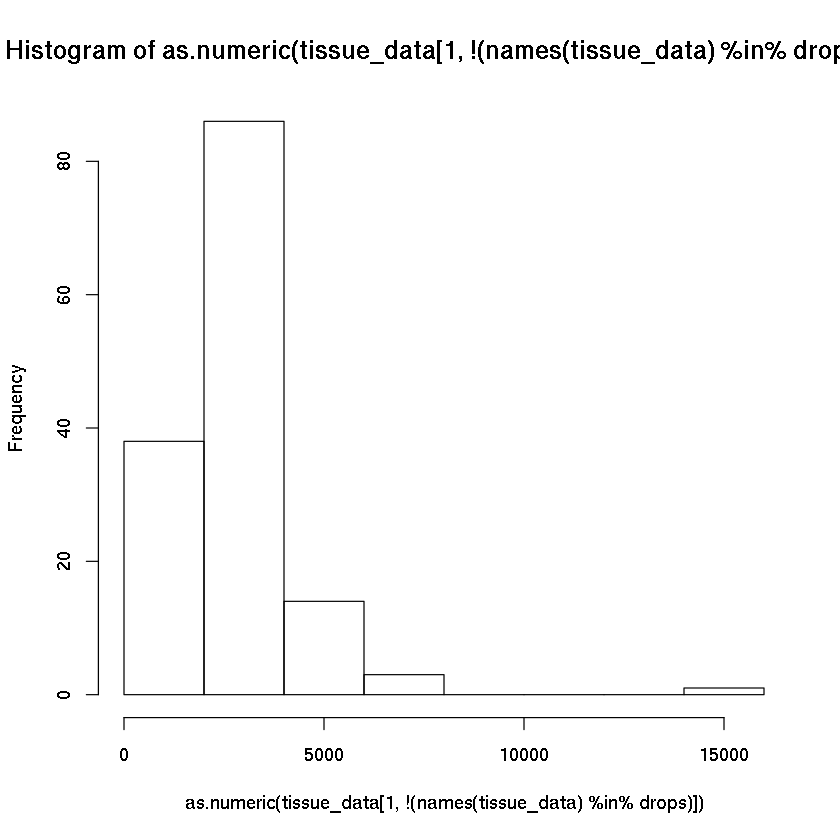

[1] Whole Blood
54 Levels: Adipose - Subcutaneous ... Whole Blood


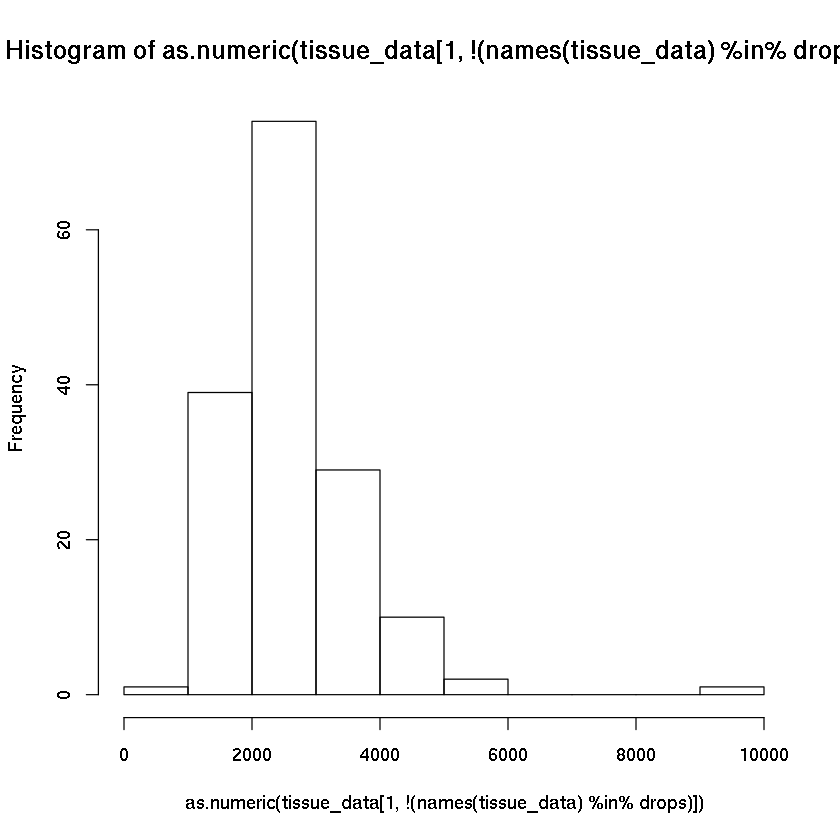

                    Name         Description Adipose - Subcutaneous
1     ENSG00000000003.14              TSPAN6           3.355377e+03
2     ENSG00000000457.13               SCYL3           1.016836e+03
3     ENSG00000000460.16            C1orf112           3.224178e+02
4     ENSG00000000938.12                 FGR           2.976084e+03
5     ENSG00000000971.15                 CFH           1.926989e+04
6     ENSG00000001084.10                GCLC           2.774291e+03
7     ENSG00000001167.14                NFYA           1.736042e+03
8     ENSG00000001460.17               STPG1           4.449578e+02
9     ENSG00000001461.16              NIPAL3           7.712700e+02
10    ENSG00000001497.16               LAS1L           3.494483e+03
11     ENSG00000001561.6               ENPP4           2.305024e+03
12    ENSG00000001617.11              SEMA3F           4.177647e+03
13     ENSG00000001629.9              ANKIB1           3.398567e+03
14    ENSG00000001631.15               KRIT1    

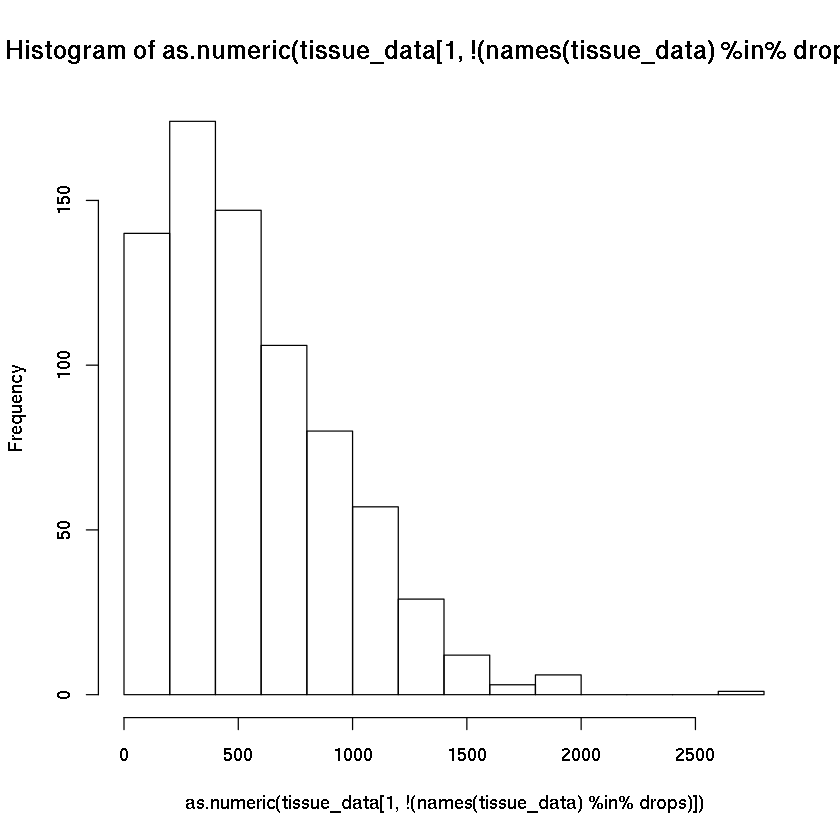

In [8]:
# read tissue abbreviation file 
tissue_abbreviation_df<- read.table('/secure/common/group/data/GTEx/V8/V8/sample_annotations/tissue_abbreviations.txt', header=TRUE, sep='\t')

print(tissue_abbreviation_df)

#dataframe for tissue means 
mean_readcts<- data.frame(Name= character(),Description=character(), stringsAsFactors = FALSE) 


#for loop through all tissues 
for(row in 1:nrow(tissue_abbreviation_df)){ 
    tissue_name<- tissue_abbreviation_df[row, "tissue_name"]
    print(tissue_name)
    tissue_file<- tissue_abbreviation_df[row, "file_name"]
    tissue_dir<- paste('/home/nehsan/data/rnaseq/',toString(tissue_file), sep="")
    
    # check if directory exists 
    if(dir.exists(tissue_dir)){
       
        tissue_data<- read.csv(file= paste(tissue_dir,'/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_reads.csv', sep=""), header=TRUE, sep=",")
        #print(dim(tissue_data))
        
        
        drops <- c("Name","Description")
        #print(tissue_data[1 , !(names(tissue_data) %in% drops)])
        #print(as.numeric(tissue_data[1 , !(names(tissue_data) %in% drops)]))
        
        #test PoilogMLE with one row first 
        #est<-poilogMLE(as.numeric(tissue_data[1 , !(names(tissue_data) %in% drops)]))
        
        
        hist(as.numeric(tissue_data[1 , !(names(tissue_data) %in% drops)]))  #histogram for each individual 
        
        # apply mean to each row of tissue data 
        tissueMeans<-rowMeans(tissue_data[,!(names(tissue_data) %in% drops)],  na.rm = TRUE)
        #print(tissueMeans)
        
        
        #calculate probability with estimates 
        #prob<- dpoilog(n=0:15000,mu=est$par[1],sig=est$par[2])
        ### plot density for given parameters 
        #barplot(dpoilog(n=0:15000,mu=est$par[1],sig=est$par[2]),names.arg=0:15000)

        #print(sum(dpoilog(n=0:15000,mu=est$par[1],sig=est$par[2]))) #should add up to one
        #print(sum(dpoilog(n=0:100,mu=est$par[1],sig=est$par[2]))) # should be low, 
        
        # Fit Poison log normal model and calculate probability of expression to every gene 
        
        #exp<- calc_p_expression_fix_e0(tissue_data[2 , !(names(tissue_data) %in% drops)])
        #p_exp_t<- apply(tissue_data[, !(names(tissue_data) %in% drops)], 1, calc_p_expression_fix_e0)
        #add gene names to exp2 data
        #print(p_exp_t)
        #print("exp$p_exp_t")
        #print(exp$p_exp_t) # this is probability of expression, you should save in a column and store in csv for python to read 
        
        
        #populate dataframe with tissue name and p_expression , (genes as rows), column is tissue 
        dftissueMeans<-data.frame(tissueMeans)
        #print('dftissue')
        #print(dftissue)
        names(dftissueMeans) <- tissue_name #name column with tissue name 
        df_tissueMeans<- cbind(tissue_data[, names(tissue_data) %in% drops], dftissueMeans)  #genes name and description
        
        #print('dfexp')
        #print(dfexp)
        
        mean_readcts<- merge(mean_readcts, df_tissueMeans, all=TRUE) #to do: specify on names and description
        
        #print(p_expression)
        #print('p_expression saved for tissue')
        
        #save dataframe p_expression in csv_file 
        #write.csv(df_p_exp,paste(toString(tissue_file),'_p_expression_poilog.csv', sep=''))
        
        #print(tissue_data[1, names(tissue_data) %in% drops]) #gene name 
    }
    
} 

print(mean_readcts)
write.csv(mean_readcts, 'GTEx_mean_readcounts.csv')

 

[1] 2371.935


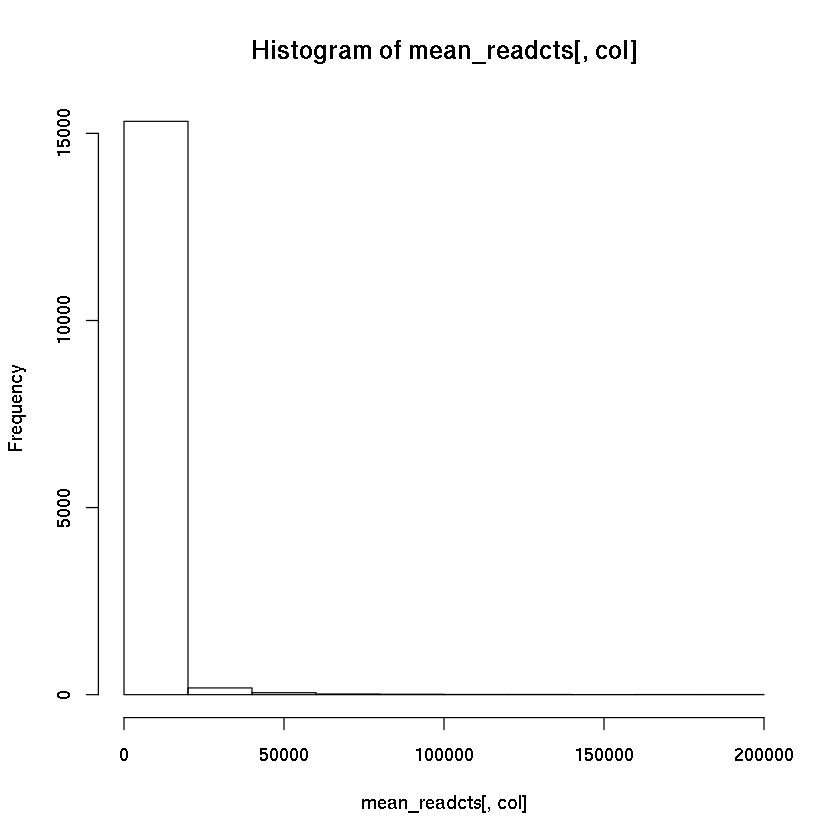

[1] 2109.296


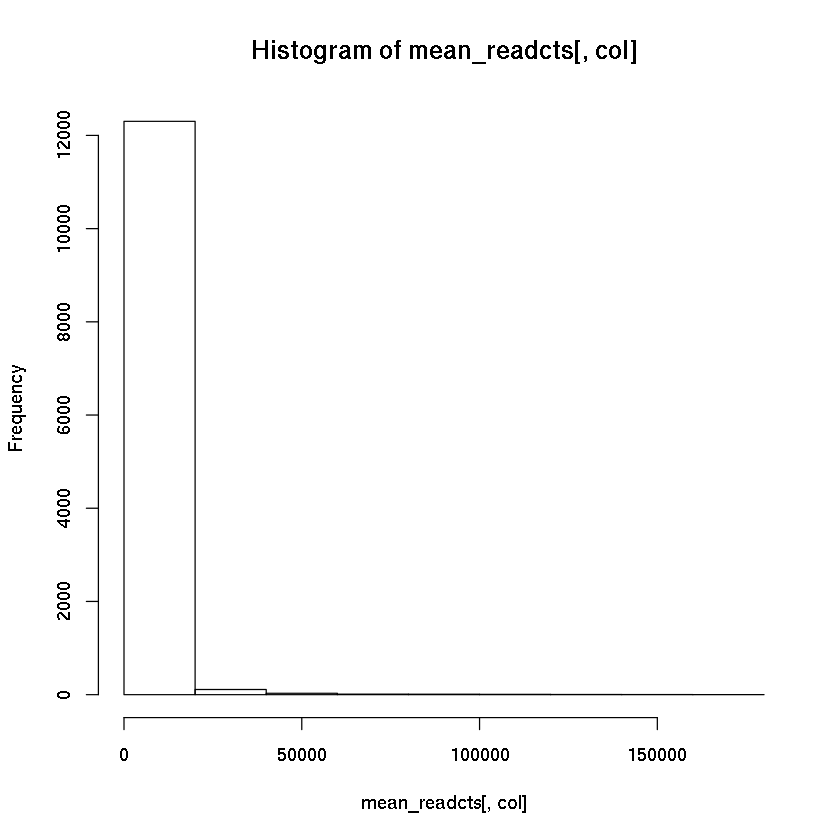

[1] 1968.203


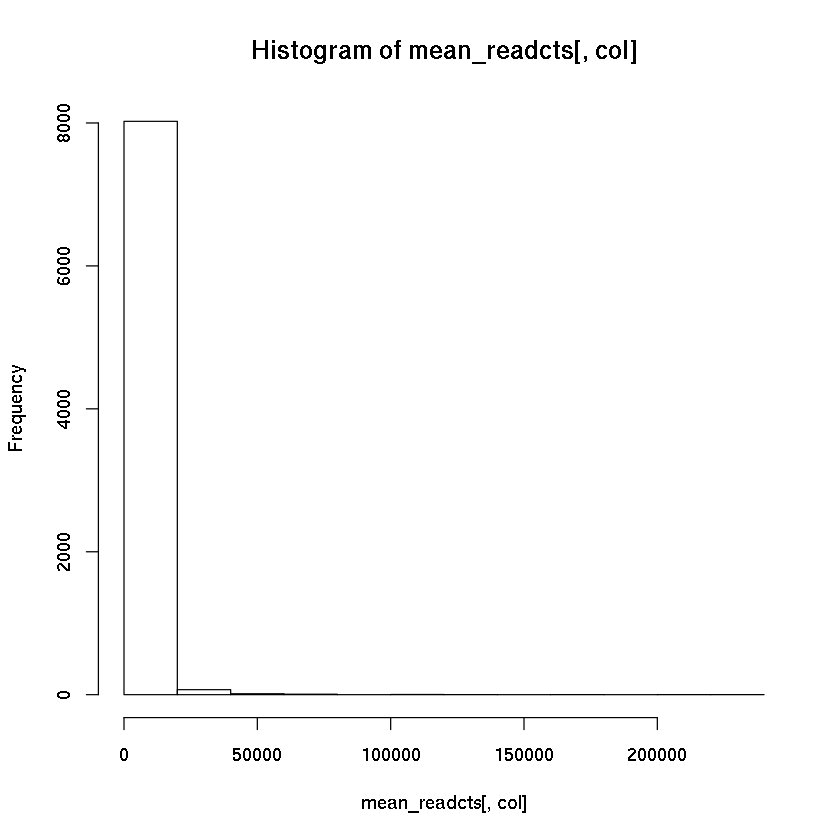

[1] 2600.844


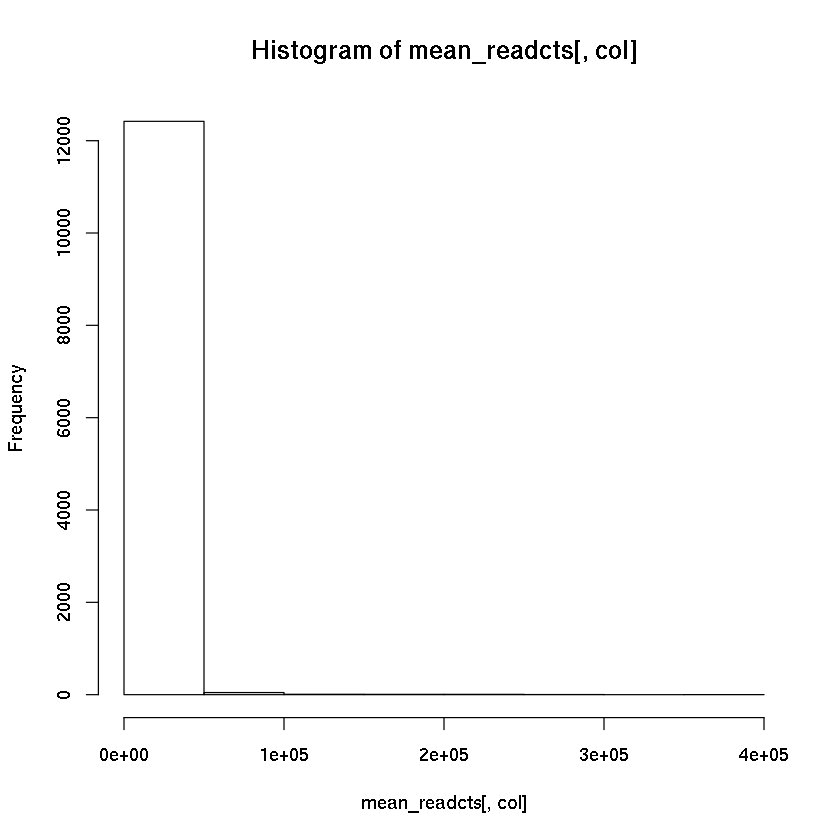

[1] 1953.895


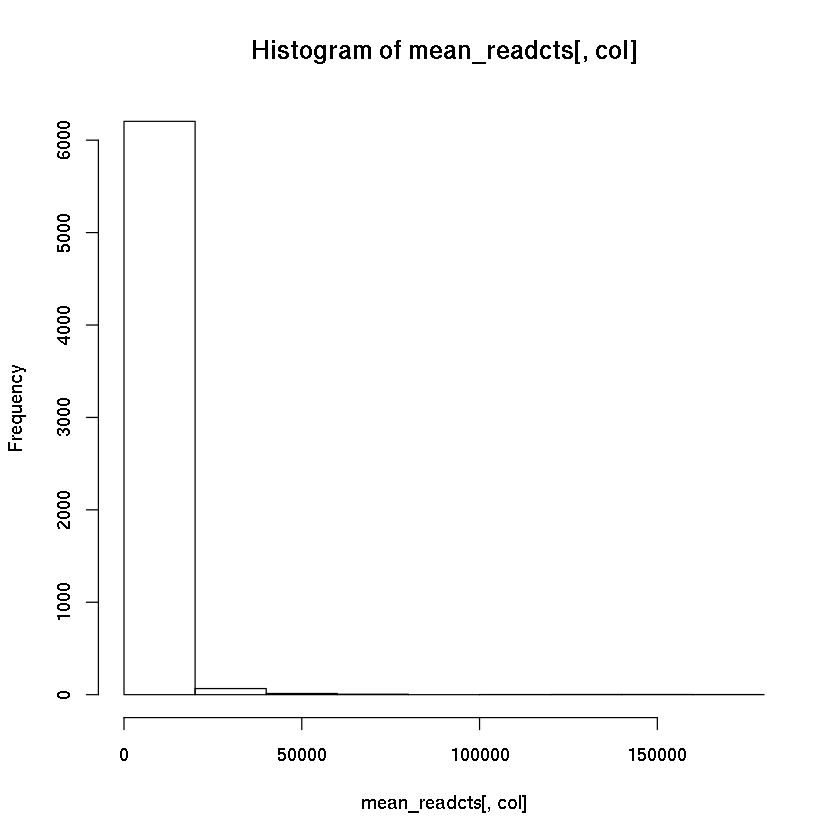

[1] 2746.041


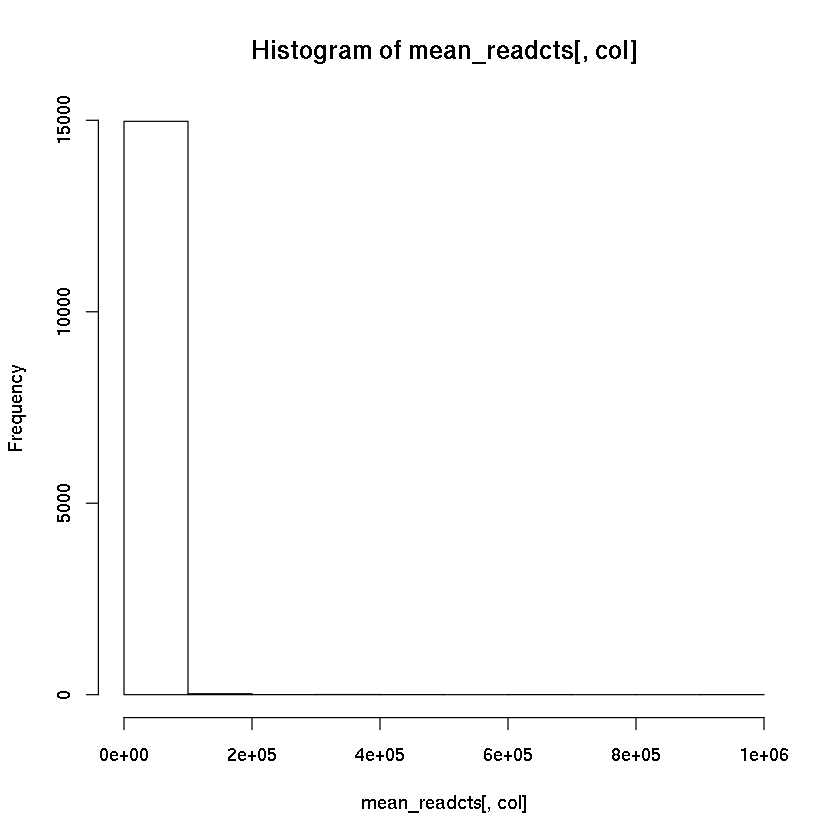

[1] 1174.166


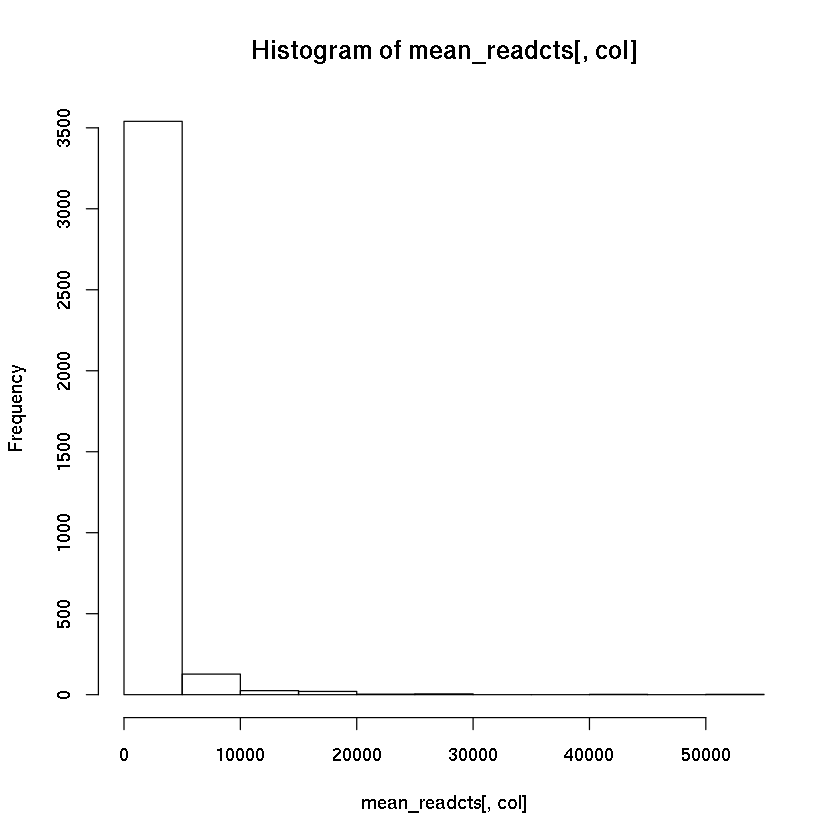

[1] 1510.081


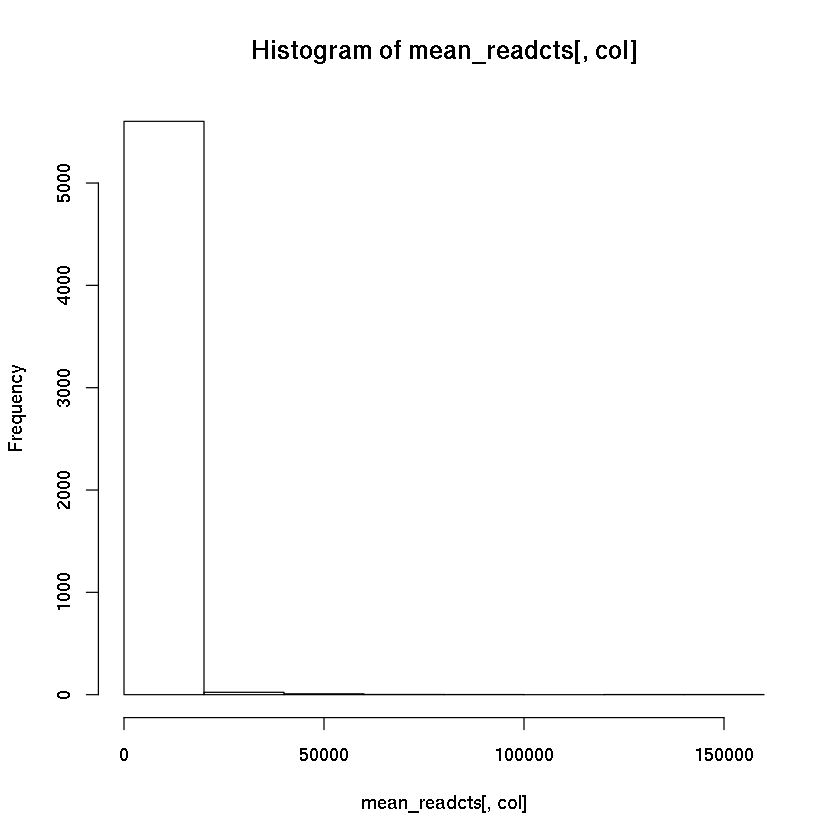

[1] 1505.772


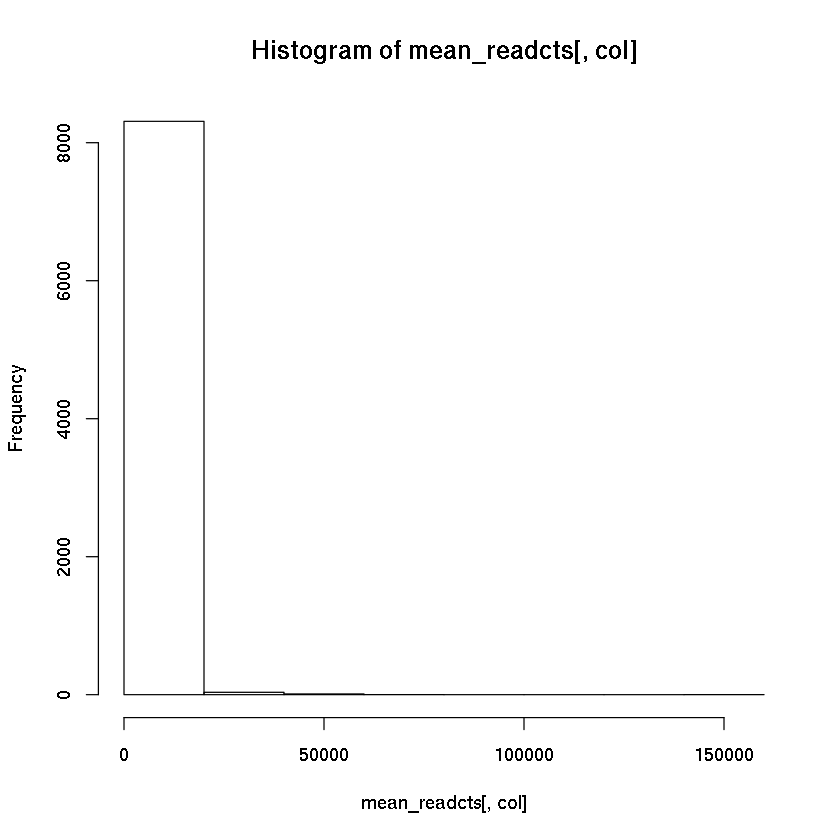

[1] 2404.935


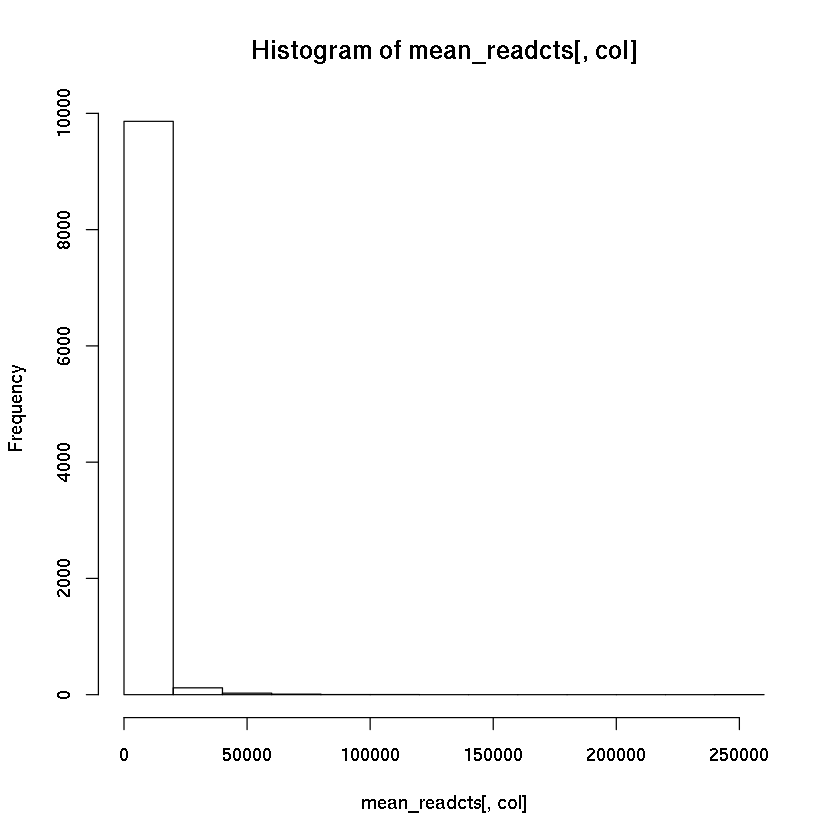

[1] 2130.107


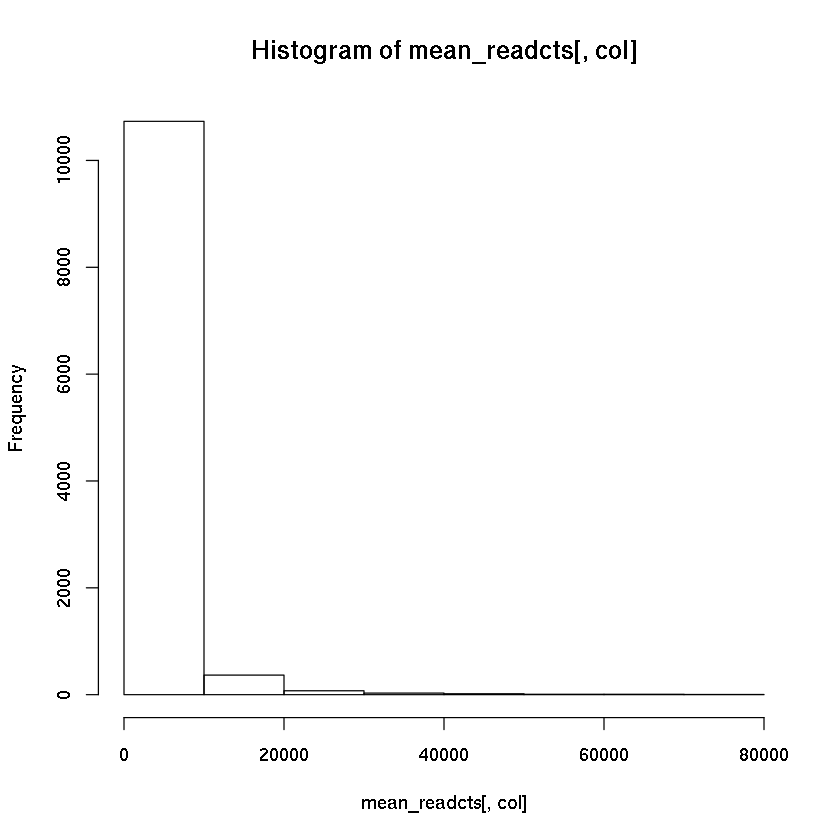

[1] 1753.253


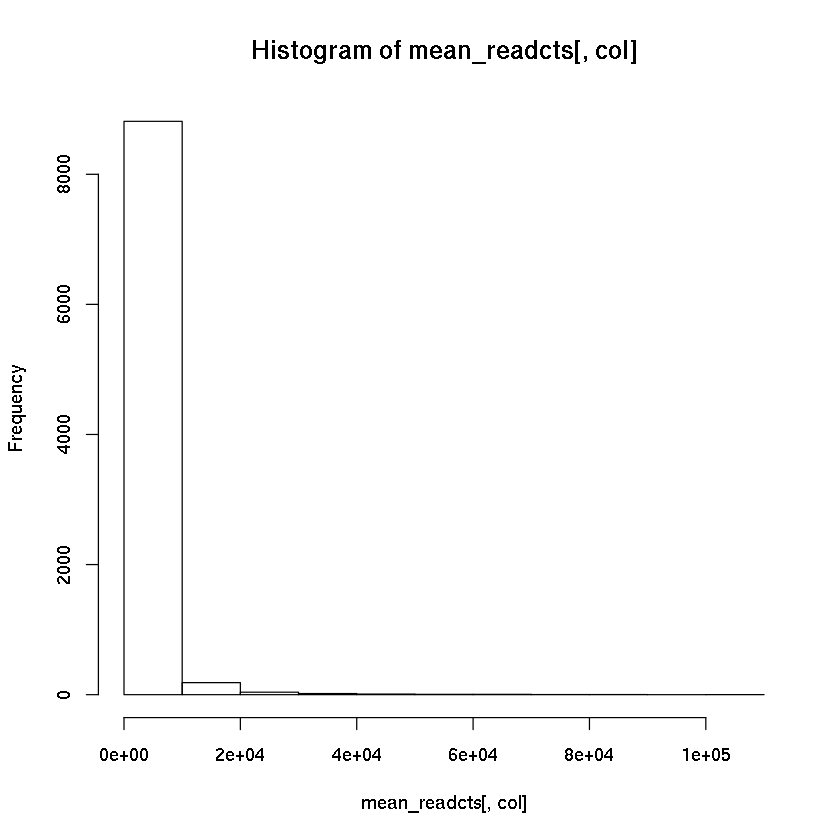

[1] 1788.661


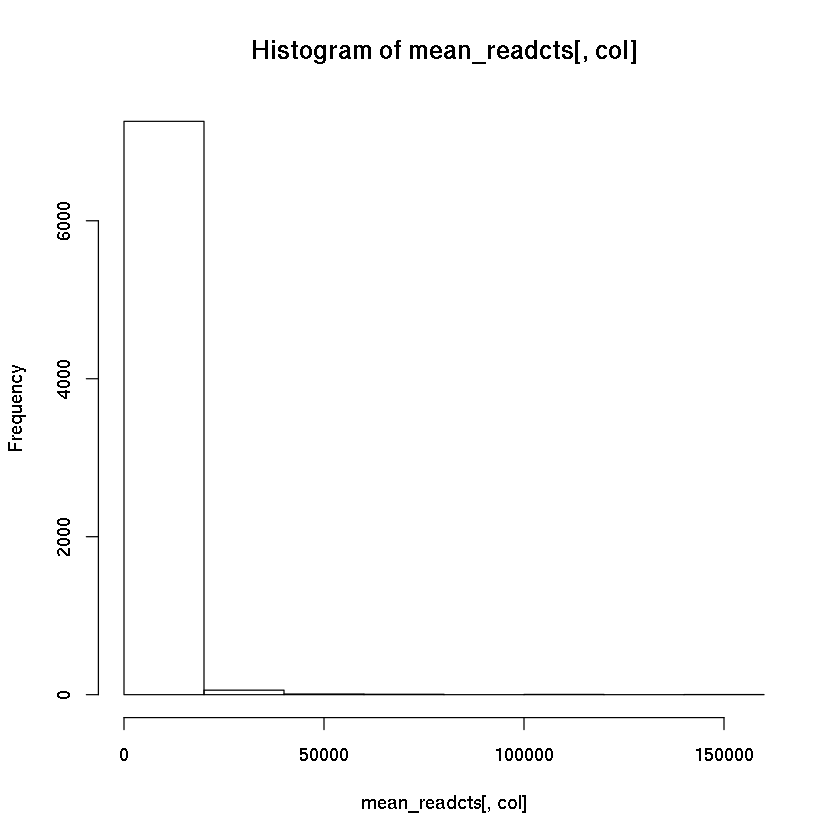

[1] 1391.916


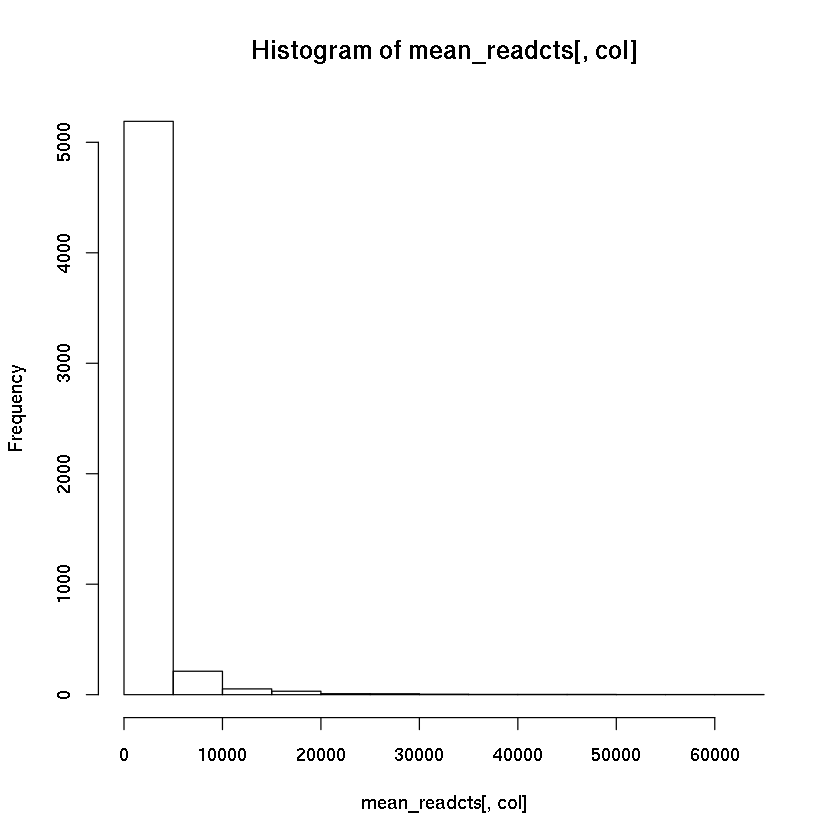

[1] 1464.799


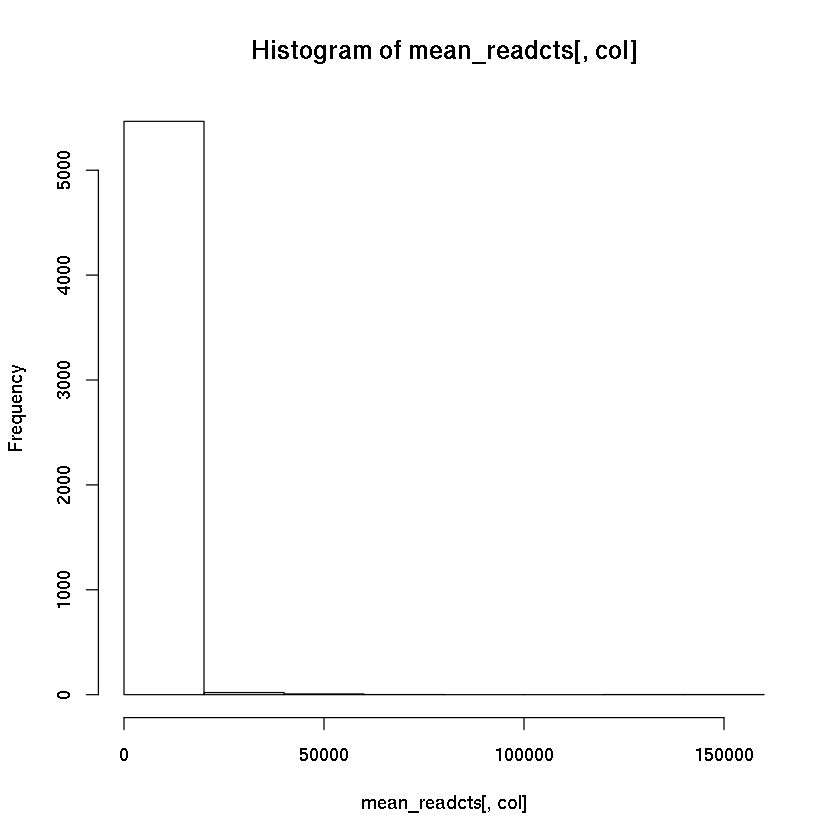

[1] 1655.329


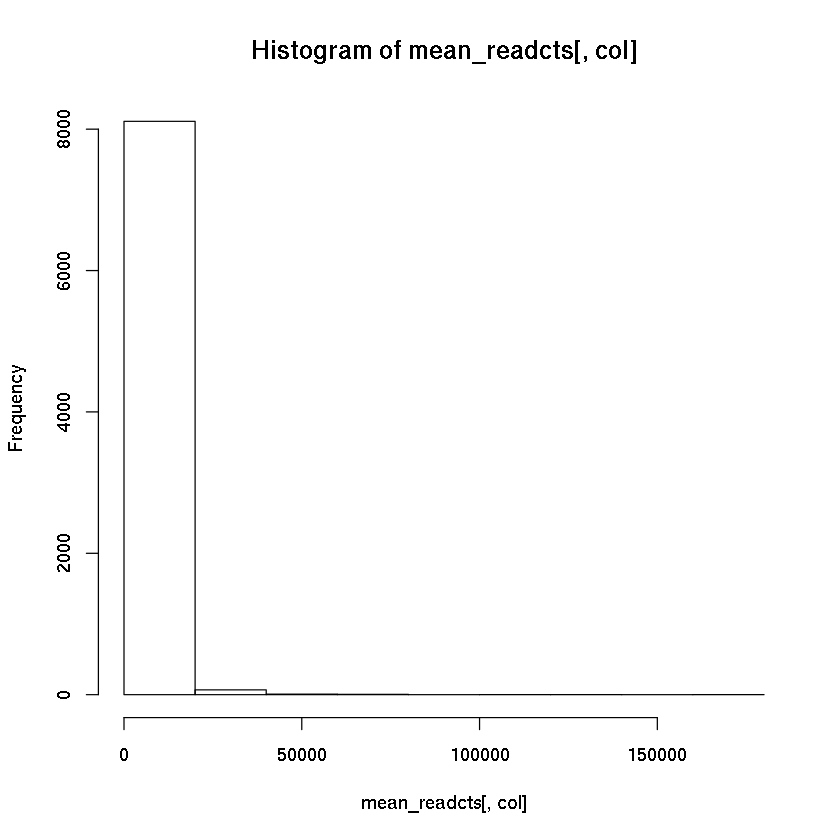

[1] 1589.271


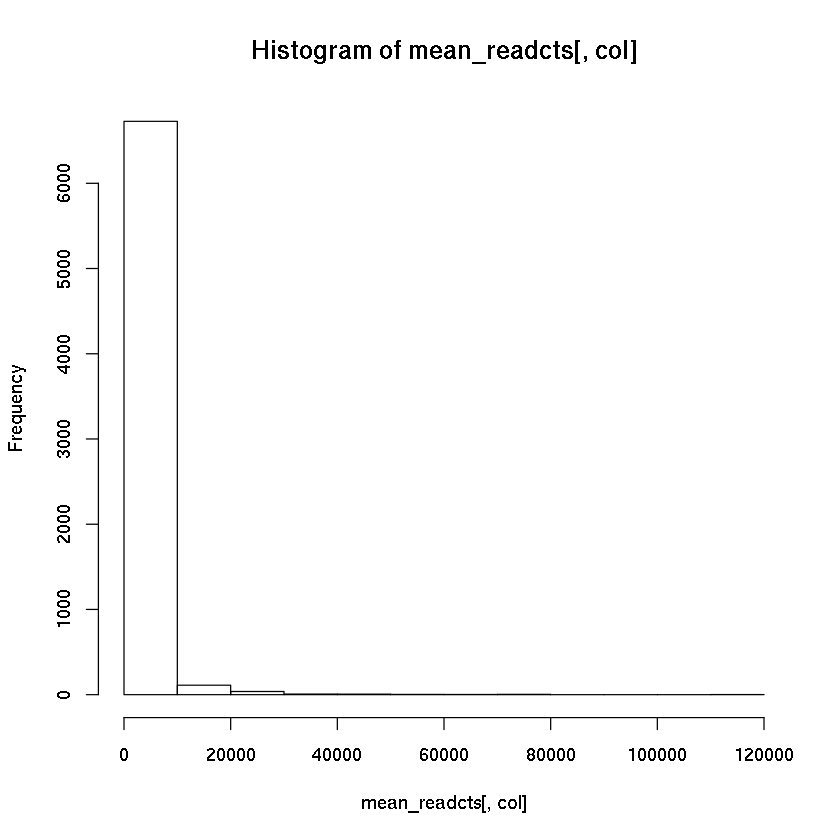

[1] 1636.455


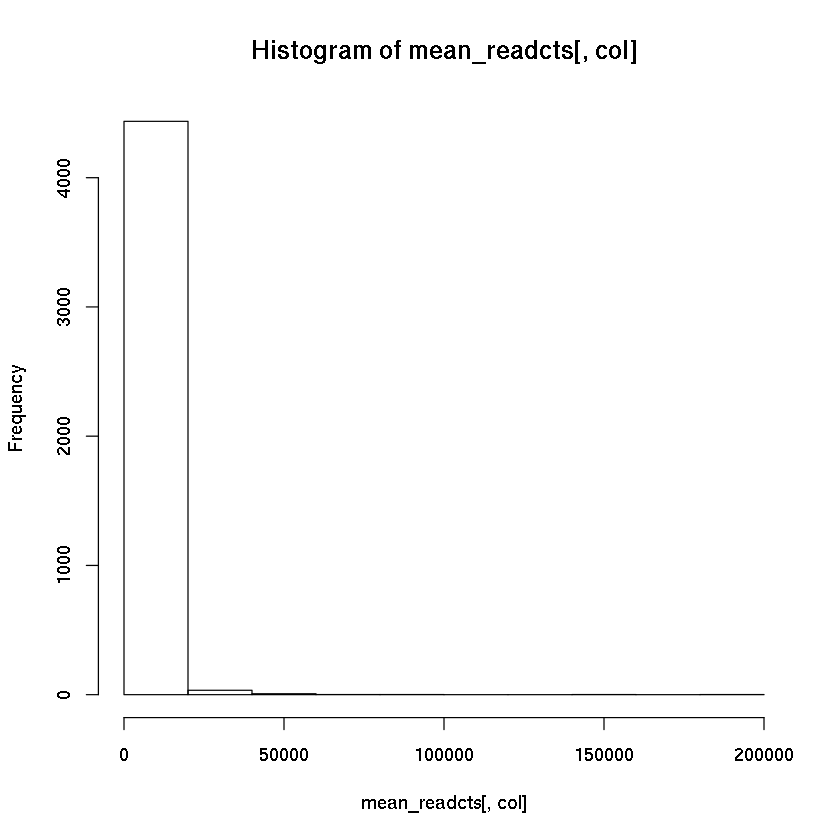

[1] 1353.316


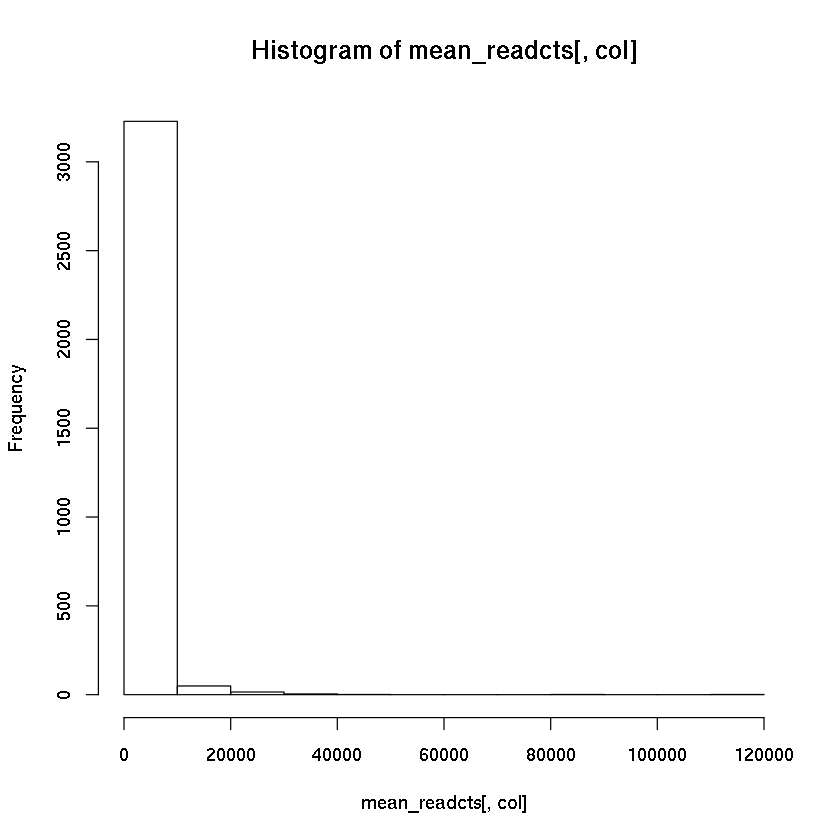

[1] 2014.515


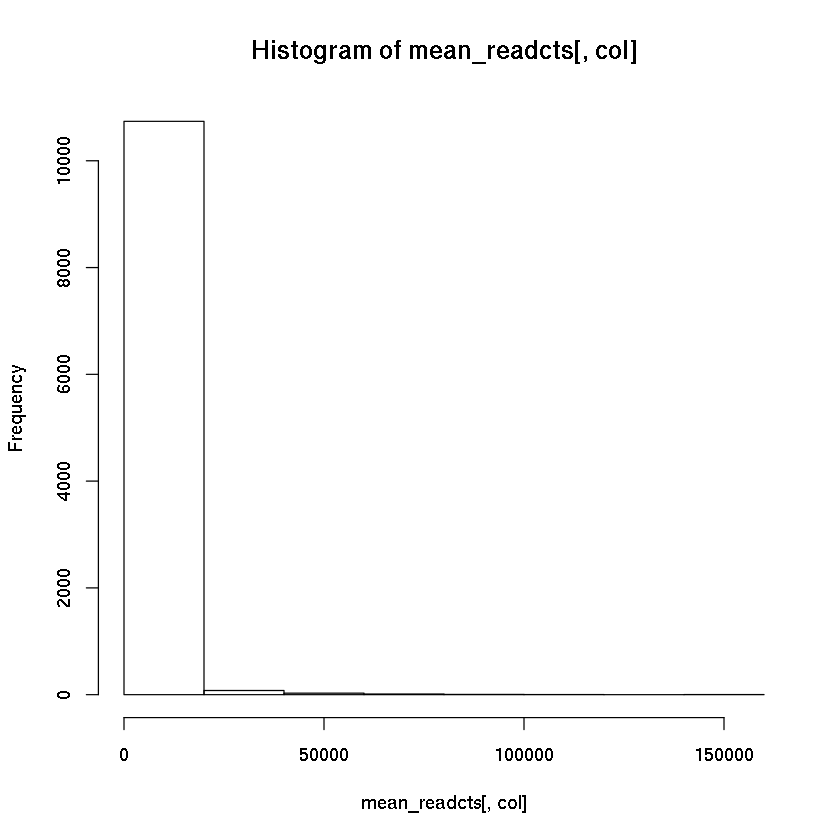

[1] 2962.19


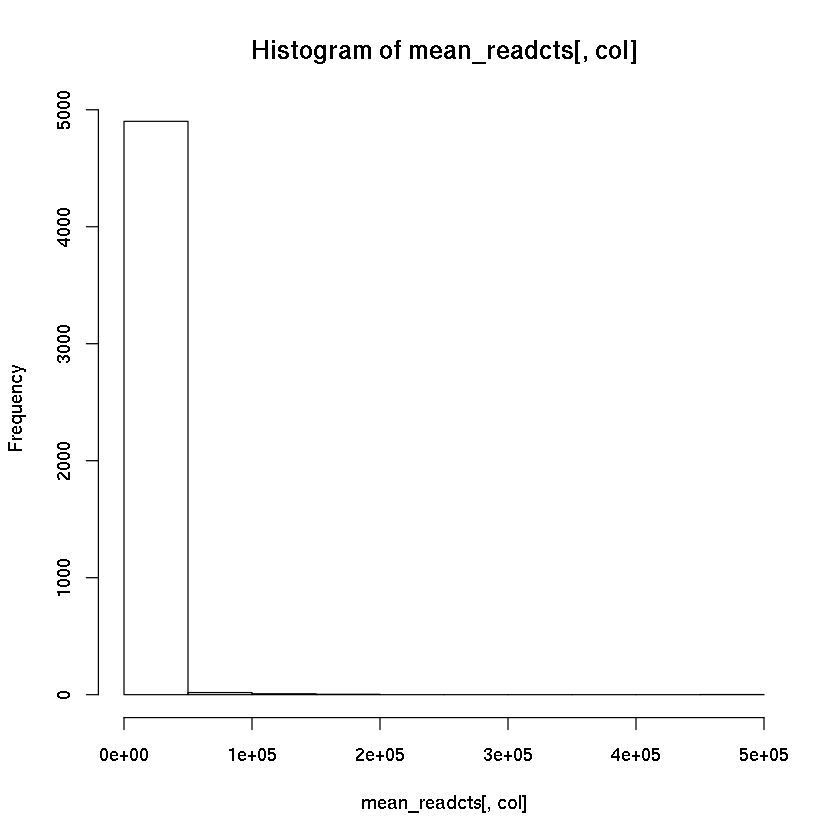

[1] 3206.791


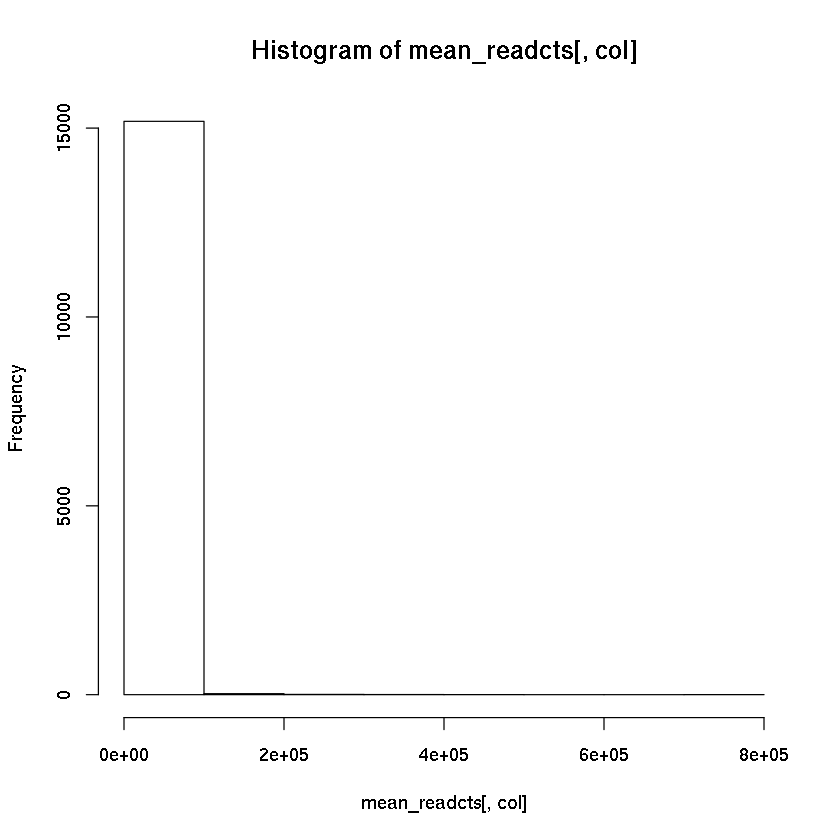

[1] 2136.707


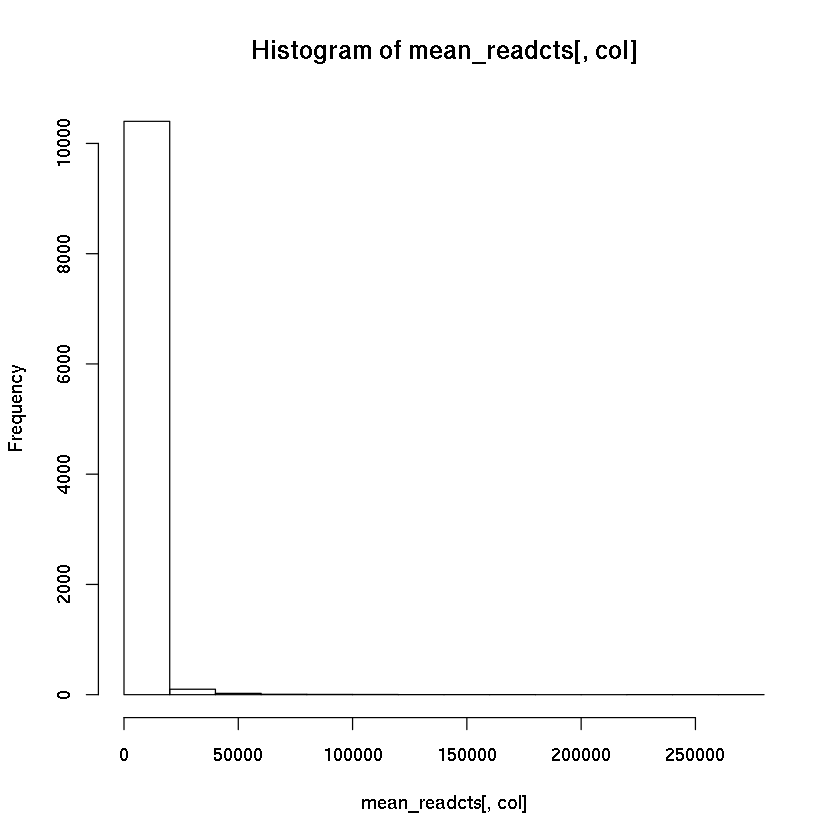

[1] 1981.565


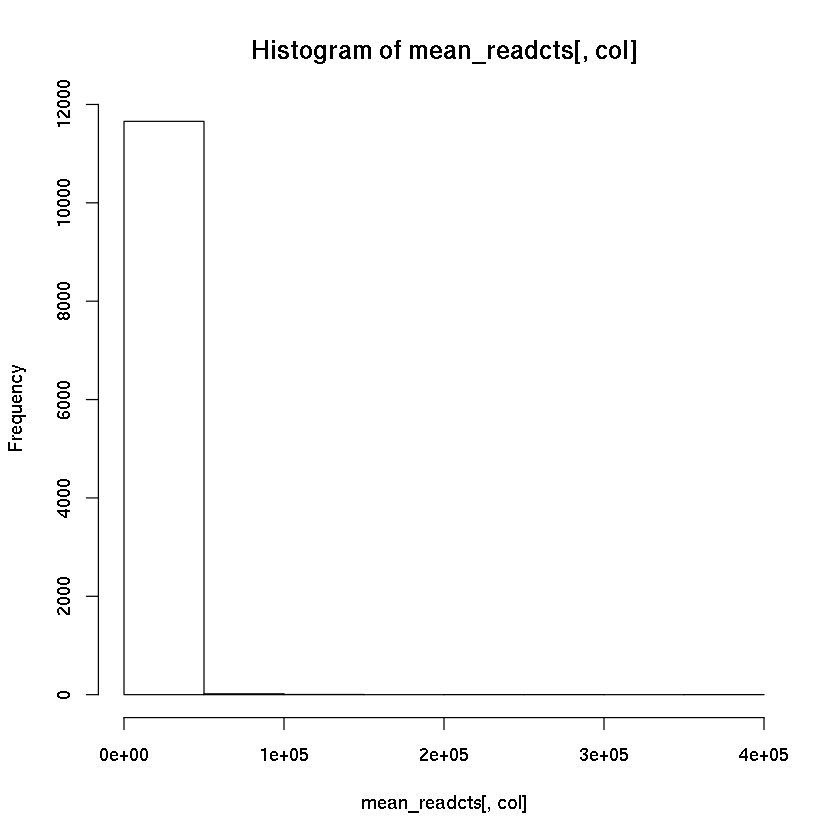

[1] 2135.443


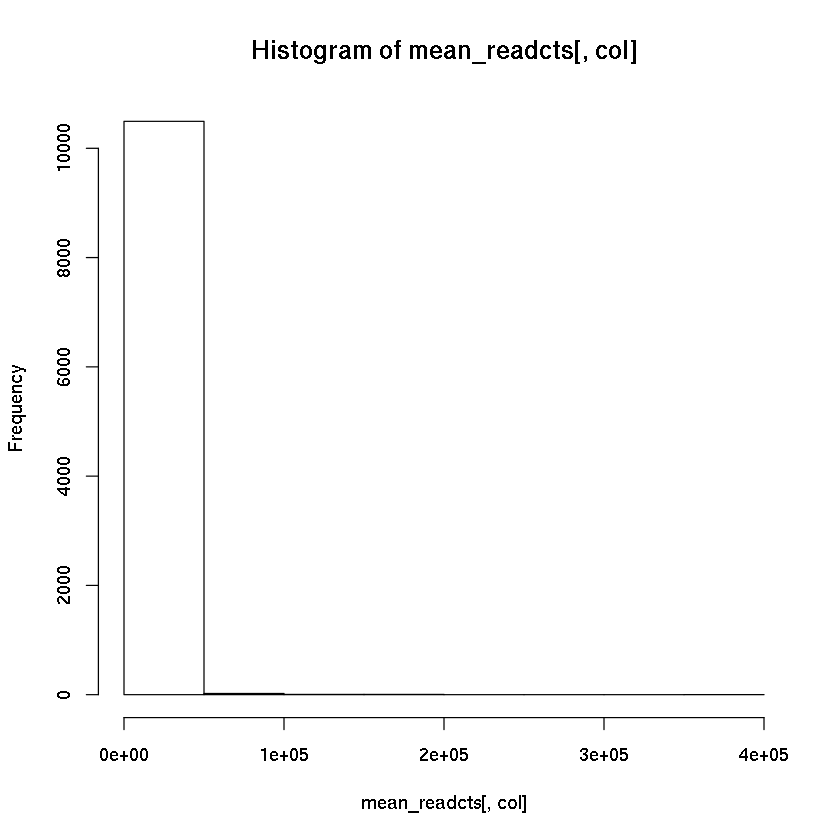

[1] 2534.646


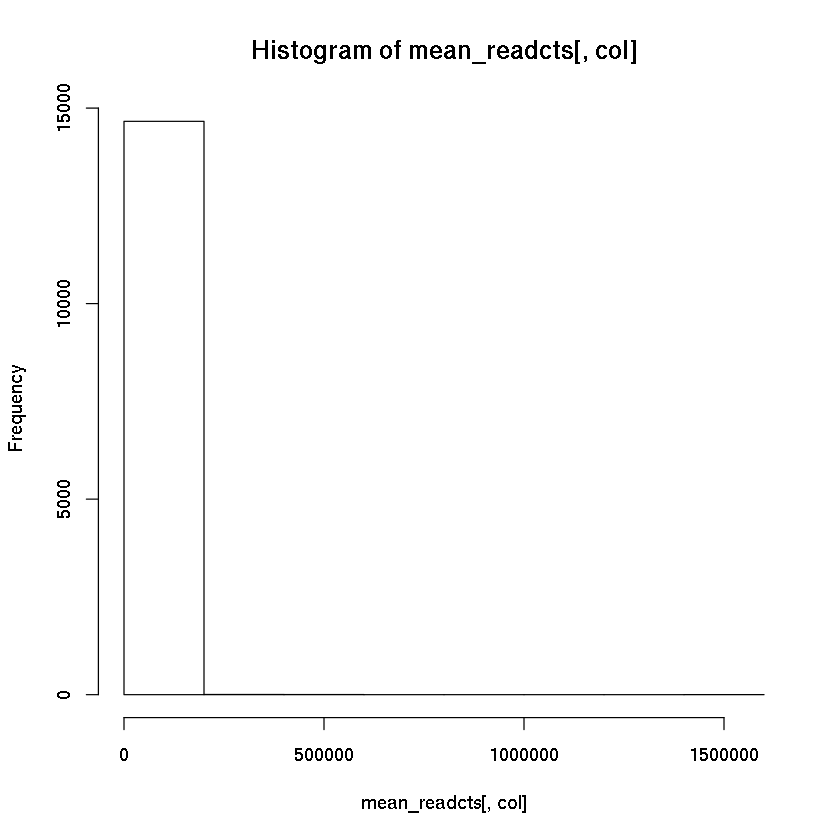

[1] 2194.187


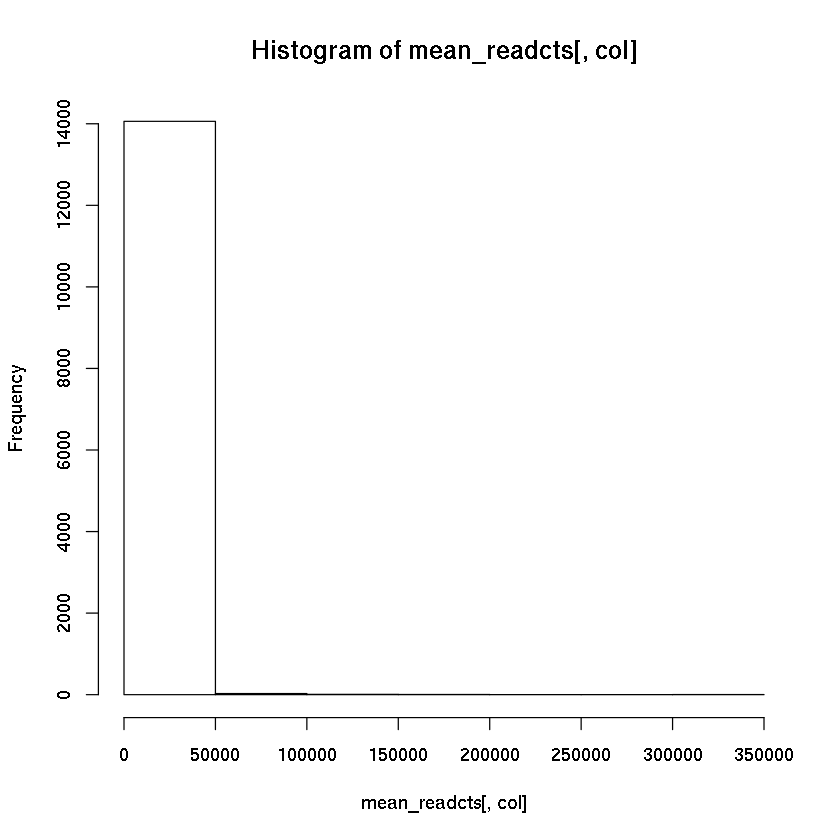

[1] 2041.029


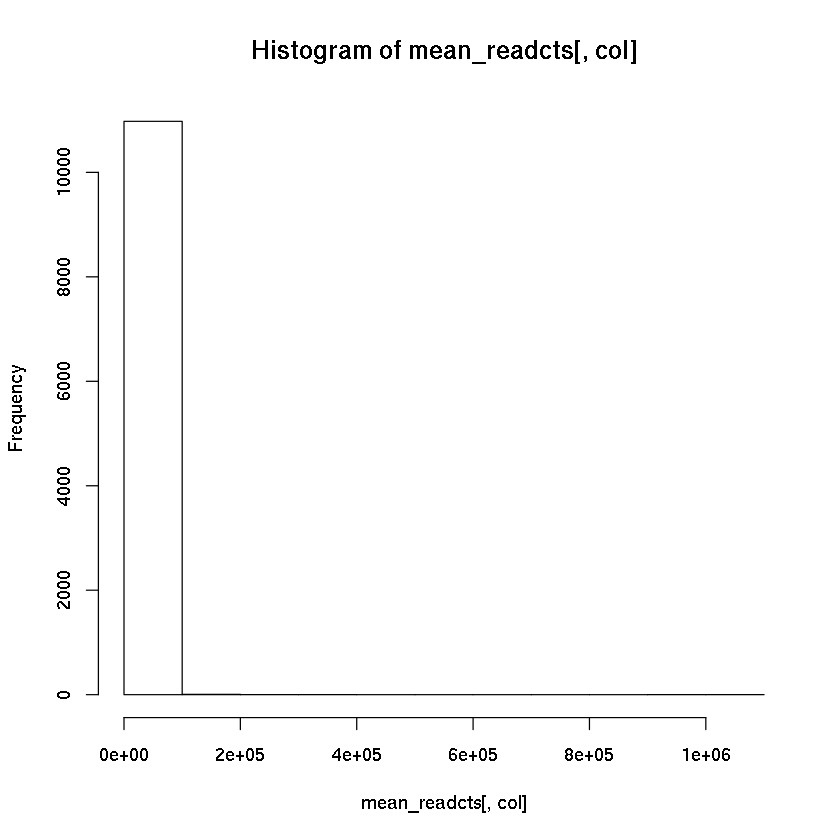

[1] 1935.187


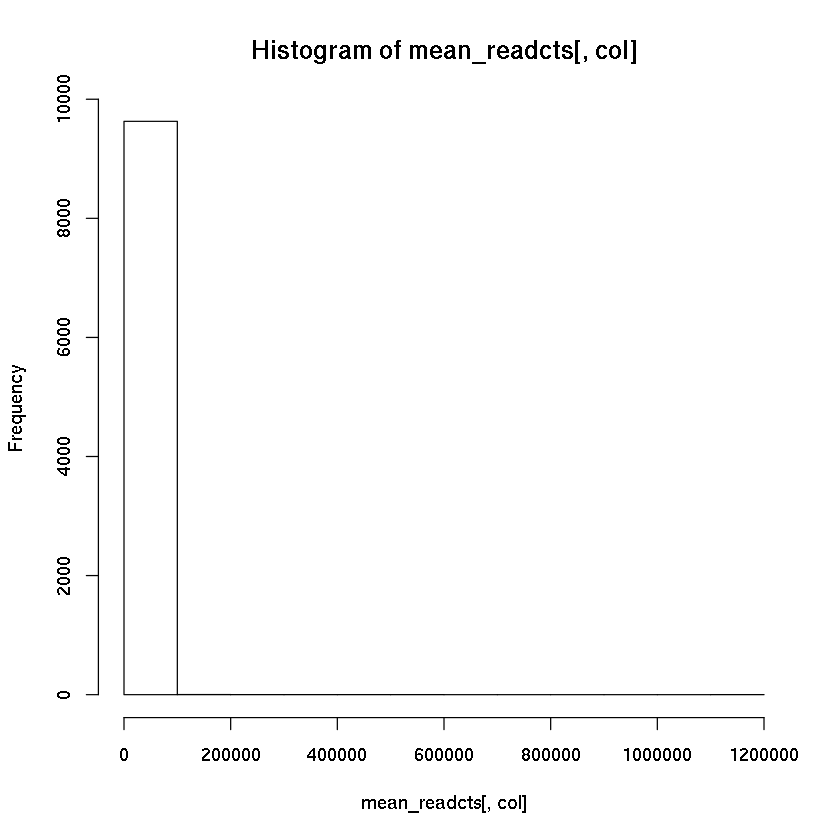

[1] 1211.015


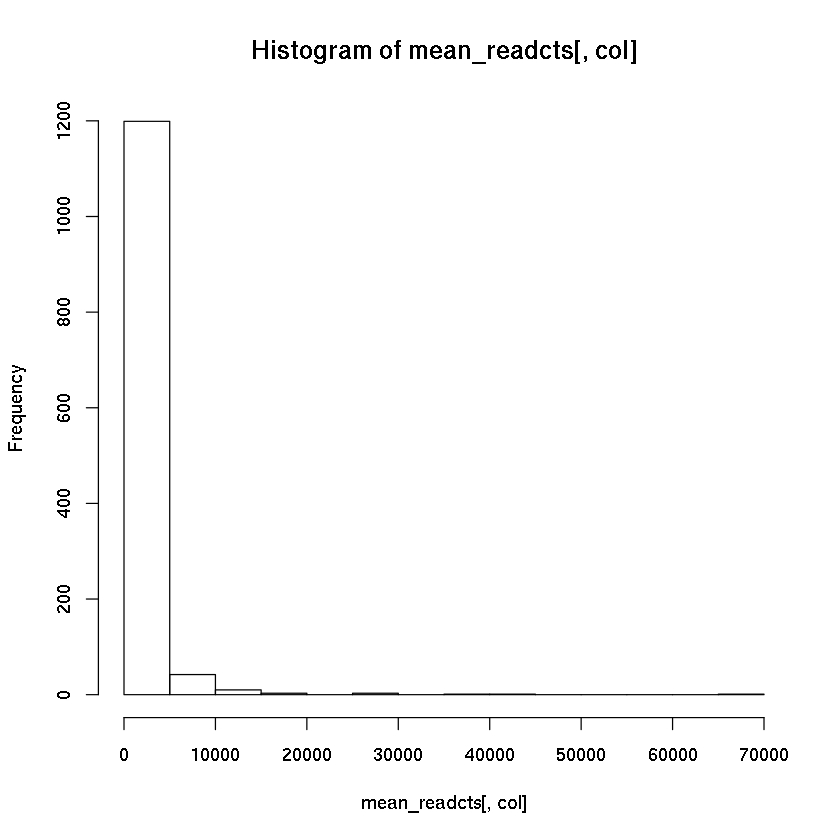

[1] 2160.645


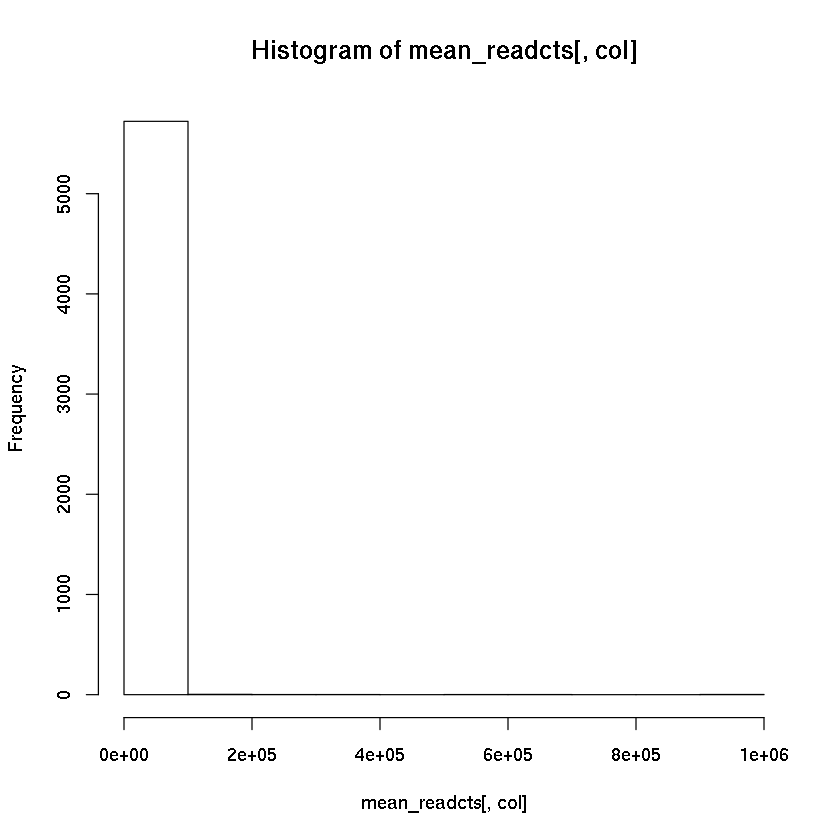

[1] 2114.639


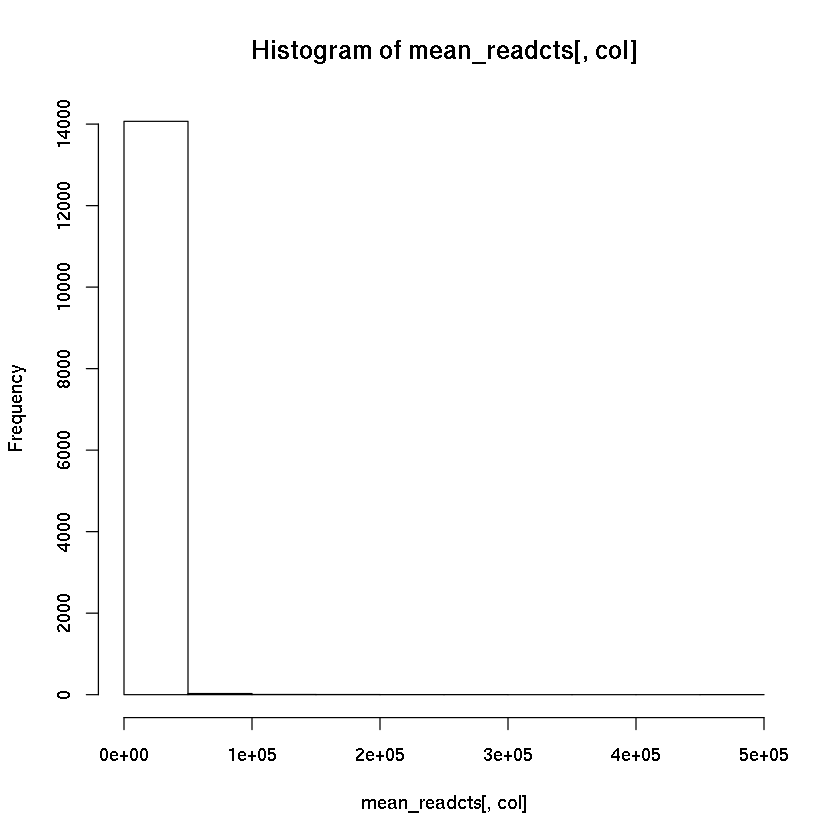

[1] 1836.608


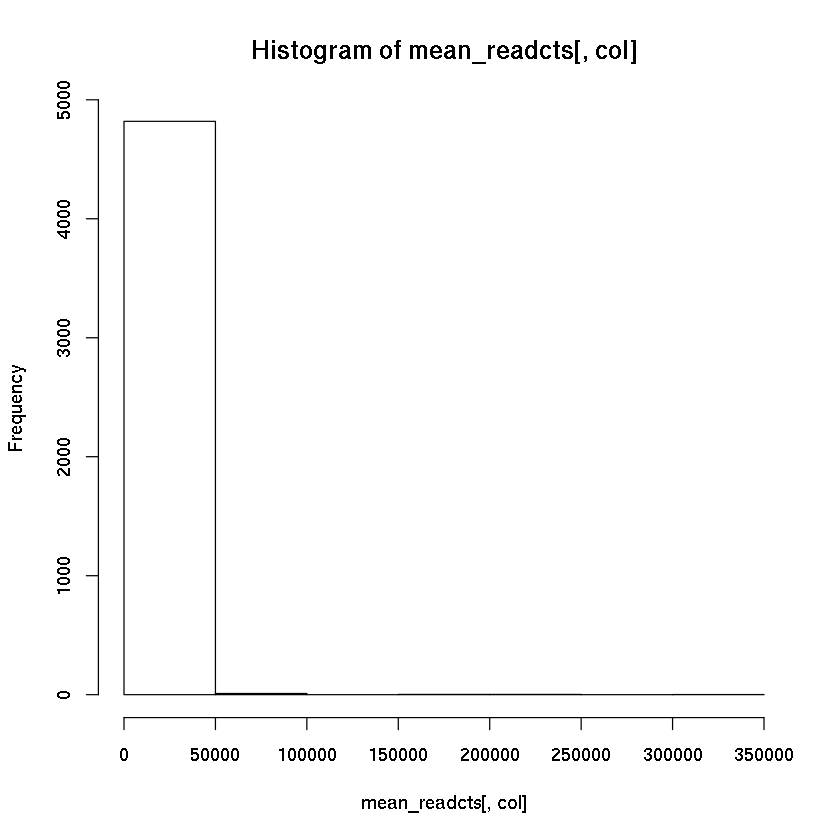

[1] 2884.459


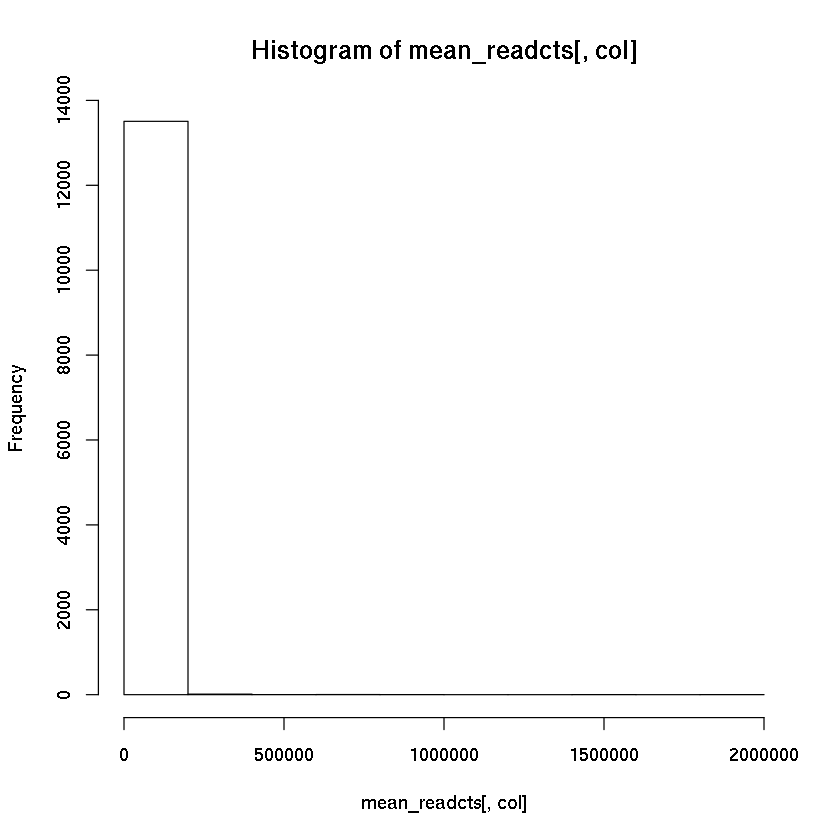

[1] 2267.173


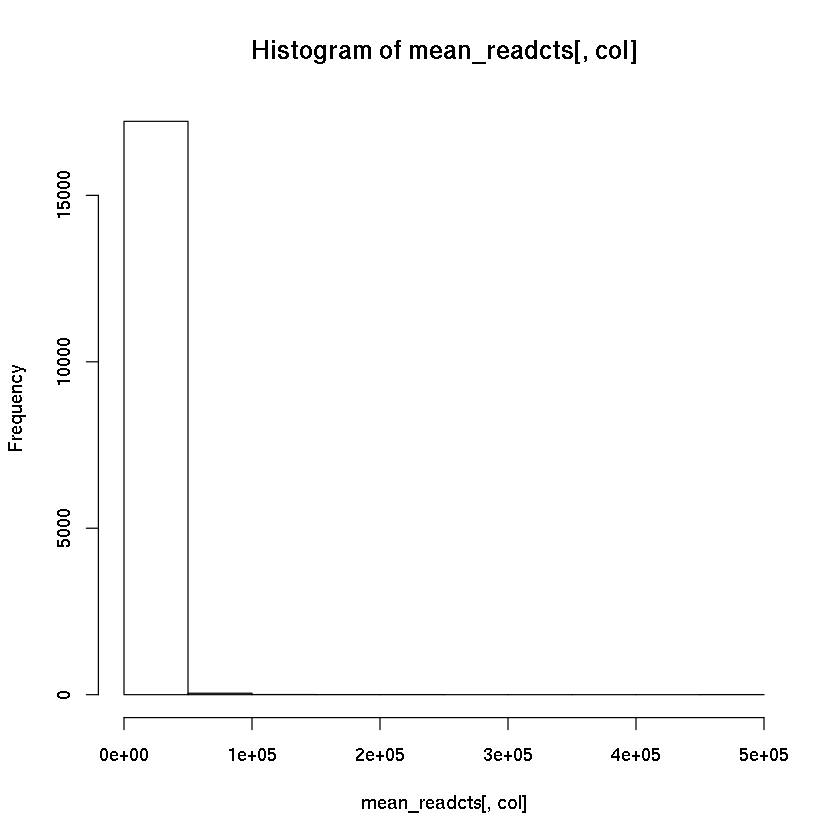

[1] 1998.101


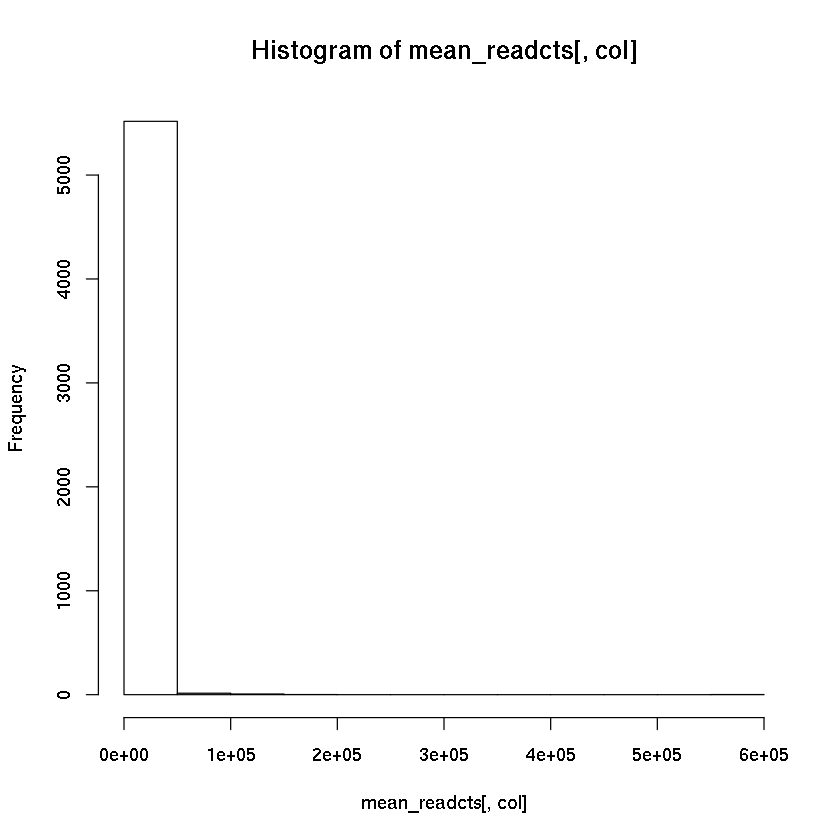

[1] 2662.4


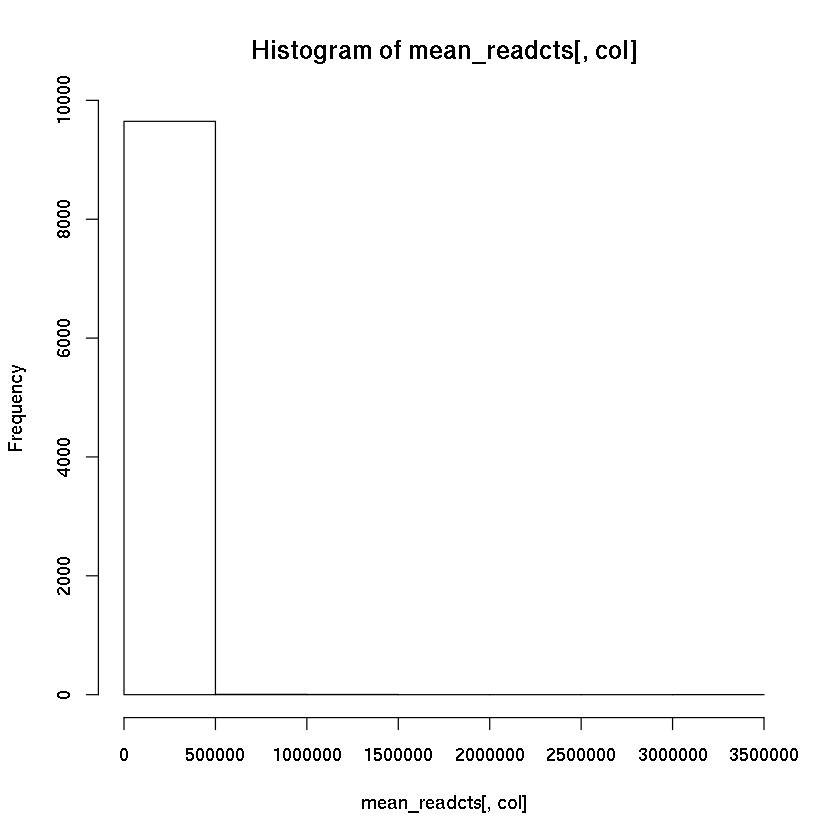

[1] 1863.467


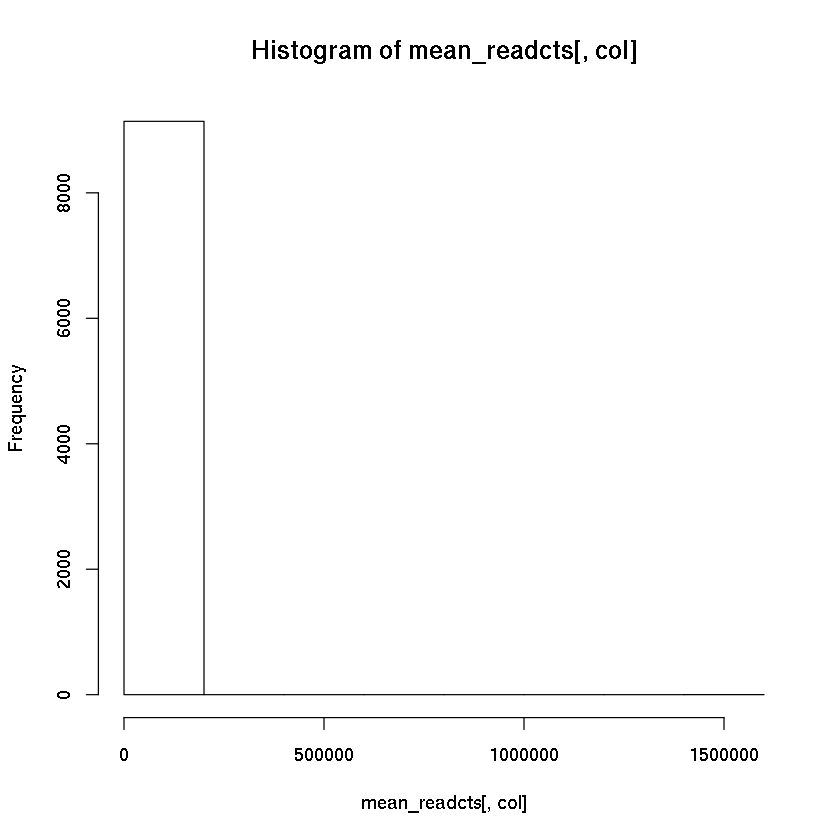

[1] 1745.696


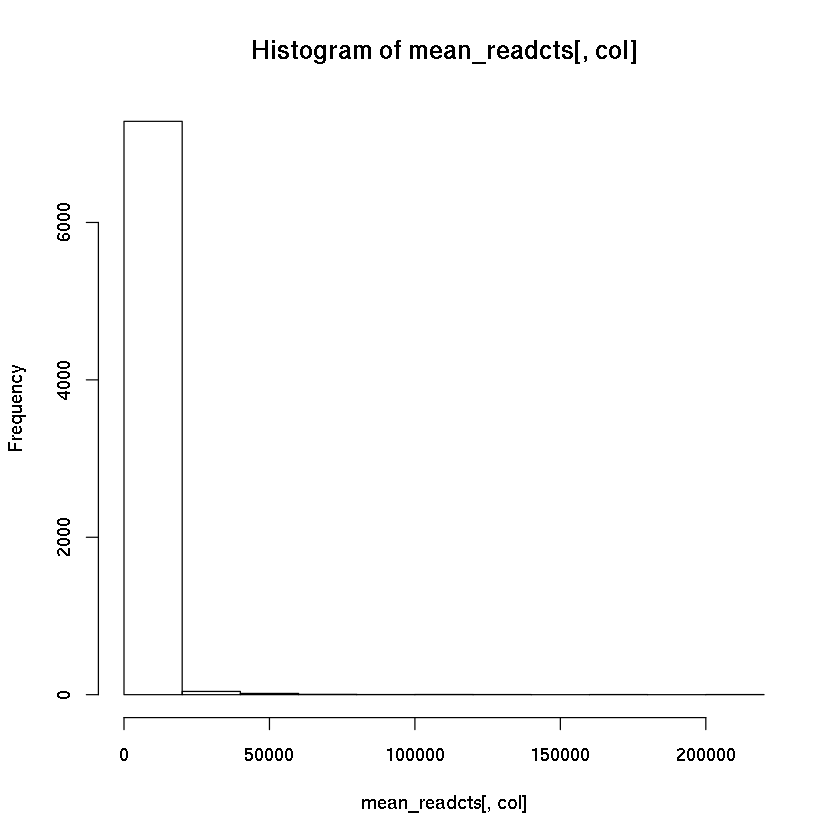

[1] 2215.02


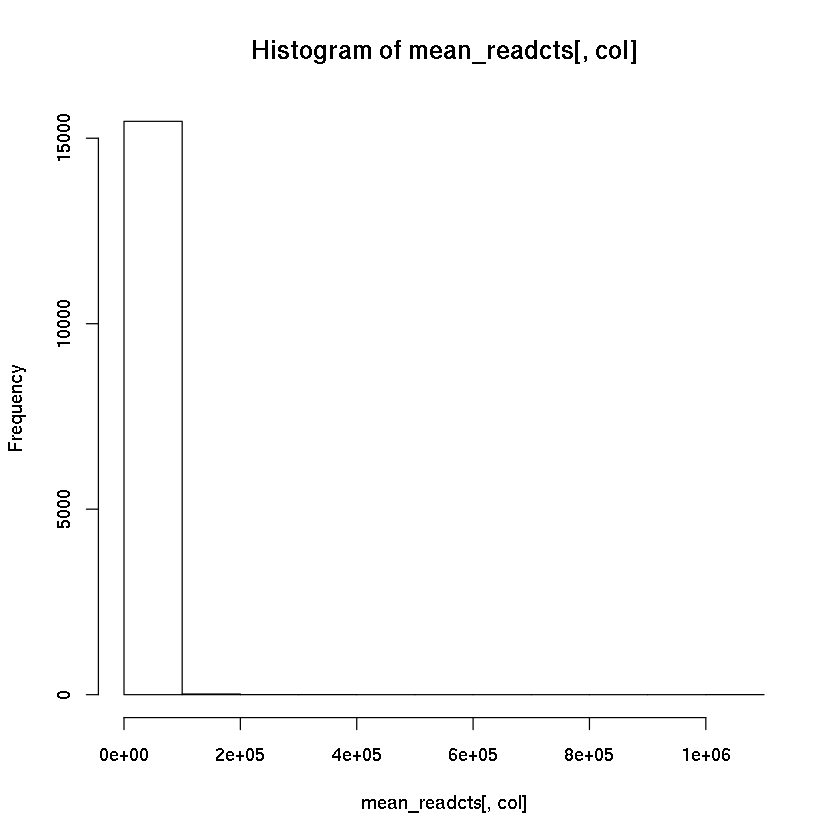

[1] 2295.312


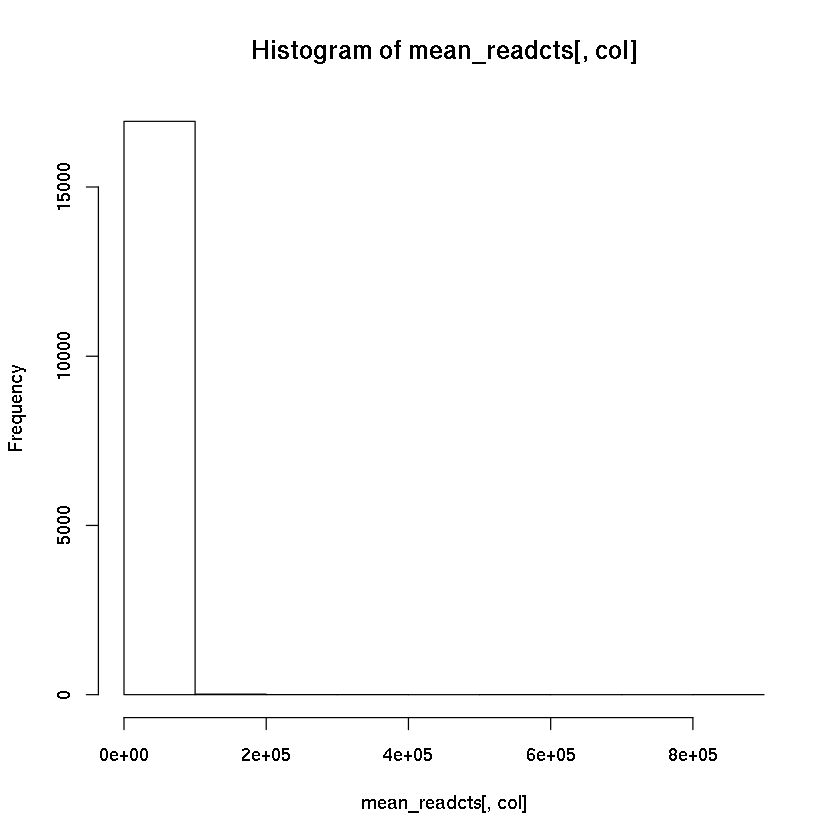

[1] 1829.099


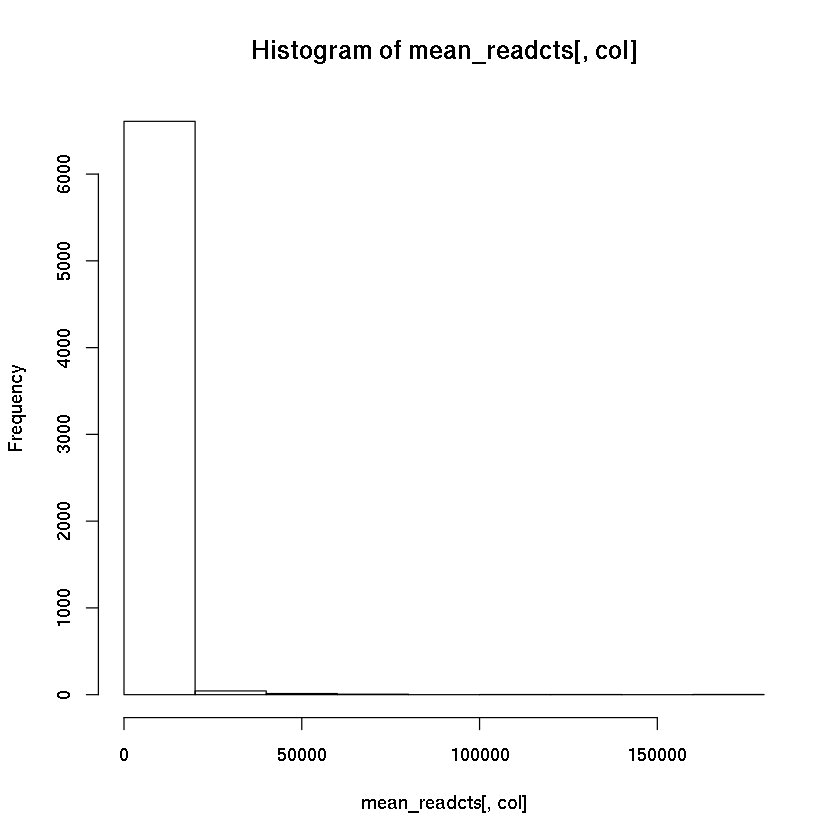

[1] 2014.265


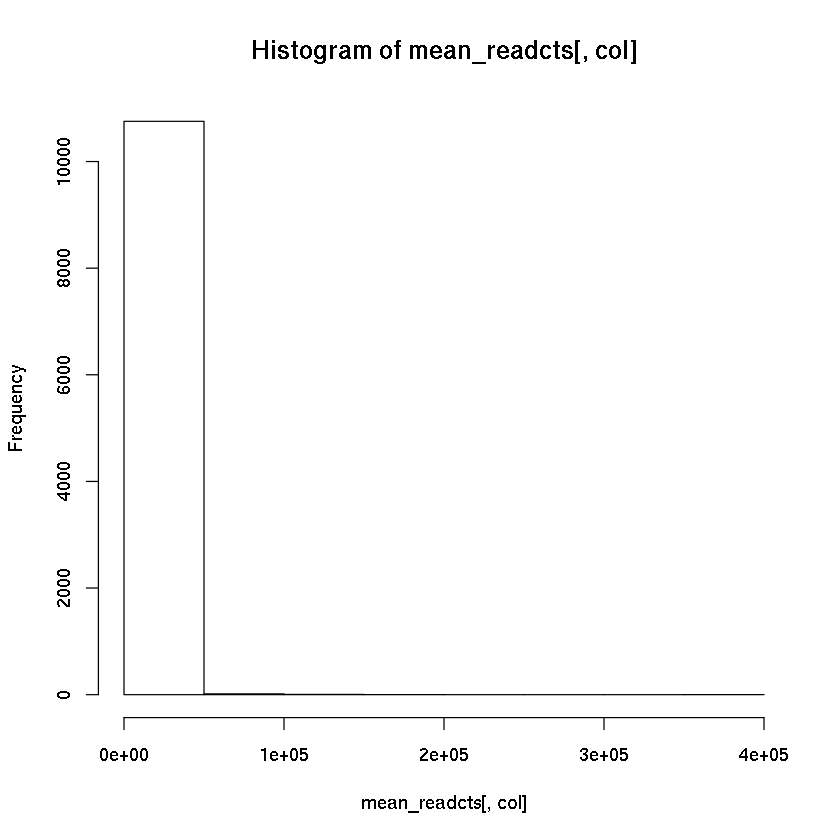

[1] 1869.178


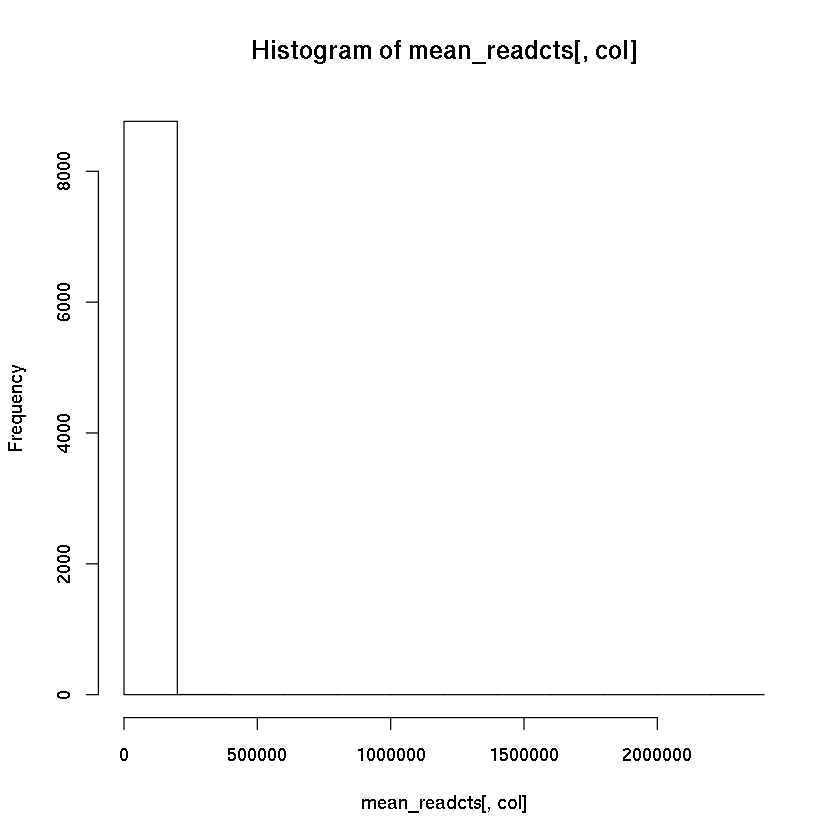

[1] 1669.027


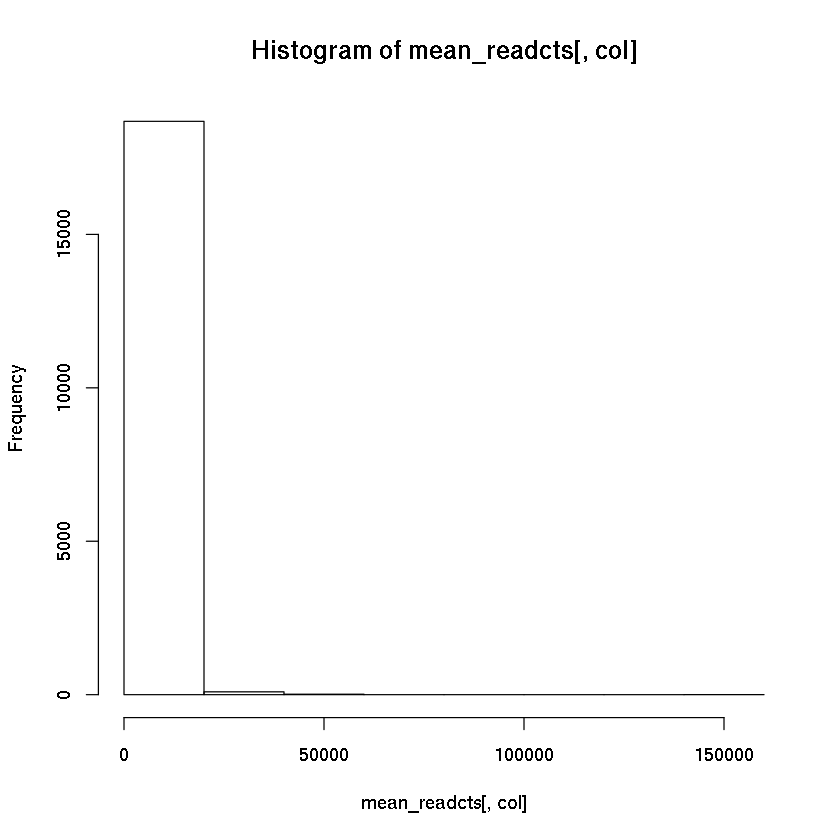

[1] 2196.824


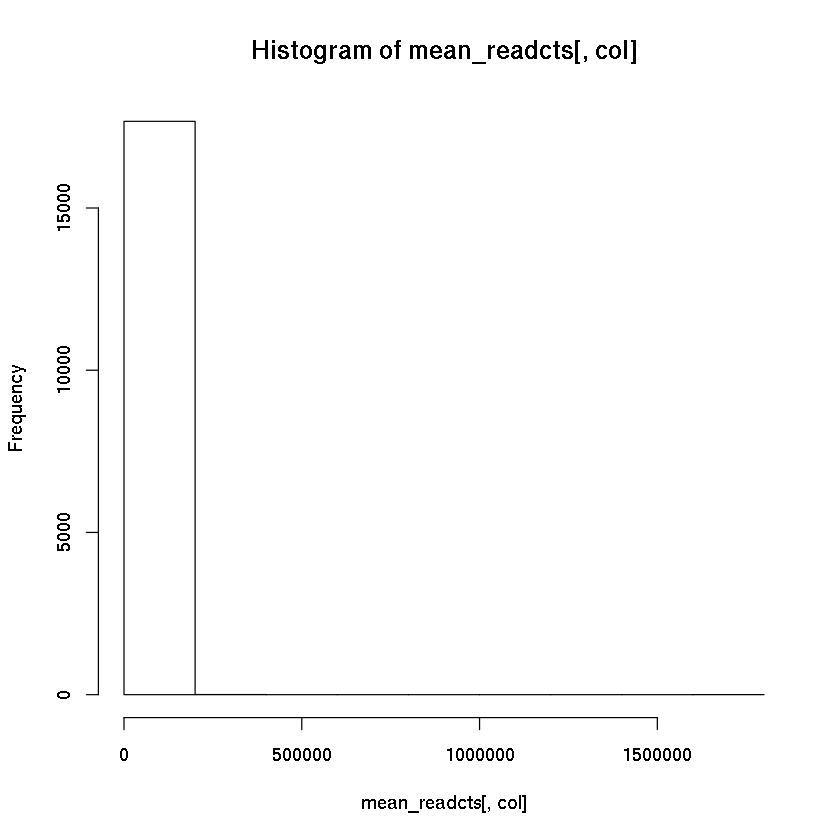

[1] 1551.762


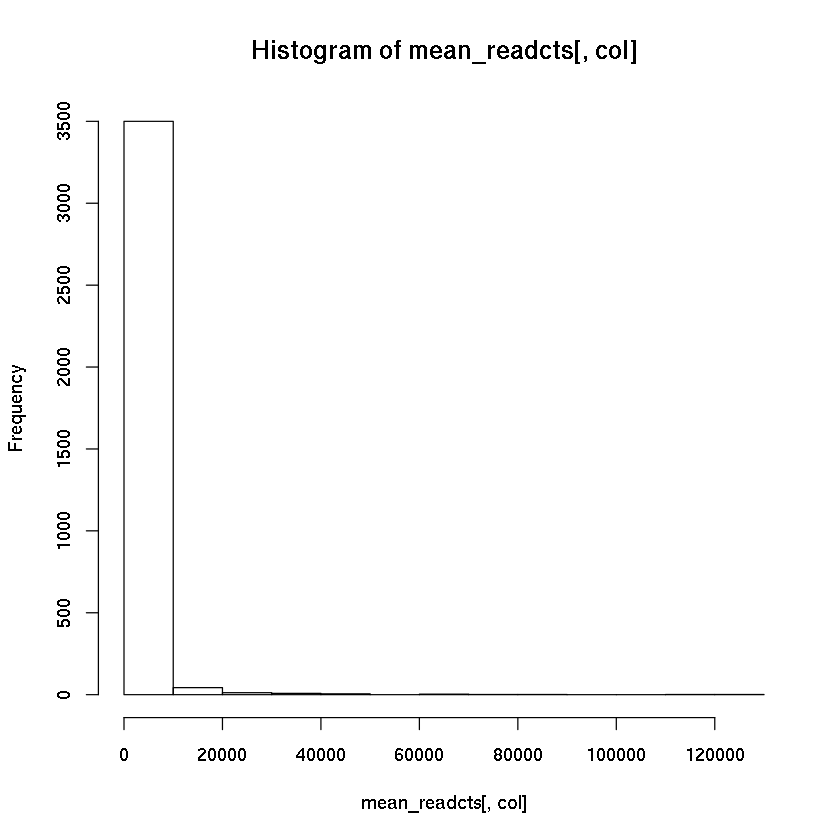

[1] 2050.216


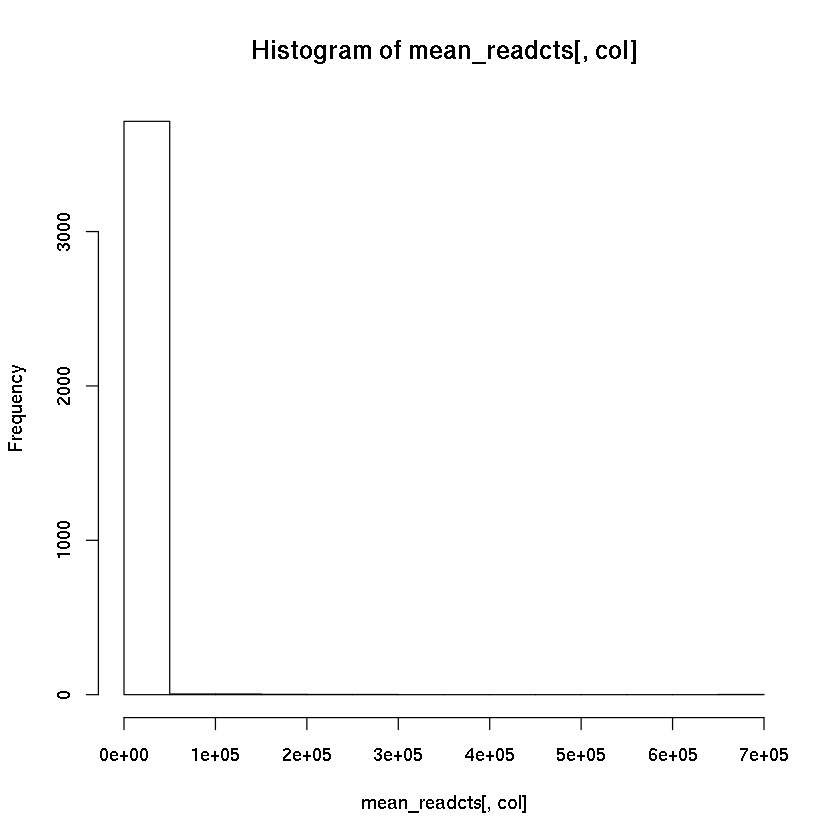

[1] 2306.452


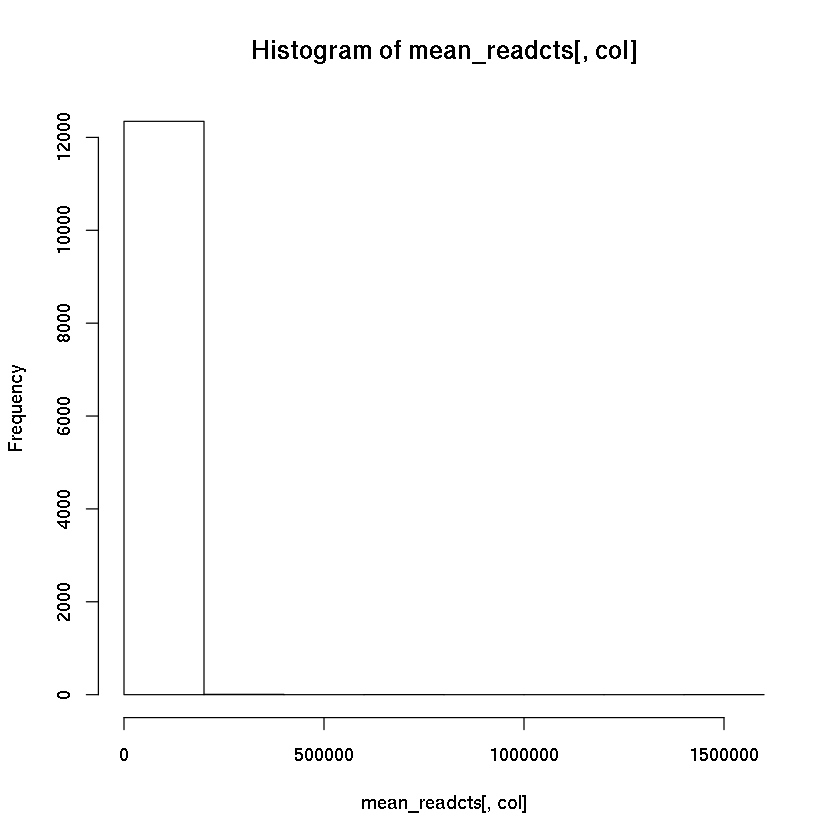

In [13]:
# for each column in readcounts ( tissue), plot a histogram 

#also print the mean for each tissue 

for(col in 3:ncol(mean_readcts)){   # skip names and description
    
    #plot histogram for each column
    
    hist(mean_readcts[,col], breaks=10)
    
    # mean of tissue 
    
    print(mean(mean_readcts[,col], na.rm=TRUE))
 
    }


In [11]:
library(dplyr)
library(ggplot2)
library(poilog)
### simulate observations

n <- rpoilog(S=1000,mu=1,sig=2)

### obtain estimates of parameters
est <- poilogMLE(n)

### similar, but now with bootstrapping ###
## Not run: est <- poilogMLE(n,nboot=10)

### change start values and request tracing information 
### from optimization procedure
est <- poilogMLE(n,startVals=c(2,3),
                 control=list(maxit=1000,trace=1, REPORT=1))

print(est$par[1])
print(est$par[2])

Warning message in log(1 - dpoilog(0, z[1], exp(z[2]))):
“NaNs produced”


initial  value 2866.994405 
iter   2 value 2731.566938
iter   3 value 2705.652055
iter   4 value 2704.841839
iter   5 value 2704.360959
iter   6 value 2704.354074
iter   7 value 2704.353610
iter   7 value 2704.353587
iter   7 value 2704.353561
final  value 2704.353561 
converged
      mu 
1.037985 
     sig 
1.946349 
